In [1]:
# Standard definitions needed for script
import numpy as np
import matplotlib.pyplot as plt
import numpy.ma as ma
import math
import astropy
from astropy.table import Table
from astropy.io import fits
import astropy.units as u
from astropy.coordinates.sky_coordinate import SkyCoord
from astropy.units import Quantity
from numpy.polynomial.polynomial import polyfit
import astropy.constants as const
from astropy.coordinates import Angle
import pickle
import pandas as pd
from matplotlib.patches import Rectangle
from sklearn.cluster import KMeans
import scipy
from sklearn import neighbors
from scipy.stats import kde
import filtermanage as fm
%matplotlib inline

#Read in local functions
#from CalculateProperties import CalculateProperties 

In [ ]:
#SIMBAD QUERY

for i in range(0,len(spd_c2didx)):
     ii = int(spd_c2didx[i])
     from astroquery.simbad import Simbad
     result_table = Simbad.query_region(SkyCoord(rac2df[ii]*u.degree,decc2df[ii]*u.degree, frame='icrs'), radius='0d0m40s')
     print(ii, rac2df[ii], decc2df[ii], result_table)

# Read in Data and Cross Match

In [2]:
#Read in GAIA data
file = 'Data/GAIA_data2.pkl'
with open(file,'rb') as f: 
    data = pickle.load(f)
GTab = data['GTab']

#Print column names
print (GTab.colnames)

#Assign columns from table to variables
Gra = GTab["ra"]
Gdec = GTab["dec"]
Gpmra = GTab["pmra"]
Gpmra_e = GTab["pmra_error"]
Gpmdec = GTab["pmdec"]
Gpmdec_e = GTab["pmdec_error"]
Gpar = GTab["parallax"]
Gpar_e = GTab['parallax_error']
Gpar_sn = GTab["parallax_over_error"]
Gsepar = GTab["angular_distance"]
G2MASS = GTab["designation_2"]
g = GTab["phot_g_mean_mag"]
b = GTab["phot_bp_mean_mag"]
r = GTab["phot_rp_mean_mag"]
J = GTab["j_m"]
H = GTab["h_m"]
K = GTab["ks_m"]
print(" GAIA Table contains ",len(Gra)," sources")


#calculate distance in pc 
Gdist = 1000./Gpar
Gdist_e = 1000./(Gpar**2)

#Calculate velocity in km/s
Gpmra_km = 4.74*(Gpmra/1000.)*Gdist
Gpmdec_km = 4.74*(Gpmdec/1000.)*Gdist

#Calculate uncertainty in velocity
Gpmra_km_e = Gpmra_km*np.sqrt((Gdist_e/Gdist)**2+(Gpmra_e/Gpmra)**2)
Gpmdec_km_e = Gpmdec_km*np.sqrt((Gdist_e/Gdist)**2+(Gpmdec_e/Gpmdec)**2)


#add variables to a dictionary
Gvalues = {'ra':Gra,'dec':Gdec,'pmra':Gpmra,'pmra_error':Gpmra_e,'pmdec':Gpmdec,'pmdec_error':Gpmdec_e,\
           'parallax':Gpar,'parallax_error':Gpar_e,'par_over_e':Gpar_sn,'Dist':Gdist,'Dist error':Gdist_e,\
           'pmra_km':Gpmra_km,'pmdec_km':Gpmdec_km,'pmra_km_e':Gpmra_km_e,'pmdec_km_e':Gpmdec_km_e}

#creates list of indentifiers from 2MASS
gaia_list = []
for i in range(0,len(G2MASS)):
    gaia_list.append(G2MASS[i].decode('utf-8'))

['solution_id', 'designation', 'source_id', 'random_index', 'ref_epoch', 'ra', 'ra_error', 'dec', 'dec_error', 'parallax', 'parallax_error', 'parallax_over_error', 'pmra', 'pmra_error', 'pmdec', 'pmdec_error', 'ra_dec_corr', 'ra_parallax_corr', 'ra_pmra_corr', 'ra_pmdec_corr', 'dec_parallax_corr', 'dec_pmra_corr', 'dec_pmdec_corr', 'parallax_pmra_corr', 'parallax_pmdec_corr', 'pmra_pmdec_corr', 'astrometric_n_obs_al', 'astrometric_n_obs_ac', 'astrometric_n_good_obs_al', 'astrometric_n_bad_obs_al', 'astrometric_gof_al', 'astrometric_chi2_al', 'astrometric_excess_noise', 'astrometric_excess_noise_sig', 'astrometric_params_solved', 'astrometric_primary_flag', 'astrometric_weight_al', 'astrometric_pseudo_colour', 'astrometric_pseudo_colour_error', 'mean_varpi_factor_al', 'astrometric_matched_observations', 'visibility_periods_used', 'astrometric_sigma5d_max', 'frame_rotator_object_type', 'matched_observations', 'duplicated_source', 'phot_g_n_obs', 'phot_g_mean_flux', 'phot_g_mean_flux_erro

In [3]:
#Information about the parallax and distance ranges 
print('The minimum parallax is',Gpar.min())
max_distance = 1000/Gpar.min()
print('The maximum distance is',max_distance)
print('The minimum parallax signal to noise is',Gpar_sn.min())

The minimum parallax is 1.6000160653931248
The maximum distance is 624.993724518822
The minimum parallax signal to noise is 3.0000975


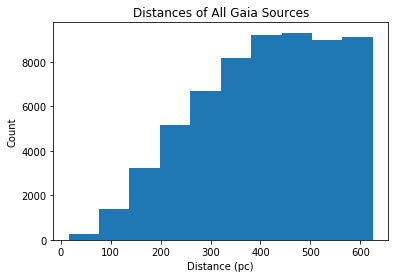

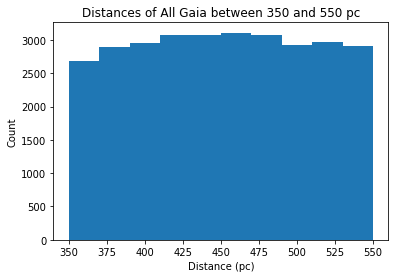

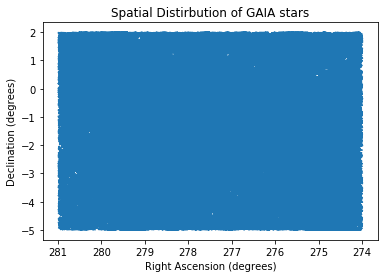

In [4]:
#plot the distances of all of the stars

plt.hist(Gdist)
plt.title('Distances of All Gaia Sources')
plt.xlabel('Distance (pc)')
plt.ylabel('Count')
plt.savefig('Figures/StarPlots/GaiaStars_All_distances.png',dpi=300)
plt.show()
#the numbers on the plot disagree because the bin sizes in the diagrams are different

Gdist2 = Gdist[Gdist >= 350]
plt.hist(Gdist2[Gdist2 <= 550])
plt.title('Distances of All Gaia between 350 and 550 pc')
plt.xlabel('Distance (pc)')
plt.ylabel('Count')
plt.savefig('Figures/StarPlots/GaiaStars_350to550_distances.png',dpi=300)
plt.show()

plt.plot(Gra,Gdec)
plt.gca().invert_xaxis()
plt.xlabel('Right Ascension (degrees)')
plt.ylabel('Declination (degrees)')
plt.title('Spatial Distirbution of GAIA stars')
plt.savefig('Figures/StarPlots/GaiaStars_All_SpatialDistribution.png',dpi=300)
plt.show()

## Read in YSO and S+D Catalogs

In [5]:
#read in gould belt YSO catalog
infile = "Data/SERAQU-YSOs.tbl"
GBYSO = Table.read(infile,format="ascii.ipac")
print(GBYSO.colnames)
GBYSOra = GBYSO["ra"]
GBYSOdec = GBYSO["dec"]
GBYSO2MASS = GBYSO["id2mass"]
print("Read ",len(GBYSOra)," YSOs from GB YSO catalog")

#match Gould Belt YSO and GAIA using 2MASS identifiers
#create array of indices where there is a match. A value of -2 inidcates no match to GAIA
GBYSO_match = np.empty(len(GBYSO2MASS),dtype=int); GBYSO_match.fill(-2)
for j in range(0,len(GBYSO2MASS)):
    if(GBYSO2MASS[j] in gaia_list):
        GBYSO_match[j] = gaia_list.index(GBYSO2MASS[j])
    else:
        GBYSO_match[j] = -2
good_GBYSO = GBYSO_match > -1
print(len(GBYSO_match[good_GBYSO]))
print(np.where(GBYSO_match > -1))

#read in gould belt stars + dust catalgog
infile = "Data/SERP_GB_star+dust.tbl"
GBSD = Table.read(infile,format="ascii.ipac")
# print(GBSD.colnames)
GBSDra = GBSD["ra"]
GBSDdec = GBSD["dec"]
GBSD2MASS = GBSD["id2mass"]
print("Read ",len(GBSDra)," YSOs from GB Star+Dust catalog")

#match Gould Belt stars+dust and GAIA using 2MASS identifiers
#create array of indices where there is a match. A value of -2 inidcates no match to GAIA
GBSD_match = np.empty(len(GBSD2MASS),dtype=int); GBSD_match.fill(-2)
for j in range(0,len(GBSD2MASS)):
    if(GBSD2MASS[j] in gaia_list):
        GBSD_match[j] = gaia_list.index(GBSD2MASS[j])
    else:
        GBSD_match[j] = -2
good_GBSD = GBSD_match > -1
print(len(GBSD_match[good_GBSD]))
print(np.where(GBSD_match > -1))

#read in c2d YSO catalog 
infile = "Data/catalog-SER-YSOc.tbl"
c2dYSO = Table.read(infile,format="ascii.ipac")
print(c2dYSO.colnames)
c2dYSOra = c2dYSO["ra"]
c2dYSOdec = c2dYSO["dec"]
c2dYSO2MASS = c2dYSO["id2mass"]
c2dYSOobj = c2dYSO["object_type"]
print("Read ",len(c2dYSOra)," YSOs from c2d YSO catalog")

#match c2d YSO and GAIA using 2MASS identifiers
#create array of indices where there is a match. A value of -2 inidcates no match to GAIA
c2dYSO_match = np.empty(len(c2dYSO2MASS),dtype=int); c2dYSO_match.fill(-2)
for j in range(0,len(c2dYSO2MASS)):
    if(c2dYSO2MASS[j] in gaia_list):
        c2dYSO_match[j] = gaia_list.index(c2dYSO2MASS[j])
    else:
        c2dYSO_match[j] = -2
good_c2dYSO = c2dYSO_match > -1
print(len(c2dYSO_match[good_c2dYSO]))
print(np.where(c2dYSO_match > -1))

#read in c2d YSO stars+dust catalog
infile = "Data/SERP_c2d_star+dust.tbl"
c2dSD = Table.read(infile,format="ascii.ipac")
# print(GBSD.colnames)
c2dSDra = c2dSD["ra"]
c2dSDdec = c2dSD["dec"]
c2dSD2MASS = c2dSD["id2mass"]
print("Read ",len(c2dSDra)," YSOs from c2d Star+Dust catalog")

#match c2d stars+dust and GAIA using 2MASS identifiers
#create array of indices where there is a match. A value of -2 inidcates no match to GAIA
c2dSD_match = np.empty(len(c2dSD2MASS),dtype=int); c2dSD_match.fill(-2)
for j in range(0,len(c2dSD2MASS)):
    if(c2dSD2MASS[j] in gaia_list):
        c2dSD_match[j] = gaia_list.index(c2dSD2MASS[j])
    else:
        c2dSD_match[j] = -2
good_c2dSD = c2dSD_match > -1
print(len(c2dSD_match[good_c2dSD]))
print(np.where(c2dSD_match > -1))

#total number of YSO matches

#create array of YSO matches
YSO_match = c2dYSO_match; YSO_match = np.append(YSO_match,GBYSO_match)
good_YSO = YSO_match > -1
print("Total number of GAIA matches to YSOs: ",len(YSO_match[good_YSO]))

#Create array of Star + Dust matches
SD_match = c2dSD_match; SD_match = np.append(SD_match,GBSD_match)
good_SD = SD_match > -1
print("Total number of GAIA matches to star+dust: ",len(SD_match[good_SD]))

#Create array of all YSO and stars+dust matches
ALL_match = YSO_match
ALL_match = np.append(ALL_match,SD_match)
good_ALL = ALL_match > -1
print("Total number of all matches: ",len(ALL_match[good_ALL]))

['GBS_ID', 'ra', 'D_ra', 'dec', 'D_dec', 'Q_pos', 'Q_merge', 'id2mass', 'Prob_Galc', 'alpha', 'D_alpha', 'alpha_chi2', 'alpha_nfit', 'object_type', 'Av', 'D_Av', 'mag_IR1', 'D_mag_IR1', 'Av_chi2', 'Av_nfit', 'J_flux_c', 'J_D_flux_c', 'J_date_c', 'J_Q_det_c', 'H_flux_c', 'H_D_flux_c', 'H_date_c', 'H_Q_det_c', 'Ks_flux_c', 'Ks_D_flux_c', 'Ks_date_c', 'Ks_Q_det_c', 'IR1_flux_1', 'IR1_D_flux_1', 'IR1_date_1', 'IR1_Q_det_1', 'IR1_flux_2', 'IR1_D_flux_2', 'IR1_date_2', 'IR1_Q_det_2', 'IR1_flux_c', 'IR1_D_flux_c', 'IR1_date_c', 'IR1_Q_det_c', 'IR1_Q_flux_m', 'IR1_imtype', 'IR1_src_area', 'IR1_amajor', 'IR1_aminor', 'IR1_tilt', 'IR2_flux_1', 'IR2_D_flux_1', 'IR2_date_1', 'IR2_Q_det_1', 'IR2_flux_2', 'IR2_D_flux_2', 'IR2_date_2', 'IR2_Q_det_2', 'IR2_flux_c', 'IR2_D_flux_c', 'IR2_date_c', 'IR2_Q_det_c', 'IR2_Q_flux_m', 'IR2_imtype', 'IR2_src_area', 'IR2_amajor', 'IR2_aminor', 'IR2_tilt', 'IR3_flux_1', 'IR3_D_flux_1', 'IR3_date_1', 'IR3_Q_det_1', 'IR3_flux_2', 'IR3_D_flux_2', 'IR3_date_2', 'IR3_Q

In [135]:
#Read in galc files

#read in gould belt galc catalog
infile = "Data/GB_galc.tbl"
GBgalc = Table.read(infile,format="ascii.ipac")
print(GBgalc.colnames)
GBgalcra = GBgalc["ra"]
GBgalcdec = GBgalc["dec"]
GBgalc2MASS = GBgalc["id2mass"]
print("Read ",len(GBgalcra)," galcs from GB galc catalog")

#match Gould Belt galc and GAIA using 2MASS identifiers
#create array of indices where there is a match. A value of -2 inidcates no match to GAIA
GBgalc_match = np.empty(len(GBgalc2MASS),dtype=int); GBgalc_match.fill(-2)
for j in range(0,len(GBgalc2MASS)):
    if(GBgalc2MASS[j] in gaia_list):
        GBgalc_match[j] = gaia_list.index(GBgalc2MASS[j])
    else:
        GBgalc_match[j] = -2
good_GBgalc = GBgalc_match > -1
print('The number of matches is',len(GBgalc_match[good_GBgalc]))
print(np.where(GBgalc_match > -1))
print("Distances:",Gvalues['Dist'][np.where(GBgalc_match > -1)])

#read in c2d galc catalog
infile = "Data/c2d_galc.tbl"
c2dgalc = Table.read(infile,format="ascii.ipac")
print(c2dgalc.colnames)
c2dgalcra = c2dgalc["ra"]
c2dgalcdec = c2dgalc["dec"]
c2dgalc2MASS = c2dgalc["id2mass"]
print("Read ",len(c2dgalcra)," glacs from c2d galc catalog")

#match Gould Belt galc and GAIA using 2MASS identifiers
#create array of indices where there is a match. A value of -2 inidcates no match to GAIA
c2dgalc_match = np.empty(len(c2dgalc2MASS),dtype=int)
c2dgalc_match.fill(-2)
for j in range(0,len(c2dgalc2MASS)):
    if(c2dgalc2MASS[j] in gaia_list):
        c2dgalc_match[j] = gaia_list.index(c2dgalc2MASS[j])
    else:
        c2dgalc_match[j] = -2
good_c2dgalc = c2dgalc_match > -1
print('The number of matches is',len(c2dgalc_match[good_c2dgalc]))
print(np.where(c2dgalc_match > -1))
print("Distances:",Gvalues['Dist'][np.where(c2dgalc_match > -1)])

#create array of GALC matches
GALC_match = c2dgalc_match; GALC_match = np.append(GALC_match,GBgalc_match)
good_GALC = GALC_match > -1
print("Total number of GAIA matches to GALC: ",len(GALC_match[good_GALC]))

['GBS_ID', 'ra', 'D_ra', 'dec', 'D_dec', 'Q_pos', 'Q_merge', 'id2mass', 'Prob_Galc', 'alpha', 'D_alpha', 'alpha_chi2', 'alpha_nfit', 'object_type', 'Av', 'D_Av', 'mag_IR1', 'D_mag_IR1', 'Av_chi2', 'Av_nfit', 'J_flux_c', 'J_D_flux_c', 'J_date_c', 'J_Q_det_c', 'H_flux_c', 'H_D_flux_c', 'H_date_c', 'H_Q_det_c', 'Ks_flux_c', 'Ks_D_flux_c', 'Ks_date_c', 'Ks_Q_det_c', 'IR1_flux_1', 'IR1_D_flux_1', 'IR1_date_1', 'IR1_Q_det_1', 'IR1_flux_2', 'IR1_D_flux_2', 'IR1_date_2', 'IR1_Q_det_2', 'IR1_flux_c', 'IR1_D_flux_c', 'IR1_date_c', 'IR1_Q_det_c', 'IR1_Q_flux_m', 'IR1_imtype', 'IR1_src_area', 'IR1_amajor', 'IR1_aminor', 'IR1_tilt', 'IR2_flux_1', 'IR2_D_flux_1', 'IR2_date_1', 'IR2_Q_det_1', 'IR2_flux_2', 'IR2_D_flux_2', 'IR2_date_2', 'IR2_Q_det_2', 'IR2_flux_c', 'IR2_D_flux_c', 'IR2_date_c', 'IR2_Q_det_c', 'IR2_Q_flux_m', 'IR2_imtype', 'IR2_src_area', 'IR2_amajor', 'IR2_aminor', 'IR2_tilt', 'IR3_flux_1', 'IR3_D_flux_1', 'IR3_date_1', 'IR3_Q_det_1', 'IR3_flux_2', 'IR3_D_flux_2', 'IR3_date_2', 'IR3_Q

In [ ]:
#Combine GB and c2d YSO tables
YSO = astropy.table.vstack([c2dYSO,GBYSO])

#Combine GB and c2d SD tables
SD = astropy.table.vstack([c2dSD,GBSD])

# Borders of Serpens Regions

In [6]:
#Coordinates that indicate the borders (in RA and Dec) of rectangular regions in 
#Serpens that contain sources used for analysis

#Serpens East
ra_min1 = 278.7
ra_max1 = 280.3
dec_min1 = -1
dec_max1 = 1.2
width1 = (ra_max1-ra_min1)
height1 = (dec_max1 - dec_min1)

#Borders for Serpens East region 
sky_region1 = [ra_min1,ra_max1,dec_min1,dec_max1]

#Region that contains all of W40, Serpens South, and West Arm
ra_min2 = 276.6
ra_max2 = 278.5
dec_min2 = -5.1
dec_max2 = -1.3
width2 = (ra_max2-ra_min2)
height2 = (dec_max2 - dec_min2)

#Borders for region that encloses W40, Serpens South, and West Arm
sky_region2 = [ra_min2,ra_max2,dec_min2,dec_max2]

#Region that contins both W40 and Serpens South
dec_split2 = -3.0
ra_min2u = ra_min2
ra_max2u = ra_max2
dec_min2u = dec_split2
dec_max2u = dec_max2
width2u = (ra_max2u-ra_min2u)
height2u = (dec_max2u-dec_min2u)

#Borders for region that encloses W40 and serpens south
sky_region2u = [ra_min2u,ra_max2u,dec_min2u,dec_max2u]

#West Arm
ra_min2d = ra_min2
ra_max2d = ra_max2
dec_min2d = dec_min2
dec_max2d = dec_split2
width2d = (ra_max2d-ra_min2d)
height2d = (dec_max2d-dec_min2d)

#Borders for West Arm Region
sky_region2d = [ra_min2d,ra_max2d,dec_min2d,dec_max2d]

#W40
ra_split2 = 277.51
ra_minW40 = ra_split2
ra_maxW40 = ra_max2
dec_minW40 = dec_min2u
dec_maxW40 = dec_max2u
widthW40 = (ra_maxW40-ra_minW40)
heightW40 = (dec_maxW40-dec_minW40)


#Borders for W40
sky_regionW40 = [ra_minW40,ra_maxW40,dec_minW40,dec_maxW40]

#Region next to W40 with the same area
sky_regionW40side = [ra_maxW40,ra_maxW40+widthW40,dec_minW40,dec_maxW40]

# Serpens South
ra_minS = ra_min2
ra_maxS = ra_split2
dec_minS = dec_min2u
dec_maxS = dec_max2u
widthS = (ra_maxS-ra_minS)
heightS = (dec_maxS-dec_minS)

#Borders for Serpens South 
sky_regionS = [ra_minS,ra_maxS,dec_minS,dec_maxS]

#Region that contains both Serpens Main and Serpens B
ra_min3 = 276.75
ra_max3 = 277.75
dec_min3 = -0.7
dec_max3 = 2.1
width3 = (ra_max3-ra_min3)
height3 = (dec_max3 - dec_min3)

#Borders for region that contains Serpens Main and Serpens B 
sky_region3 = [ra_min3,ra_max3,dec_min3,dec_max3]

#Serpens Main
dec_split3 = 0.4
ra_min3u = ra_min3
ra_max3u = ra_max3
dec_min3u = dec_split3
dec_max3u = dec_max3
width3u = (ra_max3u-ra_min3u)
height3u = (dec_max3u - dec_min3u)

#Borders for Serpens  Main
sky_region3u = [ra_min3u,ra_max3u,dec_min3u,dec_max3u]

#Serpens B
ra_min3d = ra_min3
ra_max3d = ra_max3
dec_min3d = dec_min3
dec_max3d = dec_split3
width3d = (ra_max3d-ra_min3d)
height3d = (dec_max3d - dec_min3d)

#Borders for Serpens South
sky_region3d = [ra_min3d,ra_max3d,dec_min3d,dec_max3d]

# Functions

In [133]:
def CalculateProperties(region,star_type,match,Gvalues,distance_range = [0.,630.],sky_region = [273.99,280.99,-5.,2.], \
                        adj=[0,0,0,0],exclude=np.array([6666666666666])):    
        '''
        Function to calculate the properties sources (YSO, star+dust or both)
        that have been cross matched with GAIA in a given region and distance range
        Calculates values for both all source and for sources with parallax signal to noise greater than 10
        Uses median of sources with signal to noise greater than 10 to determine relative velocities
        Prints out properties and plots histograms and spatial plots of the data.
        Plots are saved in Figures/region
        
        Inputs:
        region: String that indicates what region of Serpens we are looking at
        star_type: String that describes the type of source observed (YSO, S+D, GalC or Star)
        match: Array of indices of sources in GAIA table. Sources that do not have match have value of -2
        Gvalues: Dictionary that contains columns from GAIA table (not necessary to read in b/c global variable)
        distance rage: Distance range for sources. Default is [0,630]
        sky_region: Borders of region in which sources are located. Default is entire Serpens Cloud[273.99,280.99,-5.,2.]
        adj: Values to add to xlimit and ylimit to extend the plot region. Default is [0,0,0,0]
        exclude: Array of indices of sources in GAIA table of sources to EXCLUDE. Default is array with no values
        
        Outputs:
        result: Dictionary that contains arrays of properties of sources within specified distance and region
        'ra': array of right ascension
        'dec': array of declinations
        'pmra': array of proper motion in ra
        'pmra_e': arrya of error in proper motion in ra
        'pmdec': array of proper motion in declination
        'pmdec_e': array of error in proper motion in declination
        'par': array of parallax
        'par_e': array of parallax error
        'par_sn': array of parallax signal to noise
        'dist': array of distance
        'dist_e' array of distance errors
        'pmra_km': proper motion velocity in ra in km/s
        'pmra_km_e': error in proper motion velocity in ra in km/s,
        'pmdec_km': proper motion velocity in declination in km/s
        'pmdec_km_e': error in proper motion velocity in declination in km/s
        'mean_pmra': mean ra velocity of region (stars with parallax S/N >10)
        'mean_pmra_err': error in mean ra velocity of region (stars with parallax S/N >10)
        'mean_pmdec': mean dec velocity of region (stars with parallax S/N >10)
        'mean_pmdec_err': error in mean dec velocity of region (stars with parallax S/N >10)
        'median_pmra': median ra velocity of region (stars with parallax S/N >10)
        'median_pmra_err': error in median ra velocity of region (stars with parallax S/N >10)
        'median_pmdec': median dec velocity of region (stars with parallax S/N >10)
        'median_pmdec_err': error in median dec velocity of region (stars with parallax S/N >10)
        'rpmra': relative velocity in ra (compared with median of stars with parallax S/N >10)
        'rpmra_e': error in relative velocity in ra (compared with median of stars with parallax S/N >10)
        'rpmdec': relative velocity in dec (compared with median of stars with parallax S/N >10)
        'rpmdec_e': error in relative velocity in dec (compared with median of stars with parallax S/N >10)
        'rpmmag': magnitude of relative velocity
        'rpmmag_err': error in magnitude of relative velocity of star
        'pmmag': magnitude of proper motion velocity (stars with parallax S/N >10)
        'pmmag_err': error in magnitude of proper motion velocity (stars with parallax S/N >10)
        'mean_pmmag': mean magnitude of proper motion velocity (stars with parallax S/N >10)?
        'mean_pmmag_err': error in mean magnitude of proper motion velocity (stars with parallax S/N >10)?
        'median_pmmag': median magnitude of proper motion velocity (stars with parallax S/N >10)?
        'median_pmmag_err': error in median magnitude of proper motion velocity (stars with parallax S/N >10)?
        'parsn5': array with true/false if star has parallax S/N > 5
        'parsn10': array with true/false if star has parallax S/N > 10
        'parsn20': array with true/false if star has parallax S/N > 20
        'id': array of gaia identifiers
        'pmmag_std': standard deviation of proper motion velocity magnitude (stars with parallax S/N >10)?
        'par_std': standard deviation of parallaxes
        'pmmag_all': proper motion magnitudes determined for all stars
        'pmmag_all_err': error in proper motion magnitude determined for all stars
        'gaia id': array of index in gaia table of sources
        '''
    
        #create arrays that will contain properties about sources within a region
        good_match = match > -1
        identifiers = np.array([])      #gaia index 
        ra_match = np.array([])         #RA coordinates
        dec_match = np.array([])        #Dec coordinates
        pmra_match = np.array([])       #proper motion in RA
        pmdec_match = np.array([])      #proper motion in Dec
        pmra_e_match = np.array([])     #proper motion error in RA
        pmdec_e_match = np.array([])    #proper motion error in Dec
        par_match = np.array([])        #parallax
        par_e_match = np.array([])      #parallax error
        par_sn_match = np.array([])     #parallax signal to noise
        dist_match = np.array([])       #distance
        dist_e_match = np.array([])     #distance error
        pmra_km_match = np.array([])    #velocity in RA
        pmdec_km_match = np.array([])   #velocity in Dec
        pmra_e_match = np.array([])     #error in proper motion in RA
        pmdec_e_match = np.array([])    #error in proper motion in Dec
        pmra_km_e_match = np.array([])  #error in velocity in RA
        pmdec_km_e_match = np.array([]) #error in velocity in RA
        j_array = np.array([])          #indicies in gaia (need to get rid of b/c redundant)
        n = 0
    
        #Add propeties to arrays of sources that meet distance and region condition
        for i in range(0,len(match)):
            #Source must have GAIA match and must not be in exclude list
            if(match[i] > -1 and (not np.any(exclude[:]==match[i]))):
                #Index in GAIA catalog
                j = match[i]
                #Filter sources according to distance and region in the sky
                if(Gvalues['Dist'][j] >= distance_range[0] and Gvalues['Dist'][j] <= distance_range[1] \
                   and Gvalues['ra'][j] > sky_region[0] and Gvalues['ra'][j] < sky_region[1] \
                   and Gvalues['dec'][j] > sky_region[2] and Gvalues['dec'][j] < sky_region[3]):
                    identifiers = np.append(identifiers,j)
                    ra_match = np.append(ra_match,Gvalues['ra'][j])
                    dec_match = np.append(dec_match,Gvalues['dec'][j])
                    pmra_match = np.append(pmra_match,Gvalues['pmra'][j])
                    pmdec_match = np.append(pmdec_match,Gvalues['pmdec'][j])
                    par_match = np.append(par_match,Gvalues['parallax'][j])
                    par_e_match = np.append(par_e_match,Gvalues['parallax_error'][j])
                    par_sn_match = np.append(par_sn_match,Gvalues['par_over_e'][j])
                    dist_match = np.append(dist_match,Gvalues['Dist'][j])
                    dist_e_match = np.append(dist_e_match, Gvalues['Dist error'][j])
                    pmra_km_match = np.append(pmra_km_match,Gvalues['pmra_km'][j])
                    pmdec_km_match = np.append(pmdec_km_match,Gvalues['pmdec_km'][j])
                    pmra_e_match = np.append(pmra_e_match,Gvalues['pmra_error'][j])
                    pmdec_e_match = np.append(pmdec_e_match,Gvalues['pmdec_error'][j])
                    pmra_km_e_match = np.append(pmra_km_e_match,Gvalues['pmra_km_e'][j])
                    pmdec_km_e_match = np.append(pmdec_km_e_match,Gvalues['pmdec_km_e'][j])
                    j_array = np.append(j_array,j)
                    n=n+1
        print("Number of "+ region +" matches in the correct distance interval:",n)
    
        #Find number of match within parallax S/N greater than 5,10 and 20
        parsn5 = par_sn_match > 5.
        parsn10 = par_sn_match > 10.
        parsn20 = par_sn_match > 20.
        print("Number of _match with parallax > 5, 10, 20: ", \
          len(par_sn_match[parsn5]),len(par_sn_match[parsn10]),len(par_sn_match[parsn20]))
        
        #Properties determined without Condition!
        #mean velocity of region (determined using all stars)
        mean_pmra_all = np.mean(pmra_km_match)
        mean_pmdec_all = np.mean(pmdec_km_match)
        #error in mean velocity (determined using all stars)
        mean_pmra_all_err = np.std(pmra_km_match)/np.sqrt(len(pmra_km_match))
        mean_pmdec_all_err = np.std(pmdec_km_match)/np.sqrt(len(pmdec_km_match))
        #median velocity of region (determined using all stars)
        median_pmra_all = np.median(pmra_km_match)
        median_pmdec_all = np.median(pmdec_km_match)
        #error in median velocity (determined using all stars)
        median_pmra_all_err = np.sqrt(np.pi/2)*mean_pmra_all_err
        median_pmdec_all_err = np.sqrt(np.pi/2)*mean_pmdec_all_err
          
        #Properties determined with Condition!
        #mean velocity of region (determined using stars with paralax S/N >10)
        mean_pmra = np.mean(pmra_km_match[parsn10])
        mean_pmdec = np.mean(pmdec_km_match[parsn10])
        #error in mean velocity (determined using stars with paralax S/N >10)
        mean_pmra_err = np.std(pmra_km_match[parsn10])/np.sqrt(len(pmra_km_match[parsn10]))
        mean_pmdec_err = np.std(pmdec_km_match[parsn10])/np.sqrt(len(pmdec_km_match[parsn10]))
        #median velocity of region (determined using stars with paralax S/N >10)
        median_pmra = np.median(pmra_km_match[parsn10])
        median_pmdec = np.median(pmdec_km_match[parsn10])
        #error in median velocity (determined using stars with paralax S/N >10)
        median_pmra_err = np.sqrt(np.pi/2)*mean_pmra_err
        median_pmdec_err = np.sqrt(np.pi/2)*mean_pmdec_err
          
          
        #All of these properties are calculated for all stars
        #relative velocity
        rpmra_match = pmra_km_match - median_pmra
        rpmdec_match = pmdec_km_match - median_pmdec
          
        #error of relative velocity
        rpmra_err_match = np.sqrt(np.square(median_pmra_err)+np.square(pmra_km_e_match))
        rpmdec_err_match = np.sqrt(np.square(median_pmdec_err)+np.square(pmdec_km_e_match))
          
        #magnitude of relative velocity
        rpmmag_match = np.zeros(len(match[good_match]))
        rpmmag_match = np.power((rpmra_match*rpmra_match+rpmdec_match*rpmdec_match),0.5)
          
        #error in magnitude of relative velocity
        rpmmag_err_match = np.sqrt((rpmra_match*rpmra_err_match)**2+(rpmdec_match*rpmdec_err_match)**2)/rpmmag_match
          
        #magnitude of velocity(all stars)
        pmmag_match_all = np.sqrt(np.square(pmra_km_match)+np.square(pmdec_km_match))
        pmmag_err_match_all= (np.sqrt((pmra_km_match*pmra_km_e_match)**2+pmdec_km_match*pmdec_km_e_match)\
                                 **2)/pmmag_match_all
        #magnitude of velocity(stars with parallax signal to noise greater than 10)
        pmmag_match = np.sqrt(np.square(pmra_km_match[parsn10])+np.square(pmdec_km_match[parsn10]))
        pmmag_err_match = (np.sqrt((pmra_km_match[parsn10]*pmra_km_e_match[parsn10])**2\
                                     +pmdec_km_match[parsn10]*pmdec_km_e_match[parsn10])**2)/pmmag_match
          
        #mean and median of magnitude
        #all stars
        mean_pmmag_all = np.mean(pmmag_match_all)
        median_pmmag_all = np.median(pmmag_match_all)
        mean_pmmag_all_err = np.std(pmmag_match_all)/np.sqrt(len(pmmag_match_all))
        median_pmmag_all_err = np.sqrt(np.pi/2)*mean_pmmag_all_err
        #stars with parallax signal to noise greater than 10
        mean_pmmag = np.mean(pmmag_match)
        median_pmmag = np.median(pmmag_match)
        mean_pmmag_err = np.std(pmmag_match)/np.sqrt(len(pmmag_match))
        median_pmmag_err = np.sqrt(np.pi/2)*mean_pmmag_err
          
        #Standard deviation of magnitude of velocity
        pmmag_std = np.std(pmmag_match)
        pmmag_std_all = np.std(pmmag_match_all)
          
        #Standard deviation of parallax
        par_std = np.std(par_match[parsn10])
        par_std_all = np.std(par_match)
          
        #Median of parallax
        par_median = np.median(par_match[parsn10])
        par_median_all = np.median(par_match)
        
        #standard deviation  and median of distance (NEED TO ADD TO DICTIONARY)
        dist_std_all = np.std(dist_match)
        dist_median_all = np.median(dist_match)
          
        #print info
          
        print('For all stars in region')
        print('The mean velocity in ra is ',mean_pmra_all,'+/-',mean_pmra_all_err)
        print('The mean velocity in dec is ',mean_pmdec_all,'+/-',mean_pmdec_all_err)
        print('The median velocity in ra is ',median_pmra_all,'+/-',median_pmra_all_err)
        print('The median velocity in dec is ',median_pmdec_all,'+/-',median_pmdec_all_err)
        print('The mean magnitude of velocity is',mean_pmmag_all,'+/-',mean_pmmag_all_err)
        print('The median magnitude of velocity is',median_pmmag_all,'+/-',median_pmmag_all_err)
        print('The standard deviation of velocity is',pmmag_std_all)
        print('The median parallax is',par_median_all,'with a standard deviation of',par_std_all)
        print('The median distance is',dist_median_all,'with a standard deviation of',dist_std_all)
        print('For parallax S/N > 10 stars:')
        print('The mean velocity in ra is ',mean_pmra,'+/-',mean_pmra_err)
        print('The mean velocity in dec is ',mean_pmdec,'+/-',mean_pmdec_err)
        print('The median velocity in ra is ',median_pmra,'+/-',median_pmra_err)
        print('The median velocity in dec is ',median_pmdec,'+/-',median_pmdec_err)
        print('The mean magnitude of velocity is',mean_pmmag,'+/-',mean_pmmag_err)
        print('The median magnitude of velocity is',median_pmmag,'+/-',median_pmmag_err)
        print('The standard deviation of velocity is',pmmag_std)
        print('The median parallax is',par_median,'with a standard deviation of',par_std)
          
        #PLOTS
          
        #name to store files under
        category = "Figures/"+region.replace(" ","")+"/"+region.replace(" ","")+"_"+star_type+"_"
          
        #scatter plot of ra and dec
        plt.scatter(ra_match,dec_match,s=5)
        plt.xlabel('Right Ascension (Degrees)')
        plt.ylabel('Declination (Degrees)')
        plt.title('Spatial Distribution of '+ star_type +' in '+region)
        plt.gca().invert_xaxis()
        plt.show()
          
        #scatter plot of proper motions
        plt.errorbar(pmra_match,pmdec_match,xerr=pmra_e_match,yerr = pmdec_e_match,markersize=10,linestyle='None',color='black')
        plt.xlabel('Proper motion in Right Ascension (mas/s)')
        plt.ylabel('Proper motion in Declination (mas/s)')
        plt.title('Proper Motions of ' + star_type +' in '+ region)
        plt.gca().invert_xaxis()
        plt.savefig(category+"ProperMotion.png", dpi=300)
        plt.show()
          
        #scatter plot of velocities (km/s)
        plt.errorbar(pmra_km_match,pmdec_km_match,xerr=pmra_km_e_match,yerr = pmdec_km_e_match,markersize=10,linestyle='None',color='black')
        #plt.scatter(pmra_km_match,pmdec_km_match,s=5)
        plt.xlabel('Velocity in Right Ascension (km/s)')
        plt.ylabel('Velocity in Declination (km/s)')
        plt.title('Velocities of '+ star_type +' in '+ region)
        plt.gca().invert_xaxis()
        plt.show()
        
        #scatter plot of relative velocities (km/s)
        plt.errorbar(rpmra_match,rpmdec_match,xerr=rpmra_err_match,yerr = rpmdec_err_match,markersize=10,linestyle='None',color='black')
        plt.xlabel('Relative Velocity in Right Ascension (km/s)')
        plt.ylabel('Relative Velocity in Declination (km/s)')
        plt.title('Relative Velocities of '+ star_type +' in '+ region)
        plt.gca().invert_xaxis()
        plt.savefig(category+"RelativeMotion.png", dpi=300)
        plt.show()
          
        #histograms of pmra, pmdec, pmmag, rpmra, rpmdec, rpmmag, distance
        plt.hist(pmra_km_match)
        plt.title('Velocity in RA')
        plt.xlabel('Velocity (km/s)')
        plt.ylabel('Count')
        plt.show()
        plt.hist(pmdec_km_match)
        plt.title('Velocity in Dec')
        plt.xlabel('Velocity (km/s)')
        plt.show()
        plt.hist(pmmag_match,bins=15)
        plt.title('Magnitude of Velocity')
        plt.xlabel('Velocity (km/s)')
        plt.ylabel('Count')
        plt.savefig(category+"Velocity_histogram.png", dpi =300)
        plt.show()
        plt.hist(rpmra_match)
        plt.title('Velocity Relative to Median in RA')
        plt.xlabel('Velocity (km/s)')
        plt.ylabel('Count')
        plt.show()
        plt.hist(rpmdec_match)
        plt.title('Velocity Relative to Median in Dec')
        plt.xlabel('Velocity (km/s)')
        plt.ylabel('Count')
        plt.show()
        plt.hist(rpmmag_match,bins=15)
        plt.title('Magnitude of Relative Velocity')
        plt.xlabel('Magnitude of Relative Velocity (km/s)')
        plt.ylabel('Count')
        plt.savefig(category+"RelVelocity_histogram.png", dpi =300)
        plt.show()
        plt.hist(rpmmag_match,bins=15)
        plt.title('Distances')
        plt.xlabel('Distance (pc)')
        plt.ylabel('Count')
        plt.savefig(category+"Distance_histogram.png", dpi =300)
        plt.show()
          
        #Errorbar plot of magnitude of relative velocity against parallax
        plt.errorbar(par_match,rpmmag_match,yerr = rpmmag_err_match,xerr=par_e_match,linestyle='none',marker='o',color='k')
        plt.xlabel('Parallax (mas)')
        plt.ylabel('Magnitude of Relative Velocity (km/s)')
        plt.title('Magnitude of Relative Velocity vs. Parallax of '+star_type)
        plt.savefig(category+"RelVelocity_errorbar.png", dpi=300)
        plt.show()
          
        #Errorbar plot of magnitude of relative velocity against distance
        plt.errorbar(dist_match,rpmmag_match,yerr = rpmmag_err_match,xerr=dist_e_match,linestyle='none',marker='o',color='k')
        plt.xlabel('Distance (pc)')
        plt.ylabel('Magnitude of Relative Velocity (km/s)')
        plt.title('Magnitude of Relative Velocity vs. Distance of '+star_type)
        plt.savefig(category+"RelVelocity_distance_errorbar.png", dpi=300)
        plt.show()
          
        #Errorbar plot of magnitude velocity against parallax
        plt.errorbar(par_match,pmmag_match_all,yerr = pmmag_err_match_all,xerr=par_e_match,linestyle='none',\
                       marker='o',color='k')
        plt.xlabel('Parallax (pc)')
        plt.ylabel('Magnitude of Velocity (km/s)')
        plt.title('Magnitude of Velocity vs. Parallax of ' + star_type)
        plt.savefig(category+"pmmag_errorbar.png", dpi=300)
        plt.show()
          
        #Errorbar plot of magnitude velocity against distance
        plt.errorbar(dist_match,pmmag_match_all,yerr = pmmag_err_match_all,xerr=dist_e_match,linestyle='none',\
                       marker='o',color='k')
        plt.xlabel('Distance (pc)')
        plt.ylabel('Magnitude of Velocity (km/s)')
        plt.title('Magnitude of Velocity vs. Distance of ' + star_type)
        plt.savefig(category+"pmmag_distance_errorbar.png", dpi=300)
        plt.show()
          
        #plot of matches at ra and dec with velocity indicated as arrow
        plt.quiver(ra_match,dec_match,pmra_km_match,pmdec_km_match,pmmag_match)
        plt.axis('equal')
        plt.xlabel('Right Ascension (Degrees)')
        plt.ylabel('Declination (Degrees)')
        plt.title('Spatial Distribution of '+ star_type +' in '+region)
        plt.xlim(sky_region[0]-adj[0],sky_region[1]+adj[1])
        plt.ylim(sky_region[2]-adj[2],sky_region[3]+adj[3])
        plt.gca().invert_xaxis()
        c = plt.colorbar()
        c.set_label('Magnitude of Velocity (km/s)')
        plt.savefig(category+"pmmag.png",dpi = 300)
        plt.show()
          
        #plot of matches at ra and dec with relative velocity indicated as arrow
        plt.quiver(ra_match,dec_match,rpmra_match,rpmdec_match,rpmmag_match)
        plt.axis('equal')
        plt.xlabel('Right Ascension (Degrees)')
        plt.ylabel('Declination (Degrees)')
        plt.title('Spatial Distribution of ' + star_type + ' in ' + region)
        plt.xlim(sky_region[0]-adj[0],sky_region[1]+adj[1])
        plt.ylim(sky_region[2]-adj[2],sky_region[3]+adj[3])
        plt.gca().invert_xaxis()
        c = plt.colorbar()
        c.set_label('Magnitude of Relative Velocity (km/s)')
        plt.savefig(category+"RelVelocity_plot.png",dpi=300)
        plt.show()
          
        #Dictionary of properties of sources within region and distance range
        result = {'gaia_id':j_array,'ra':ra_match,'dec':dec_match,'pmra':pmra_match,'pmra_e':pmra_e_match, 'pmdec':pmdec_match,\
        'pmdec_e':pmdec_e_match,'par':par_match,'par_e':par_e_match,'par_sn':par_sn_match,'dist':dist_match,\
              'dist_e':dist_e_match,'pmra_km':pmra_km_match,'pmra_km_e':pmra_km_e_match,'pmdec_km':pmdec_km_match,\
              'pmdec_km_e':pmdec_km_e_match,'mean_pmra':mean_pmra,'mean_pmra_err':mean_pmra_err,\
              'mean_pmdec':mean_pmdec,'mean_pmdec_err':mean_pmdec_err,'median_pmra':median_pmra,\
              'median_pmra_err':median_pmra_err,'median_pmdec':median_pmdec,'median_pmdec_err':median_pmdec_err,\
              'rpmra':rpmra_match,'rpmra_e':rpmra_err_match,'rpmdec':rpmdec_match,'rpmdec_e':rpmdec_err_match,\
              'rpmmag':rpmmag_match,'rpmmag_err':rpmmag_err_match,'pmmag':pmmag_match, 'pmmag_err':pmmag_err_match,\
              'mean_pmmag':mean_pmmag,'mean_pmmag_err':mean_pmmag_err, 'median_pmmag':median_pmmag,\
              'median_pmmag_err':median_pmmag_err,'parsn5':parsn5,'parsn10':parsn10,'parsn20':parsn20,\
              'id':identifiers,'pmmag_std':pmmag_std,'par_std':par_std,'pmmag_all':pmmag_match_all,\
              'pmmag_all_err':pmmag_err_match_all}

        return result

In [8]:
def chisqr(obs,exp,err):
    '''
    Function to calculate chi^2
    
    Inputs:
    obs: 1D array of observed values
    exp: 1D array of expected values
    err: 1D array of error in expected values
    
    Outputs: 
    chisqr: chi^2 value
    '''
    
    chi_squared_stat = 0
    
    for i in range(len(obs)):
        chi_squared_stat = chi_squared_stat + (((obs[i]-exp[i])**2)/err[i])
        
    return chi_squared_stat


In [9]:
def ConditionToRegion(region,parsn,regionName,star_type,sky_region = [273.99,280.99,-5.,2.],adj=[0,0,0,0]):
    
    '''
    Function to calculate the properties of sources in a region that have parallax S/N greater than a certain amount
    Prints out properties and plots histograms. 
    
    Inputs:
    region: Dictionary of properties determined for a region by the function CalculateProperties
    parsn: Condition for parallax S/N to be greater than specified amount
    regionName: String that indicates what region of Serpens we are looking at
    star_type: String that describes the type of source observed (YSO,S+D or Star)
    sky_region: Borders of region in which sources are located. Default is entire Serpens Cloud[273.99,280.99,-5.,2.]
    adj: Values to add to xlimit and ylimit to extend the plot region. Default is [0,0,0,0]
    
    Outputs:
    none
    '''
    
    #THESE MIGHT NOT NEED TO BE RECALCULATED
    #magnitude of velocity
    pmmag_km_match = np.sqrt(np.square(region['pmra_km'][parsn])+np.square(region['pmdec_km'][parsn]))
    
    #error in magnitude of velocity
    pmmag_km_err_match = (np.sqrt(np.square(region['pmra_km'][parsn]*region['pmra_km_e'][parsn])+\
                        np.square(region['pmdec_km'][parsn]*region['pmdec_km_e'][parsn])))/pmmag_km_match
    #######################################
    
    #mean magnitude of velocity
    mean_pmmag = np.mean(pmmag_km_match)
    
    #median magnitude of velocity
    median_pmmag = np.median(pmmag_km_match)
    
    #error in mean magnitude of velocity
    mean_pmmag_err = np.std(pmmag_km_match)/np.sqrt(len(pmmag_km_match))
    
    #error in median magnitude of velocity
    median_pmmag_err = np.sqrt(np.pi/2)*mean_pmmag_err
    
    #standard deviation of velocity
    pmmag_std = np.std(pmmag_km_match)
    
    #standard deviation of parallax
    par_std = np.std(region['par'][parsn])
    
    #median of parallax
    par_median = np.median(region['par'][parsn])
    
    #standard deviation of distance
    dist_std = np.std(region['dist'][parsn])
    
    #median of distance
    dist_median = np.median(region['dist'][parsn])
    
    
    #Print Properties
    print('The median magnitude of proper motion is',median_pmmag,'+/-',median_pmmag_err)
    print('The standard deviation of proper motion is',pmmag_std)
    print('The median parallax is',par_median,'with a standard deviation of ',par_std)
    print('The median distance is',dist_median,'with a standard deviation of ',dist_std)
    
    #histogram of pmra, pmdec, pmmag
    plt.hist(region['pmra_km'][parsn])
    plt.title('Velocity in RA')
    plt.xlabel('Proper Motion (km/s)')
    plt.ylabel('Count')
    plt.show()
    plt.hist(region['pmdec_km'][parsn])
    plt.title('Velocity in Dec')
    plt.xlabel('Proper Motion (km/s)')
    plt.show()
    plt.hist(pmmag_km_match,bins=15)
    plt.title('Magnitude of Velocity')
    plt.xlabel('Proper Motion (km/s)')
    plt.ylabel('Count')
    plt.show()
    
    #name to store files under
    category = "Figures/parsn5/"+regionName.replace(" ","")+"/parsn5"+regionName.replace(" ","")+"_"+star_type+"_"
          
    #scatter plot of ra and dec
    plt.scatter(region['ra'][parsn],region['dec'][parsn],s=5)
    plt.xlabel('Right Ascension (Degrees)')
    plt.ylabel('Declination (Degrees)')
    plt.title('Spatial Distribution of '+ star_type +' in '+regionName)
    plt.gca().invert_xaxis()
    plt.show()
          
    #scatter plot of proper motions
    plt.errorbar(region['pmra'][parsn],region['pmdec'][parsn],xerr=region['pmra_e'][parsn],yerr= region['pmdec_e'][parsn],markersize=10,linestyle='None',color='black')
    plt.xlabel('Proper motion in Right Ascension (mas/yr)')
    plt.ylabel('Proper motion in Declination (mas/yr)')
    plt.title('Proper Motions of ' + star_type +' in '+ regionName)
    plt.gca().invert_xaxis()
    plt.savefig(category+"ProperMotion.png", dpi=300)
    plt.show()
          
        
    #scatter plot of relative velocities (km/s)
    plt.errorbar(region['rpmra'][parsn],region['rpmdec'][parsn],xerr=region['rpmra_e'][parsn],yerr = region['rpmdec_e'][parsn],markersize=10,linestyle='None',color='black')
    plt.xlabel('Relative Velocity in Right Ascension (km/s)')
    plt.ylabel('Relative Velocity in Declination (km/s)')
    plt.title('Relative Velocities of '+ star_type +' in '+ regionName)
    plt.gca().invert_xaxis()
    plt.savefig(category+"RelativeMotion.png", dpi=300)
    plt.show()
    
    #Errorbar plot of magnitude of relative velocity against parallax
    plt.errorbar(region['par'][parsn],region['rpmmag'][parsn],xerr = region['par_e'][parsn],yerr=region['rpmmag_err'][parsn],linestyle='none',marker='o',color='k')
    plt.xlabel('Parallax (mas)')
    plt.ylabel('Magnitude of Relative Velocity (km/s)')
    plt.title('Magnitude of Relative Velocity vs. Parallax of '+star_type)
    plt.savefig(category+"RelVelocity_errorbar.png", dpi=300)
    plt.show()
          
    #Errorbar plot of magnitude of relative velocity against distance
    plt.errorbar(region['dist'][parsn],region['rpmmag'][parsn],xerr = region['dist_e'][parsn],yerr=region['rpmmag_err'][parsn],linestyle='none',marker='o',color='k')
    plt.xlabel('Distance (pc)')
    plt.ylabel('Magnitude of Relative Velocity (km/s)')
    plt.title('Magnitude of Relative Velocity vs. Distance of '+star_type)
    plt.savefig(category+"RelVelocity_distance_errorbar.png", dpi=300)
    plt.show()
          
    #Errorbar plot of magnitude velocity against parallax
    plt.errorbar(region['par'][parsn],pmmag_km_match,xerr = region['par_e'][parsn],yerr=pmmag_km_err_match,linestyle='none',\
                       marker='o',color='k')
    plt.xlabel('Parallax (pc)')
    plt.ylabel('Magnitude of Velocity (km/s)')
    plt.title('Magnitude of Velocity vs. Parallax of ' + star_type)
    plt.savefig(category+"pmmag_errorbar.png", dpi=300)
    plt.show()
          
    #Errorbar plot of magnitude velocity against distance
    plt.errorbar(region['dist'][parsn],pmmag_km_match,xerr = region['dist_e'][parsn],yerr=pmmag_km_err_match,linestyle='none',\
                       marker='o',color='k')
    plt.xlabel('Distance (pc)')
    plt.ylabel('Magnitude of Velocity (km/s)')
    plt.title('Magnitude of Velocity vs. Distance of ' + star_type)
    plt.savefig(category+"pmmag_distance_errorbar.png", dpi=300)
    plt.show()
          
    #plot of matches at ra and dec with velocity indicated as arrow
    plt.quiver(region['ra'][parsn],region['dec'][parsn],region['pmra_km'][parsn],region['pmdec_km'][parsn],pmmag_km_match)
    plt.axis('equal')
    plt.xlabel('Right Ascension (Degrees)')
    plt.ylabel('Declination (Degrees)')
    plt.title('Spatial Distribution of '+ star_type +' in '+regionName)
    plt.xlim(sky_region[0]-adj[0],sky_region[1]+adj[1])
    plt.ylim(sky_region[2]-adj[2],sky_region[3]+adj[3])
    plt.gca().invert_xaxis()
    c = plt.colorbar()
    c.set_label('Magnitude of Velocity (km/s)')
    plt.savefig(category+"pmmag.png",dpi = 300)
    plt.show()
          
    #plot of matches at ra and dec with relative velocity indicated as arrow
    plt.quiver(region['ra'][parsn],region['dec'][parsn],region['rpmra'][parsn],region['rpmdec'][parsn],region['rpmmag'][parsn])
    plt.axis('equal')
    plt.xlabel('Right Ascension (Degrees)')
    plt.ylabel('Declination (Degrees)')
    plt.title('Spatial Distribution of ' + star_type + ' in ' + regionName)
    plt.xlim(sky_region[0]-adj[0],sky_region[1]+adj[1])
    plt.ylim(sky_region[2]-adj[2],sky_region[3]+adj[3])
    plt.gca().invert_xaxis()
    c = plt.colorbar()
    c.set_label('Magnitude of Relative Velocity (km/s)')
    plt.savefig(category+"RelVelocity_plot.png",dpi=300)
    plt.show()
    
    return

In [10]:
# Routines to convert magnitude to flux and vice versa for various wavebands.
#
# Additional wavebands can be added easily.
# MWP - Fri Jul 20 10:34:24 EDT 2018
#

# Mean wavelengths and effective bandwidths in angstroms & Zero Points in Jansky of various filters, 
# taken from VOSA website.  # http://svo2.cab.inta-csic.es/theory/fps/
# Format is dictionary of tuples:
#  {'Bandname':(Lambda_mean,BW_eff, ZP)}
#
sloan   = {'u':(3561.8,558.4,1568.5),'g':(4718.9,1158.4,3965.9),'r':(6185.2,1111.2,3162.0),'i':(7499.7,1044.6,2602.0),'z':(8961.5,1124.6,2244.7)}
gaia    = {'BP':(5279.9,2347.4,3534.7),'G':(6742.5,4183.0,3296.2),'RP':(7883.7,2756.8,2620.3)}
# Gaia 2nd Release (GAIA2r) values
gaia2   = {'BP':(5278.6,2279.4,3393.3),'G':(6773.7,4358.4,2835.1),'RP':(7919.1,2943.7,2485.1)}
twomass = {'J':(12350.0,1624.1,1594.0), 'H':(16620.0, 2509.4,1024.0), 'K':(21590.0,2618.9,666.8)}
spitzer = {'I1':(35572.6,6836.2,277.2), 'I2':(45049.3,8649.9,179.0), 'I3':(57385.7,12561.2,113.8), 'I4':(79273.7,25288.5,62.0), 'M24':(238433.1,52963.2,7.1), 'M70':(725555.3,213015.3,0.8), 'M160':(1569627.1,357530.2,0.2)}
herschel = {'PACSB':(719334.2,214148.9,0.8),'PACSG':(1026174.6,312860.0,0.4),'PACSR':(1671355.3,697595.3,0.1)}
#
# All filters -- Dictionary of dictionaries
#
filters = { "sloan": sloan, "gaia" : gaia, "twomass":twomass, "spitzer": spitzer, "herschel": herschel}

# Return given (milli)jansky
# Example: magtoflux("sloan","u",10)  returns 156.85 mJy 
def magtoflux(telescope,filter,magnitude,mjy=True):
    """Return the flux in Jansky or milliJansky of a source given its magnitude.
       Parameters:
          telescope - string telescope name lowercase, one of
                      sloan, gaia, twomass, spitzer, herschel
          filter    - wave band of telescope e.g., 'u' for sloan, 'I1' for spitzer
          magnitude - magnitude of source
          mjy       - boolean to return flux in mJy. True returns mJy, False returns Jy. Default:True
    """
    zpjy = filters[telescope][filter][2]
    if mjy==True: zpjy *= 1000.0
    return zpjy*10.0**(magnitude/-2.5)

# Return magnitude given jansky
# @todo allow mJy input as well
# Requires "import numpy as np"
# Example: fluxtomag("sloan","u",156.85)  returns 10 mag
def fluxtomag(telescope,filter,flux,mjy=True):
    """Return the magnitude given flux in Jansky
       Parameters:
          telescope - string telescope name lowercase, one of
                      sloan, gaia, twomass, spitzer, herschel
          filter    - wave band of telescope e.g., 'u' for sloan, 'I1' for spitzer
          flux      - flux of source in Jy or mJy
          mjy       - boolean, True if flux was given in mJy False if Jy
    """
    zpjy = filters[telescope][filter][2]
    if mjy==True: 
        cflux = 0.001
    else: 
        cflux = 1.0
    return -2.5*np.log10(cflux*flux/zpjy)

In [143]:
#Create Function that plots SEDs given an id that was pre-selected, and identification as YSO or Star+Dust

#read in id (need to add)
def SEDCreator(id,match,category,folder,shift1,shift2):
    '''
    Function to plot the SED of a source with Gaia, 2Mass and Spitzer photometric measurements
    
    Inputs:
    id: index in the Gaia catalog
    match: array that contains -2 if c2d/gb source has no gaia match, and 2mass id if it does have a match
    category: Describes what type of object ('YSO','S+D', or 'Star')
    folder: Folder in which to deposit image of plot, default is in Figures folder (need to add)
    shift1: Shift of Planck Function in nu Fnu plot
    shift2: Shift of Planck Function in wvl Fwvl plot
   
    Outputs: 
    Values: dictionary of stuff
        alpha: slope of K-MIPS 1 band
        alpha_e: error in alpha
    '''
    
    #bandwidths of filters
    bw = np.array([2347.4,4183.0,2756.8,1624.1,2509.4,2618.9,6836.2,8649.9,12561.2,25288.5,52963.2])
    #FILTERS
    sloan   = {'u':(3561.8,558.4,1568.5),'g':(4718.9,1158.4,3965.9),'r':(6185.2,1111.2,3162.0),'i':(7499.7,1044.6,2602.0),'z':(8961.5,1124.6,2244.7)}
    gaia    = {'BP':(5279.9,2347.4,3534.7),'G':(6742.5,4183.0,3296.2),'RP':(7883.7,2756.8,2620.3)}
    # Gaia 2nd Release (GAIA2r) values
    gaia2   = {'BP':(5278.6,2279.4,3393.3),'G':(6773.7,4358.4,2835.1),'RP':(7919.1,2943.7,2485.1)}
    twomass = {'J':(12350.0,1624.1,1594.0), 'H':(16620.0, 2509.4,1024.0), 'K':(21590.0,2618.9,666.8)}
    spitzer = {'I1':(35572.6,6836.2,277.2), 'I2':(45049.3,8649.9,179.0), 'I3':(57385.7,12561.2,113.8), 'I4':(79273.7,25288.5,62.0), 'M24':(238433.1,52963.2,7.1), 'M70':(725555.3,213015.3,0.8), 'M160':(1569627.1,357530.2,0.2)}
    herschel = {'PACSB':(719334.2,214148.9,0.8),'PACSG':(1026174.6,312860.0,0.4),'PACSR':(1671355.3,697595.3,0.1)}
    
    #get magnitudes from GAIA and 2MASS
    g = GTab["phot_g_mean_mag"]
    b = GTab["phot_bp_mean_mag"]
    r = GTab["phot_rp_mean_mag"]
    J = GTab["j_m"]
    H = GTab["h_m"]
    K = GTab["ks_m"]
    
    #get flux signal to noise from gaia
    g_flux_sn = GTab["phot_g_mean_flux_over_error"]
    b_flux_sn = GTab["phot_bp_mean_flux_over_error"]
    r_flux_sn = GTab["phot_rp_mean_flux_over_error"]
    
    #get magnitude flux err for 2MASS
    J_err = GTab["j_msigcom"]
    H_err = GTab["h_msigcom"]
    K_err = GTab["ks_msigcom"]
    
    #PROPAGATION OF ERROR
    
    #calculate magnitude error from gaia
    g_mag_err = 2.5*np.log10(1+(1/g_flux_sn))
    b_mag_err = 2.5*np.log10(1+(1/b_flux_sn))
    r_mag_err = 2.5*np.log10(1+(1/r_flux_sn))
    
    #calculate flux error from gaia and 2mass bands    
    g_calc = fm.Photometry(fm.GAIA_G2,g[id]*u.mag,g_mag_err[id]*u.mag)
    b_calc = fm.Photometry(fm.GAIA_B2,b[id]*u.mag,b_mag_err[id]*u.mag)
    r_calc = fm.Photometry(fm.GAIA_R2,r[id]*u.mag,r_mag_err[id]*u.mag)
    J_calc = fm.Photometry(fm.TWOMASS_J,J[id]*u.mag,J_err[id]*u.mag)
    H_calc = fm.Photometry(fm.TWOMASS_H,H[id]*u.mag,H_err[id]*u.mag)
    K_calc = fm.Photometry(fm.TWOMASS_K,K[id]*u.mag,K_err[id]*u.mag)
        
    g_calc_flux = g_calc.flux.value
    b_calc_flux = b_calc.flux.value
    r_calc_flux = r_calc.flux.value
    J_calc_flux = J_calc.flux.value
    H_calc_flux = H_calc.flux.value
    K_calc_flux = K_calc.flux.value
    g_calc_err = g_calc.error.value
    b_calc_err = b_calc.error.value
    r_calc_err = r_calc.error.value
    J_calc_err = J_calc.error.value
    H_calc_err = H_calc.error.value
    K_calc_err = K_calc.error.value

    #calculate fluxes from 2Mass using the other method so they can be compared
    g_flux = magtoflux('gaia','G',g,mjy=True)
    b_flux = magtoflux('gaia','BP',b,mjy=True)
    r_flux = magtoflux('gaia','RP',r,mjy=True)
    J_flux = magtoflux('twomass','J',J,mjy=True)
    H_flux = magtoflux('twomass','H',H,mjy=True)
    K_flux = magtoflux('twomass','K',K,mjy=True)
    
    #calculate flux error from gaia and 2mass the old way
    g_flux_err = 1/(g_flux_sn/g_flux)
    b_flux_err = 1/(b_flux_sn/b_flux)
    r_flux_err = 1/(r_flux_sn/r_flux)
    J_flux_err = J_err*J_flux*(np.log(10)/2.5)
    H_flux_err = J_err*J_flux*(np.log(10)/2.5)
    K_flux_err = J_err*J_flux*(np.log(10)/2.5)
    
    
    #combine the values into an array
    calc_flux = np.array([b_calc_flux, g_calc_flux, r_calc_flux, J_calc_flux, H_calc_flux, K_calc_flux])
    calc_err = np.array([b_calc_err, g_calc_err, r_calc_err, J_calc_err, H_calc_err, K_calc_err])
    flux = np.array([b_flux[id], g_flux[id], r_flux[id], J_flux[id], H_flux[id], K_flux[id]])
    err = np.array([b_flux_err[id],g_flux_err[id], r_flux_err[id], J_flux_err[id], H_flux_err[id], K_flux_err[id]])
    print('COMPARISON OF FLUXES AND ERRORS CALCULATED BY DIFFERENT METHODS')
    print(calc_flux)
    print(flux)
    print(calc_err)
    print(err)
    print('Signal to Noise')
    print(calc_flux/calc_err)
    print(flux/err)
    print(b_flux_sn[id], g_flux_sn[id], r_flux_sn[id])
    print('****************************************************************')
    #Plot flux signal to noise for comparison
    '''
    plt.plot([b_flux_sn[id], g_flux_sn[id], r_flux_sn[id]], calc_flux[0:3]/calc_err[0:3])
    plt.xlabel('GAIA S/N')
    plt.ylabel('Calculated from Magnitudes S/N')
    plt.title('Signal to Noise Comparison for GAIA bands')
    plt.show()
    '''
    #Find location of the source in the YSO or GB match array
    cat_id = np.where(match==id) 
    cat_id = int(cat_id[0])
    
    #Which arrays to pull from depending on the type of material
    if (category == 'YSO'):
        c2d = c2dYSO
        GB = GBYSO
    elif (category == 'S+D' or category == 'SD'):
        c2d = c2dSD
        GB = GBSD 
    elif (category == 'Star'):
        c2d = c2d_stars
        GB = gb_stars
    elif (category == 'GalC'):
        c2d = c2dgalc
        GB = GBgalc
    else:
        print('Not an option') #need to add con
    
    #Find ID in gould belt or c2d
    GB_id = -100
    c2d_id = -100
    if (cat_id > len(c2d)):
        
        #Determine index within table and GB ID
        GB_id = cat_id-len(c2d)
        cid = GB_id
        important_id = GB['GBS_ID'][cid]
        
        #Find difference in RA and Dec (in arcmin)
        ra_diff = np.abs(GTab['ra'][id]-GB['ra'][cid])*60*60
        dec_diff = np.abs(GTab['dec'][id]-GB['dec'][cid])*60*60
        
        #Print Stuff
        print('The GB index',cid)
        print('RA: ',GTab['ra'][id])
        print('DEC: ',GTab['dec'][id])
        print('The difference in RA is ',round(ra_diff,3), 'arcseconds')
        print('The difference in Dec is ',round(dec_diff,3), 'arcseconds')
        print('The Gould_Belt_ID is ',important_id)
        print('alpha is',GB['alpha'][cid])
            
        #read in flux from GB
        IR1_flux = GB['IR1_flux_c']
        IR2_flux = GB['IR2_flux_c']
        IR3_flux = GB['IR1_flux_c']
        IR4_flux = GB['IR4_flux_c']
        MP1_flux = GB['MP1_flux_c']
        MP2_flux = GB['MP2_flux_c']
        
        #read in flux error from GB
        IR1_flux_err = GB['IR1_D_flux_c']
        IR2_flux_err = GB['IR2_D_flux_c']
        IR3_flux_err = GB['IR1_D_flux_c']
        IR4_flux_err = GB['IR4_D_flux_c']
        MP1_flux_err = GB['MP1_D_flux_c']
        MP2_flux_err = GB['MP2_D_flux_c']
        
    else: 
        
        #Determine index within table and GB ID
        c2d_id = cat_id
        cid = c2d_id
        important_id = c2d['c2d_ID'][cid]
        #Find difference in RA and Dec (in arcmin)
        ra_diff = np.abs(GTab['ra'][id]-c2d['ra'][cid])*60*60
        dec_diff = np.abs(GTab['dec'][id]-c2d['dec'][cid])*60*60
        print('The c2d index is',cid)
        print('RA: ',GTab['ra'][id])
        print('DEC: ',GTab['dec'][id])
        print('The difference in RA is ',ra_diff, 'arcseconds')
        print('The difference in Decliantion is ',dec_diff, 'arcseconds')
        print('The c2d_ID is ',important_id)
        print('alpha is',c2d['alpha'][cid])
            
        #read in flux from c2d
        IR1_flux = c2d['IR1_flux_c']
        IR2_flux = c2d['IR2_flux_c']
        IR3_flux = c2d['IR1_flux_c']
        IR4_flux = c2d['IR4_flux_c']
        MP1_flux = c2d['MP1_flux_c']
        MP2_flux = c2d['MP2_flux_c']
        
        #read in flux error from c2d
        IR1_flux_err = c2d['IR1_D_flux_c']
        IR2_flux_err = c2d['IR2_D_flux_c']
        IR3_flux_err = c2d['IR1_D_flux_c']
        IR4_flux_err = c2d['IR4_D_flux_c']
        MP1_flux_err = c2d['MP1_D_flux_c']
        MP2_flux_err = c2d['MP2_D_flux_c']
        
    #Calculate Magnitudes of Spitzer
    IR1 = fluxtomag('spitzer','I1',IR1_flux,mjy=True)
    IR2 = fluxtomag('spitzer','I2',IR2_flux,mjy=True)
    IR3 = fluxtomag('spitzer','I3',IR3_flux,mjy=True)
    IR4 = fluxtomag('spitzer','I4',IR4_flux,mjy=True)
    MP1 = fluxtomag('spitzer','M24',MP1_flux,mjy=True)
    MP2 = fluxtomag('spitzer','M70',MP2_flux,mjy=True)
        
    #create apparent SED and wavelength array
    SED = np.array([b[id],g[id],r[id],J[id],H[id],K[id],IR1[cid],IR2[cid],IR3[cid],\
                        IR4[cid],MP1[cid]])
    #flux in mJy
    SED_flux= np.append(flux,[IR1_flux[cid],IR2_flux[cid],IR3_flux[cid],\
                        IR4_flux[cid], MP1_flux[cid]])

    SED_flux_err = np.append(err,[IR1_flux_err[cid],IR2_flux_err[cid], IR3_flux_err[cid],\
                             IR4_flux_err[cid], MP1_flux_err[cid]])
    print('2MASS ID:',GTab["designation_2"][id])
    print('FLUX SIGNAL TO NOISE')
    print(SED_flux/SED_flux_err)
    
    print('SED Flux')
    print(SED_flux)
    print('SED Flux Error')
    print(SED_flux_err)
    wvl = np.array([gaia['BP'][0],gaia['G'][0],gaia['RP'][0],twomass['J'][0],twomass['H'][0],twomass['K'][0],\
                    spitzer['I1'][0],spitzer['I2'][0],spitzer['I3'][0],spitzer['I4'][0],spitzer['M24'][0]])
    wvl_micro = wvl*10
    
    g_abs = g[id] - 5*np.log10(Gdist[id]) + 5
    print('The apparent magnitude in g is:',g[id])
    print('The absolute magnitude in g is:',g_abs)
    print('g-K is:',g[id]-K[id])
    print('GB-GR is:',b[id]-r[id])
             
    #Flux SED WITH FREQUENCY
    
    #frequency (in Hz)
    nu = ((const.c.cgs.value)/(wvl*np.power(10.,-8)))
    #frequency (in GHz)
    Gnu = nu/(np.power(10,9))
    
    #multiply flux by frequency
    SED_nu = SED_flux*nu
    
    #some of the SED_nu values are negative
    #if that is the case remove the value
    SED_nu2 = SED_nu #remember the previous array as 2 for modifying the next arrays 
    SED_nu = SED_nu[SED_nu >= 0]
    SED_flux_err = SED_flux_err[SED_nu2 >= 0]
    SED_flux = SED_flux[SED_nu2 >= 0]
    bw = bw[SED_nu2 >= 0]
    Gnu = Gnu[SED_nu2 >= 0]
    nu = nu[SED_nu2 >= 0]
    if (len(nu) < 11):
        print('MIPS 1 IS MISSING')
        
    #take log of SED
    nu_err = bw/2
    SED_nu_log = np.log10(SED_nu)
    SED_nu_err_log = (SED_flux_err*nu)/(SED_nu*np.log(10))
    #+np.square(nu_err/(SED_nu*np.log(10)))
    
    print('SED_nu_log')
    print(SED_nu_log)
    print('SED_nu_err_log')
    print(SED_nu_err_log)
    
    #plot nu*fnu
    plt.clf()
    plt.errorbar(Gnu,SED_nu_log,yerr = SED_nu_err_log,marker = 'o',markersize=5,linestyle='--')
    plt.gca().invert_xaxis()
    #plot planck function
    T = 4000.
    B= ((2*const.h.cgs.value*np.power(nu,3))/(np.power(const.c.cgs.value,2)))*\
                (1/(np.exp((const.h.cgs.value*nu)/(const.k_B.cgs.value*T))-1))
    Bnu = B*nu
    plt.plot(Gnu,np.log10(Bnu)+shift1,label= r'$\nu\, B_{\nu}$ for T = 4,000 K')
    #plot Linear Fit
    if (len(nu) < 10):
        [m1,b1] = np.polyfit(np.log10(nu[5:]),SED_nu_log[5:],deg=1,w=1/SED_nu_err_log[5:])
        print('TOO FEW POINTS TO CALCULATE ERROR IN ALPHA')
        alpha = -m1
        alpha_err = -1 #to indicate there is no error 
        B_lin = m1*np.log10(nu[5:])+b1
        line_label = r'$\alpha$ = '+ str(round(alpha,2))
        plt.plot(Gnu[5:11],B_lin,label=line_label)
    else: 
        [m1,b1],V = np.polyfit(np.log10(nu[5:]),SED_nu_log[5:],deg=1,w=1/SED_nu_err_log[5:],cov=True)
        alpha = -m1
        alpha_err = V[0,0]
        B_lin = m1*np.log10(nu[5:])+b1
        line_label = r'$\alpha$ = '+ str(round(alpha,2)) + r' $\pm$ ' + str(round(alpha_err,2))
        plt.plot(Gnu[5:11],B_lin,label=line_label)
    #Chi^2 test to linear fit
    chisq = chisqr(SED_nu_log[5:],B_lin,SED_nu_err_log[5:])
    deg_f = len(B_lin)-2
    red_chisq = chisq/deg_f
    print('Chi^2 value is:',chisq)
    print('Reduced Chi^2 value is',red_chisq)
    print('The number of data points is:',len(B_lin))
    #Labels
    plt.xscale('log')
    plt.xlabel(r'log10($\nu$) (GHz)')
    #plt.ylabel(r'log10($\nu\, F_{\nu}$) (erg/s/cm$^2$)') #plot 
    plt.ylabel(r'log10($\nu\, F_{\nu}$) (mJy Hz)')
    plt.title('Apparent Flux SED of '+important_id)
    plt.legend()
    plt.savefig('Figures/'+folder+'/'+str(important_id).replace(" ","").replace(".","_")+"_apparent_flux_SED.png",dpi=600)
    plt.show()
    
    Values = {'alpha':alpha, 'alpha_e':alpha_err}
    
    return Values

In [142]:
def FindOutlier(Region,match,category,condition,folder,shift1 = 0,shift2 = 0):

    #Find GAIA id
    ids = Region['id'][condition]
    
    #Print number of outliers
    print('There are',len(ids),'outliers\n\n')
    
    num = 0
    #Loop through all of the outliers
    for i in range(len(ids)):
        
        #Gaia list number
        id_val = int(ids[i])
        
        #Index within selected region
        region_idx = np.argwhere(Region['rpmmag']==Region['rpmmag'][condition][num])
        
        #Print information
        print('The index in region is ',region_idx)
        print('The GAIA list number is',id_val)
        print('The outlier is at a distance of', round(Gdist[id_val],2),'+/-',Gdist_e[id_val],'pc')
        print('The proper motion magnitude is ',Region['pmmag_all'][region_idx],'+/-',Region['pmmag_all_err'][region_idx],'km/s')
        print('plx',Region['par'][region_idx])
        print('parallax signal to noise',Region['par_sn'][region_idx])
        
        Values = SEDCreator(id_val,match,category,folder,shift1,shift2)
        num += 1

    return

In [13]:
def CheckOutlierRel(Region,match,shift1,shift2,cat):
    '''
    Function to identify outliers based on relative velocity within a region.
    Prints information about the outliers and calls SEDCreator to plot SEDs of outliers 
    
    Inputs:
    Region: Dictionary of properties determined for a region by the function
    YSO_match: Array of indices of YSOs in GAIA table. Sources that do not have match have value of -2
    c2dYSO_match: Array of indices of c2d YSOs table. Sources that do not have match have value of -2
    GBYSO: Array of indices of GB YSOs in GAIA table. Sources that do not have match have value of -2
    shift1: Array of values used to shift the Planck Function in apparent flux SED plots
    shift2: Array of values used to shift the Planck Function in absolute flux SED plots
    cat: catagory of star, YSO, S+D or All
    
    Outputs: 
    none
    '''
    
    #condition for outlier within region
    condition = Region['rpmmag']> 10 #(3*np.median(Region['rpmmag'])) condition for 3*median
    
    
    #relative velocity magnitude
    rpmmag = Region['rpmmag'][np.where(condition)]
    
    #relative velocity magnitude error
    rpmmag_err = Region['rpmmag_err'][np.where(condition)]
    
    #velolcity magnitude
    pmmag = Region['pmmag_all'][np.where(condition)]
    
    #velocity magnitude error
    pmmag_err = Region['pmmag_all_err'][np.where(condition)]
    
    #velocity magnitude ivided by error
    pmmag_over_error = Region['pmmag_all'][np.where(condition)]/Region['pmmag_all_err'][np.where(condition)]
    
    #velcity magnitude divided by median
    pmmag_over_median = Region['pmmag_all'][np.where(condition)]/Region['median_pmmag']
    
    #parallax
    plx = Region['par'][np.where(condition)]
    
    #parallax divided by error
    plx_over_error = Region['par'][np.where(condition)]/Region['par_e'][np.where(condition)]
    
    #Find GAIA id
    ids = Region['id'][condition]
    
    #Print number of outliers
    print('There are',len(ids),'outliers\n\n')
    num = 0
    
    #Folder
    category = cat
    folder = 'Outlier_ByRegion_RelVelocity_'+cat
    
    
    #Loop through all of the outliers
    for i in range(len(ids)):
        
        id_val = int(ids[i])
        print(id_val)
        
        #Print information
        print('The index in region is ',np.argwhere(Region['rpmmag']==Region['rpmmag'][condition][num]))
        print('The GAIA list number is',id_val)
        print('The outlier is at a distance of', round(Gdist[id_val],2),'+/-',Gdist_e[id_val],'pc')
        print('The proper motion deviation magnitude is',rpmmag[i],'+/-',rpmmag_err[i],'km/s')
        print('The proper motion magnitude is ',pmmag[i],'+/-',pmmag_err[i],'km/s')
        print('pmmag/error (need to check)',pmmag_over_error[i])
        print('pmmag/median',pmmag_over_median[i])
        print('plx',plx[i])
        print('plx/error',plx_over_error[i])
        
        Values = SEDCreator(id_val,match,category,folder,shift1[i],shift2[i])
        num += 1
        
    return
       

# Analyze All YSOs and S+D within distance range

Number of All matches in the correct distance interval: 82
Number of _match with parallax > 5, 10, 20:  65 43 26
For all stars in region
The mean velocity in ra is  3.153788642184977 +/- 0.9674787098358582
The mean velocity in dec is  -16.374085798454765 +/- 1.3647296931228698
The median velocity in ra is  5.123204214210953 +/- 1.2125547445890417
The median velocity in dec is  -17.986875568616504 +/- 1.7104350180051369
The mean magnitude of velocity is 20.326876821223717 +/- 1.0726780183729168
The median magnitude of velocity is 18.883641741462185 +/- 1.3444025252143523
The standard deviation of velocity is 9.713512585580807
The median parallax is 2.165118028666073 with a standard deviation of 0.255602408368752
The median distance is 461.8688531997047 with a standard deviation of 50.15167423666804
For parallax S/N > 10 stars:
The mean velocity in ra is  3.044256121612338 +/- 1.5915988341760843
The mean velocity in dec is  -13.734774025059837 +/- 1.6175184859413572
The median velocity i

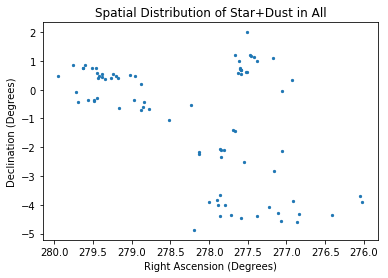

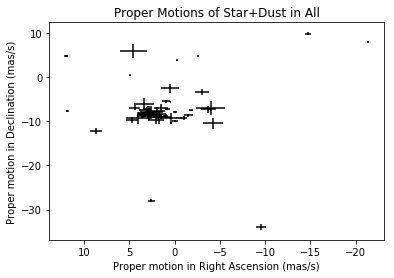

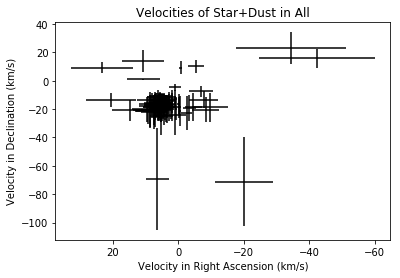

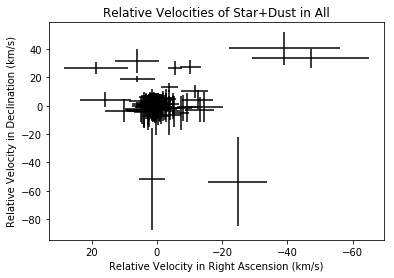

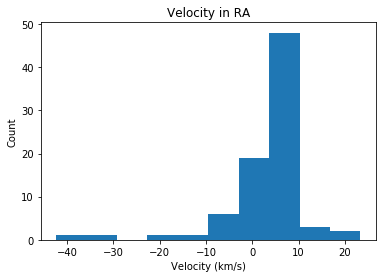

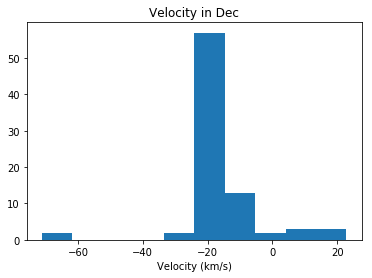

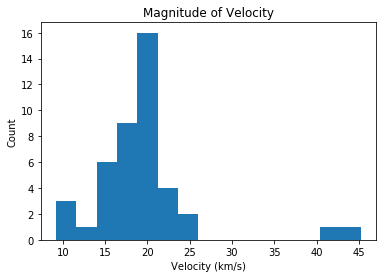

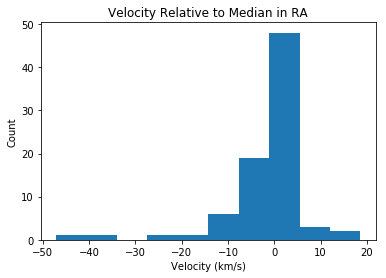

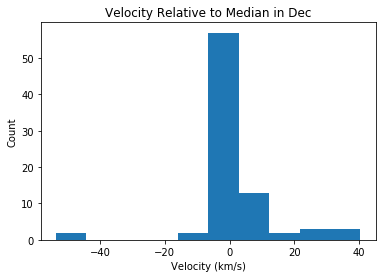

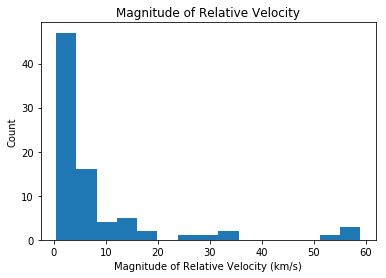

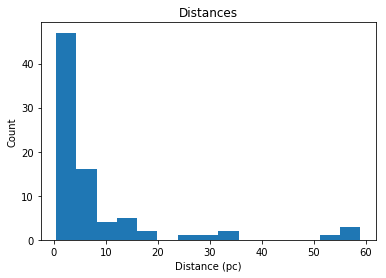

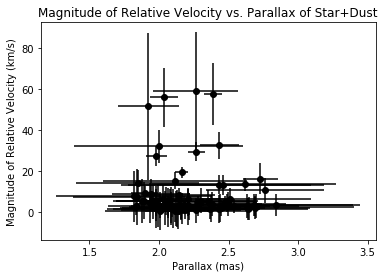

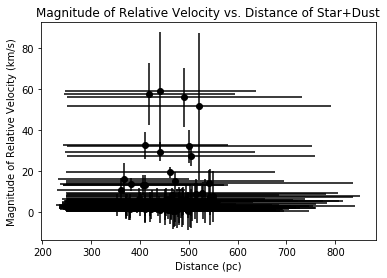

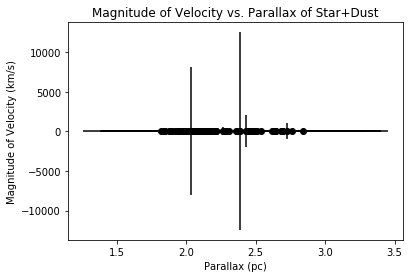

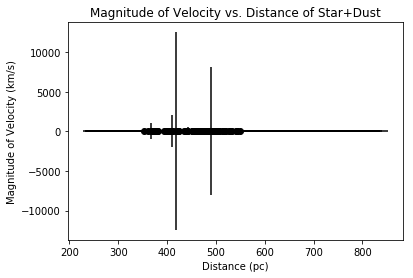

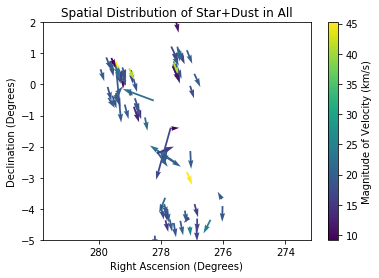

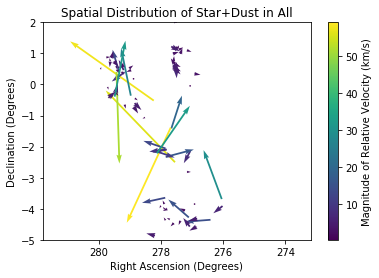

In [14]:
#ALL SD
SD_ALL = CalculateProperties('All','Star+Dust',SD_match,Gvalues,distance_range=[350.,550.])

0
31144
COMPARISON OF FLUXES AND ERRORS CALCULATED BY DIFFERENT METHODS
[ 0.14112222  0.73486519  1.96546565  8.77583424 15.35676678 15.28958157]
[ 0.14112228  0.7348652   1.9654657   8.77583    15.35676    15.289588  ]
[0.00485982 0.0041373  0.03070595 0.21269037 0.44478682 0.29860518]
[0.00485982 0.00413733 0.03070604 0.2101538  0.2101538  0.2101538 ]
Signal to Noise
[ 29.03858292 177.61937706  64.00928067  41.26107949  34.52612842
  51.20333653]
[ 29.038599 177.6184    64.009094  41.759083  73.073906  72.75428 ]
29.038599 177.61838 64.009094
****************************************************************
The c2d index is 2
RA:  276.9277545671889
DEC:  0.34393708826403413
The difference in RA is  0.30300188004730444 arcseconds
The difference in Decliantion is  0.816522249477214 arcseconds
The c2d_ID is  SSTc2d J182742.6+002039
alpha is -0.58
2MASS ID: b'18274265+0020383'
FLUX SIGNAL TO NOISE
[ 29.03859864 177.61838998  64.00909229  41.75908375  73.07390963
  72.75427682   1.        

/Users/roxanapopescu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in log10
/Users/roxanapopescu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:57: RuntimeWarning: divide by zero encountered in log10
/Users/roxanapopescu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:308: RuntimeWarning: divide by zero encountered in double_scalars


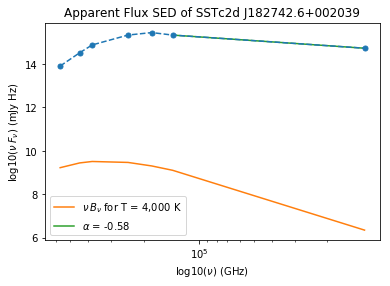

1
59418
2
36252
COMPARISON OF FLUXES AND ERRORS CALCULATED BY DIFFERENT METHODS
[ 1.18996395  3.80684711  8.84483305 33.42629775 52.9541639  63.38630982]
[ 1.1899637  3.8068478  8.84483   33.426296  52.954163  63.38628  ]
[0.01387921 0.00864239 0.05487237 0.71564875 1.58395016 1.17843946]
[0.01387927 0.00864256 0.05487241 0.7080954  0.7080954  0.7080954 ]
Signal to Noise
[ 85.73714753 440.48563599 161.18919667  46.70768716  33.43171084
  53.7883465 ]
[ 85.73677  440.47702  161.18901   47.205925  74.78394   89.51659 ]
85.73677 440.47702 161.18901
****************************************************************
The c2d index is 54
RA:  277.1684377443844
DEC:  1.1036117893301272
The difference in RA is  0.4317997837688381 arcseconds
The difference in Decliantion is  1.443998411542502 arcseconds
The c2d_ID is  SSTc2d J182840.4+010614
alpha is -0.62
2MASS ID: b'18284042+0106131'
FLUX SIGNAL TO NOISE
[ 85.73676808 440.4770228  161.18900553  47.2059239   74.78394114
  89.51658575   1.        

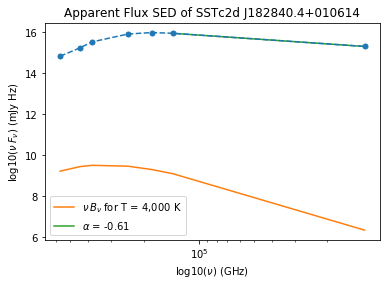

3
35969
COMPARISON OF FLUXES AND ERRORS CALCULATED BY DIFFERENT METHODS
[3.53470000e+06 8.86260589e-02 2.62030000e+06 2.08203632e+00
 3.50832577e+00 3.65759336e+00]
[       nan 0.08862604        nan 2.08203721 3.50832653 3.65759182]
[0.         0.00051566 0.         0.0701918  0.1283109  0.1198279 ]
[       nan 0.00051566        nan 0.06903458 0.06903458 0.06903458]
Signal to Noise
[         inf 171.86952918          inf  29.66210337  27.34238259
  30.52372059]
[         nan 171.86841192          nan  30.15933926  50.81984583
  52.98202741]
-- 171.86841 --
****************************************************************
The c2d index is 126
RA:  277.37758995268143
DEC:  0.984710952782651
The difference in RA is  0.2104296532479566 arcseconds
The difference in Decliantion is  0.2777299824566981 arcseconds
The c2d_ID is  SSTc2d J182930.6+005905
alpha is -1.36
2MASS ID: b'18293061+0059051'
FLUX SIGNAL TO NOISE
[         nan 171.86841192          nan  30.15933926  50.81984583
  52.98202741

/Users/roxanapopescu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:99: UserWarning: Warning: converting a masked element to nan.
/Users/roxanapopescu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:100: UserWarning: Warning: converting a masked element to nan.
/Users/roxanapopescu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:107: RuntimeWarning: divide by zero encountered in true_divide
/Users/roxanapopescu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:221: UserWarning: Warning: converting a masked element to nan.
/Users/roxanapopescu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:259: RuntimeWarning: invalid value encountered in greater_equal
/Users/roxanapopescu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:260: RuntimeWarning: invalid value encountered in greater_equal
/Users/roxanapopescu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:261: RuntimeWarning: invalid value encountered in grea

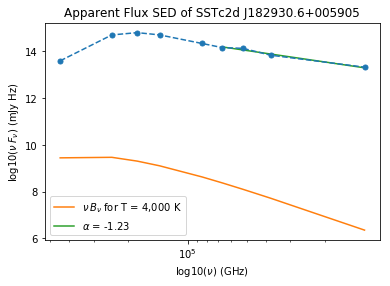

4
35960
5
36072
COMPARISON OF FLUXES AND ERRORS CALCULATED BY DIFFERENT METHODS
[0.00893531 0.03843301 0.11480383 0.86315377 1.05949726 3.492977  ]
[0.00893532 0.03843302 0.11480384 0.8631534  1.0594977  3.4929771 ]
[0.00213779 0.00026679 0.00371427 0.06003002 0.09369001 0.        ]
[0.0021378  0.00026679 0.00371426 0.05803453 0.05803453 0.05803453]
Signal to Noise
[  4.17968776 144.0549495   30.90887956  14.37870145  11.30854088
          inf]
[  4.179687 144.05563   30.908928  14.8731    18.256332  60.18791 ]
4.179687 144.05563 30.908928
****************************************************************
The c2d index is 171
RA:  277.4643984496426
DEC:  1.1590586258570095
The difference in RA is  0.2579387134346689 arcseconds
The difference in Decliantion is  0.2673869147655772 arcseconds
The c2d_ID is  SSTc2d J182951.4+010933
alpha is -1.53
2MASS ID: b'18295145+0109327'
FLUX SIGNAL TO NOISE
[  4.17968696 144.05563475  30.90892781  14.87310006  18.2563326
  60.18790943  19.51807229  18.

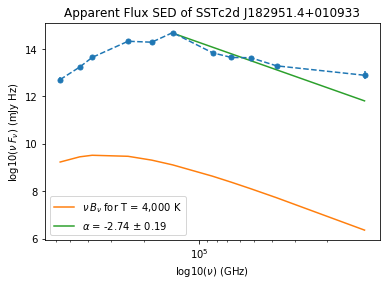

6
36048
COMPARISON OF FLUXES AND ERRORS CALCULATED BY DIFFERENT METHODS
[0.0140289  0.12087025 0.3536808  1.76395775 2.28823179 2.12420164]
[0.0140289  0.12087023 0.3536808  1.7639569  2.2882328  2.124201  ]
[0.00357742 0.00035558 0.00264432 0.06788495 0.07714327 0.11449754]
[0.00357742 0.00035558 0.00264431 0.06661124 0.06661124 0.06661124]
Signal to Noise
[  3.92151193 339.92253061 133.75120295  25.98451691  29.66210337
  18.55237829]
[  3.9215128 339.92673   133.75177    26.48137    34.352055   31.88953  ]
3.9215126 339.92673 133.75177
****************************************************************
The c2d index is 175
RA:  277.4731424679055
DEC:  1.2180645672493626
The difference in RA is  0.002275540191476466 arcseconds
The difference in Decliantion is  0.14123790229438882 arcseconds
The c2d_ID is  SSTc2d J182953.6+011305
alpha is -1.61
2MASS ID: b'18295354+0113051'
FLUX SIGNAL TO NOISE
[  3.9215128  339.9267126  133.75176553  26.48137104  34.35205347
  31.88952989  20.12779553  

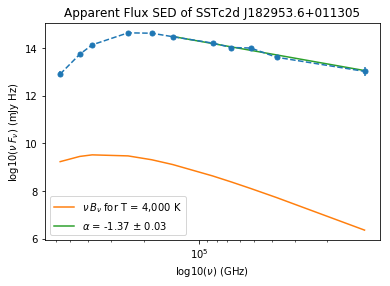

7
27240
COMPARISON OF FLUXES AND ERRORS CALCULATED BY DIFFERENT METHODS
[0.044731   0.31255211 0.95797248 5.01289365 6.06317159 5.56154904]
[0.04473098 0.31255198 0.9579727  5.0128927  6.063172   5.5615506 ]
[0.00290037 0.00120831 0.006151   0.13095867 0.20440801 0.15055055]
[0.00290037 0.00120833 0.00615104 0.12927726 0.12927726 0.12927726]
Signal to Noise
[ 15.4225038  258.66814652 155.74260488  38.27844089  29.66210337
  36.94140636]
[ 15.422507 258.6651   155.74158   38.77629   46.900528  43.020332]
15.422507 258.6651 155.74158
****************************************************************
The c2d index is 191
RA:  277.5054412557777
DEC:  1.9918776456776908
The difference in RA is  0.011720799716385955 arcseconds
The difference in Decliantion is  0.18487556031345775 arcseconds
The c2d_ID is  SSTc2d J183001.3+015931
alpha is -1.66
2MASS ID: b'18300130+0159309'
FLUX SIGNAL TO NOISE
[ 15.42250723 258.66510666 155.74158064  38.77629181  46.90052918
  43.02033208   1.           1.    

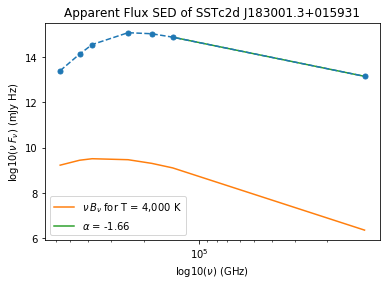

8
32426
COMPARISON OF FLUXES AND ERRORS CALCULATED BY DIFFERENT METHODS
[0.01719435 0.13687595 0.46375031 4.52572818 6.19869012 6.28052226]
[0.01719433 0.13687602 0.4637505  4.52573    6.198692   6.2805195 ]
[0.00291128 0.00040647 0.00568164 0.1139565  0.15608119 0.14629216]
[0.00291128 0.00040648 0.00568166 0.11254549 0.11254549 0.11254549]
Signal to Noise
[  5.90611038 336.74311624  81.62268446  39.71452329  39.71452329
  42.93136635]
[  5.906111 336.73798   81.62232   40.212452  55.077213  55.804276]
5.906111 336.73795 81.62232
****************************************************************
The c2d index is 193
RA:  277.5065103096611
DEC:  0.6260335108364313
The difference in RA is  0.14187477995619702 arcseconds
The difference in Decliantion is  0.26564098884733767 arcseconds
The c2d_ID is  SSTc2d J183001.6+003734
alpha is -1.82
2MASS ID: b'18300155+0037338'
FLUX SIGNAL TO NOISE
[  5.90611063 336.73796086  81.62232186  40.21245207  55.07721216
  55.80427497   1.          18.415841

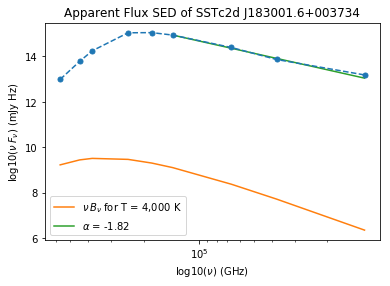

9
32502
10
32498
COMPARISON OF FLUXES AND ERRORS CALCULATED BY DIFFERENT METHODS
[0.01679582 0.08734702 0.26331142 1.61468679 2.07730285 1.9036871 ]
[0.01679581 0.08734701 0.2633114  1.6146868  2.0773034  1.9036863 ]
[0.00223183 0.00034599 0.00300325 0.07921526 0.09189825 0.1044602 ]
[0.00223183 0.00034599 0.00300324 0.07733344 0.07733344 0.07733344]
Signal to Noise
[  7.52557518 252.45600707  87.67541074  20.38353296  22.60437838
  18.22404173]
[  7.525576 252.45474   87.67564   20.879543  26.861647  24.6166  ]
7.5255756 252.45473 87.67564
****************************************************************
The c2d index is 217
RA:  277.5826238032912
DEC:  0.6741813016664934
The difference in RA is  0.18001184839704365 arcseconds
The difference in Decliantion is  0.2728740006240571 arcseconds
The c2d_ID is  SSTc2d J183019.8+004027
alpha is -0.95
2MASS ID: b'18301981+0040271'
FLUX SIGNAL TO NOISE
[  7.52557612 252.4547425   87.67563342  20.87954373  26.86164656
  24.6166005    1.          

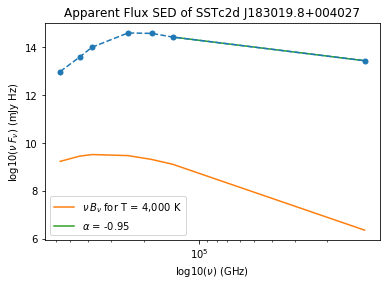

11
32542
COMPARISON OF FLUXES AND ERRORS CALCULATED BY DIFFERENT METHODS
[ 0.10787892  0.86507898  2.62540066 24.282211   53.54263834 66.49599477]
[ 0.10787888  0.86507875  2.6254003  24.282206   53.542664   66.49598   ]
[3.39041672e-03 1.05497329e-03 1.52383007e-02 5.65605362e-01
 1.55078605e+00 1.42366276e+00]
[0.00339042 0.00105498 0.0152384  0.55911845 0.55911845 0.55911845]
Signal to Noise
[ 31.81878004 820.00084079 172.28959572  42.93136635  34.52612842
  46.70768716]
[ 31.818777 819.9982   172.28847   43.429447  95.76265  118.93004 ]
31.818777 819.9982 172.28847
****************************************************************
The c2d index is 219
RA:  277.5831157195666
DEC:  0.69782558336132
The difference in RA is  0.4774304398097229 arcseconds
The difference in Decliantion is  1.093379899248026 arcseconds
The c2d_ID is  SSTc2d J183019.9+004153
alpha is -1.37
2MASS ID: b'18301993+0041522'
FLUX SIGNAL TO NOISE
[ 31.8187775  819.99822294 172.28847462  43.4294479   95.76264851
 11

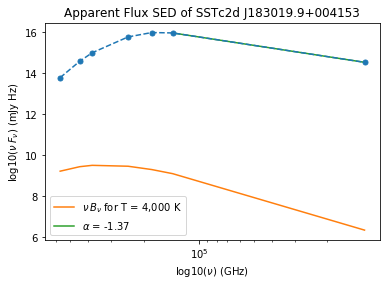

12
32576
COMPARISON OF FLUXES AND ERRORS CALCULATED BY DIFFERENT METHODS
[ 0.04212202  0.2969496   0.86851322  6.99662014 13.52383847 13.88018971]
[ 0.04212202  0.29694948  0.86851305  6.996617   13.523838   13.880193  ]
[0.00157576 0.00121947 0.0104448  0.17617283 0.39169867 0.29717142]
[0.00157576 0.00121946 0.01044484 0.17399131 0.17399131 0.17399131]
Signal to Noise
[ 26.73131504 243.50802152  83.15267217  39.71452329  34.52612842
  46.70768716]
[ 26.73129  243.50934   83.15237   40.212452  77.72709   79.77521 ]
26.73129 243.50934 83.15237
****************************************************************
The c2d index is 223
RA:  277.5937949799801
DEC:  0.554748501394243
The difference in RA is  0.37972792838445457 arcseconds
The difference in Decliantion is  0.1072850192748831 arcseconds
The c2d_ID is  SSTc2d J183022.5+003317
alpha is -1.15
2MASS ID: b'18302250+0033170'
FLUX SIGNAL TO NOISE
[ 26.73129127 243.50933278  83.15236691  40.21245047  77.7270901
  79.77520801   1.         

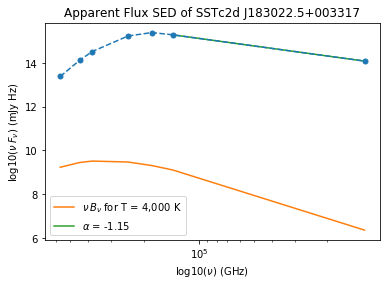

13
35649
COMPARISON OF FLUXES AND ERRORS CALCULATED BY DIFFERENT METHODS
[ 0.17403514  0.74492548  2.12371302  9.04666292 17.18304259 18.0299931 ]
[ 0.17403522  0.7449255   2.123713    9.046665   17.183043   18.03      ]
[0.00802726 0.01409919 0.0343372  0.21925415 0.51397437 0.38601768]
[0.00802725 0.0140992  0.03433727 0.21663944 0.21663944 0.21663944]
Signal to Noise
[21.68052665 52.83463962 61.84875035 41.26107949 33.43171084 46.70768716]
[21.680548 52.83459  61.848625 41.759087 79.316315 83.225845]
21.680548 52.83459 61.848625
****************************************************************
The c2d index is 224
RA:  277.59485632008517
DEC:  0.7436656015324985
The difference in RA is  0.3978723066211387 arcseconds
The difference in Decliantion is  1.0943944830054342 arcseconds
The c2d_ID is  SSTc2d J183022.7+004438
alpha is -1.07
2MASS ID: b'18302275+0044373'
FLUX SIGNAL TO NOISE
[21.68054839 52.83459242 61.84862554 41.75908604 79.31631558 83.22584445
  1.          1.          1.  

/Users/roxanapopescu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:308: RuntimeWarning: invalid value encountered in double_scalars


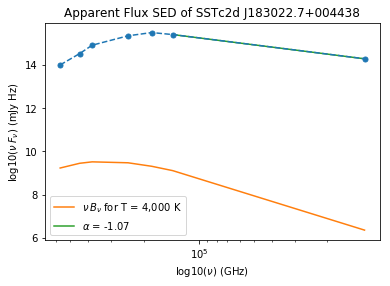

14
32544
COMPARISON OF FLUXES AND ERRORS CALCULATED BY DIFFERENT METHODS
[0.01769385 0.16429199 0.51346885 2.02343029 4.93287225 6.45647765]
[0.01769384 0.16429195 0.5134686  2.0234308  4.932871   6.4564776 ]
[0.00146438 0.00327667 0.03140558 0.07014338 0.1475507  0.15039069]
[0.00146438 0.00327667 0.03140556 0.068955   0.068955   0.068955  ]
Signal to Noise
[12.0828561  50.13991318 16.34960761 28.84706117 33.43171084 42.93136635]
[12.08285 50.13994 16.34961 29.34422 71.53753 93.6332 ]
12.08285 50.13994 16.349607
****************************************************************
The c2d index is 228
RA:  277.5970574888583
DEC:  0.7079368243552621
The difference in RA is  0.439879889927397 arcseconds
The difference in Decliantion is  1.1612723210565168 arcseconds
The c2d_ID is  SSTc2d J183023.3+004230
alpha is -0.66
2MASS ID: b'18302328+0042286'
FLUX SIGNAL TO NOISE
[12.0828505  50.13993949 16.34960855 29.34422015 71.53753264 93.63319915
  1.          1.          1.          1.         10

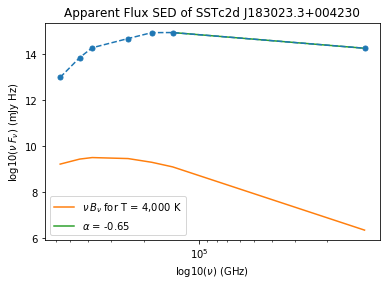

15
35717
COMPARISON OF FLUXES AND ERRORS CALCULATED BY DIFFERENT METHODS
[0.0293261  0.16258595 0.47313301 2.93014031 5.17487527 4.91129114]
[0.02932608 0.16258596 0.47313312 2.9301398  5.1748753  4.911289  ]
[0.0022272  0.00118207 0.0104613  0.10716478 0.20906071 0.17025274]
[0.0022272  0.00118208 0.0104613  0.10525159 0.10525159 0.10525159]
Signal to Noise
[ 13.16723432 137.54297134  45.22697232  27.34238259  24.75297861
  28.84706117]
[ 13.16724  137.54236   45.226997  27.839388  49.166718  46.662376]
13.16724 137.54236 45.226994
****************************************************************
The c2d index is 235
RA:  277.6183538088804
DEC:  0.9869077752440374
The difference in RA is  0.3096319693440819 arcseconds
The difference in Decliantion is  0.33308912146559067 arcseconds
The c2d_ID is  SSTc2d J183028.4+005913
alpha is -1.99
2MASS ID: b'18302839+0059130'
FLUX SIGNAL TO NOISE
[ 13.16723996 137.54235673  45.22699603  27.83938787  49.16671911
  46.66237642   1.          20.08196

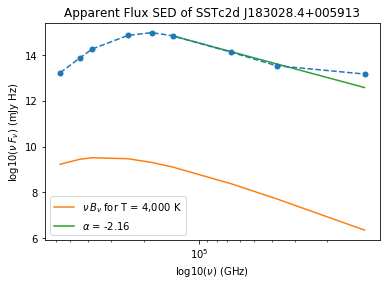

16
32237
COMPARISON OF FLUXES AND ERRORS CALCULATED BY DIFFERENT METHODS
[ 0.45366548  1.70479018  4.25401573 19.09362359 29.4238786  27.39023446]
[ 0.45366547  1.7047902   4.254018   19.093628   29.423866   27.390242  ]
[0.00530347 0.00531763 0.05954126 0.44474763 0.82434814 0.58641813]
[0.00530348 0.00531768 0.05954148 0.43964702 0.43964702 0.43964702]
Signal to Noise
[ 85.54129994 320.59190823  71.44652209  42.93136635  35.69351019
  46.70768716]
[ 85.54108 320.58917  71.4463   43.42945  66.92612  62.30053]
85.541084 320.5892 71.4463
****************************************************************
The c2d index is 238
RA:  277.62442731497123
DEC:  0.5833703048274473
The difference in RA is  0.295973896322721 arcseconds
The difference in Decliantion is  0.6170226211897667 arcseconds
The c2d_ID is  SSTc2d J183029.8+003501
alpha is -1.02
2MASS ID: b'18302986+0035004'
FLUX SIGNAL TO NOISE
[ 85.54108028 320.58917786  71.44629568  43.42944933  66.92611346
  62.30052848   1.           1.  

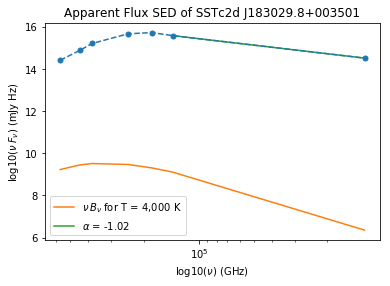

17
36074
COMPARISON OF FLUXES AND ERRORS CALCULATED BY DIFFERENT METHODS
[0.06554326 0.09131708 0.31473584 2.51703024 3.30445682 3.36043436]
[0.06554328 0.09131704 0.31473577 2.5170298  3.3044562  3.3604336 ]
[0.02378654 0.0004433  0.00336966 0.08965404 0.13983612 0.10689756]
[0.02378655 0.0004433  0.00336966 0.08809426 0.08809426 0.08809426]
Signal to Noise
[  2.7554767  205.99189547  93.40289503  28.07492286  23.63092404
  31.43602561]
[  2.755477 205.99413   93.40286   28.572008  37.51046   38.145885]
2.7554767 205.99413 93.40286
****************************************************************
The c2d index is 251
RA:  277.67157303856914
DEC:  1.2209640786578548
The difference in RA is  0.3432188487977328 arcseconds
The difference in Decliantion is  0.294916831722869 arcseconds
The c2d_ID is  SSTc2d J183041.2+011316
alpha is -0.99
2MASS ID: b'18304116+0113156'
FLUX SIGNAL TO NOISE
[  2.75547687 205.99412867  93.40286255  28.57200745  37.51046156
  38.14588714  20.06493506  19.857142

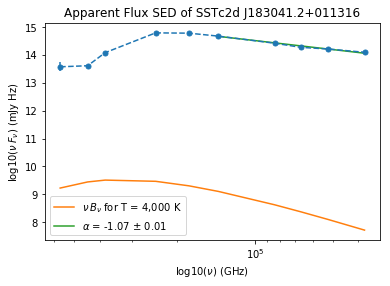

18
26154
COMPARISON OF FLUXES AND ERRORS CALCULATED BY DIFFERENT METHODS
[ 6.64235695 16.15775665 32.988289   79.30273536 85.56577312 67.29699663]
[ 6.642357 16.157764 32.988304 79.30272  85.565735 67.29701 ]
[0.01654134 0.0092494  0.03293084 1.99681952 1.91247535 1.18803844]
[0.01654153 0.00924957 0.0329305  1.9720936  1.9720936  1.9720936 ]
Signal to Noise
[ 401.5609569  1746.89868581 1001.74444859   39.71452329   44.74085019
   56.64547091]
[ 401.5564   1746.8665   1001.7552     40.212452   43.38827    34.124653]
401.55637 1746.8663 1001.7552
****************************************************************
The GB index 891
RA:  276.0200107684489
DEC:  -3.9138430944305855
The difference in RA is  0.763 arcseconds
The difference in Dec is  0.167 arcseconds
The Gould_Belt_ID is  SSTGBS J182404.8-035450
alpha is -1.37
2MASS ID: b'18240480-0354497'
FLUX SIGNAL TO NOISE
[4.01556391e+02 1.74686640e+03 1.00175520e+03 4.02124523e+01
 4.33882731e+01 3.41246546e+01 1.00000000e+00 1.00000000e+0

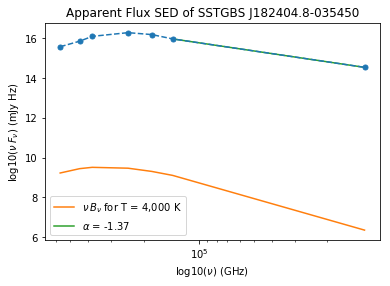

19
26393
COMPARISON OF FLUXES AND ERRORS CALCULATED BY DIFFERENT METHODS
[ 25.57147554  53.12625024  97.76205505 180.67089206 162.59227159
 134.77072564]
[ 25.571468  53.126225  97.762054 180.67093  162.59227  134.7707  ]
[0.03190106 0.01058268 0.13863771 4.89074212 3.94057241 3.2662918 ]
[0.03190161 0.01058051 0.13863826 4.825718   4.825718   4.825718  ]
Signal to Noise
[ 801.58703799 5020.1126454   705.16206396   36.94140636   41.26107949
   41.26107949]
[ 801.5729   5021.1426    705.1593     37.439182   33.692867   27.927597]
801.57294 5021.1426 705.1593
****************************************************************
The GB index 893
RA:  276.0454877517486
DEC:  -3.688459975743996
The difference in RA is  0.533 arcseconds
The difference in Dec is  0.011 arcseconds
The Gould_Belt_ID is  SSTGBS J182410.9-034118
alpha is -2.25
2MASS ID: b'18241092-0341185'
FLUX SIGNAL TO NOISE
[8.01572900e+02 5.02114250e+03 7.05159282e+02 3.74391814e+01
 3.36928665e+01 2.79275971e+01 1.00000000e+00 1.

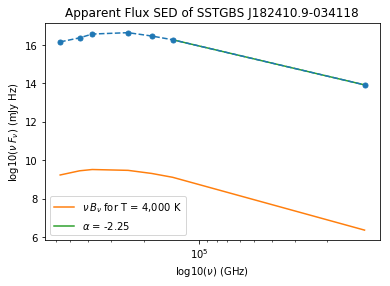

20
10039
COMPARISON OF FLUXES AND ERRORS CALCULATED BY DIFFERENT METHODS
[0.01768571 0.05717253 0.16994149 0.81299587 1.25054683 1.06462275]
[0.01768572 0.05717254 0.16994144 0.81299603 1.2505472  1.0646232 ]
[0.0017242  0.00025245 0.00567369 0.05734292 0.07593089 0.08246262]
[0.0017242  0.00025245 0.00567367 0.05541098 0.05541098 0.05541098]
Signal to Noise
[ 10.25735405 226.47429015  29.95257646  14.17778996  16.46953929
  12.91036704]
[ 10.257354  226.4735     29.952621   14.6721115  22.568583   19.213219 ]
10.257354 226.4735 29.952623
****************************************************************
The GB index 989
RA:  276.40700484435126
DEC:  -4.355785103218235
The difference in RA is  0.157 arcseconds
The difference in Dec is  0.159 arcseconds
The Gould_Belt_ID is  SSTGBS J182537.7-042121
alpha is -0.98
2MASS ID: b'18253769-0421209'
FLUX SIGNAL TO NOISE
[ 10.25735413 226.47350049  29.95262228  14.67211133  22.56858168
  19.21321885   1.           1.           1.           1.
   

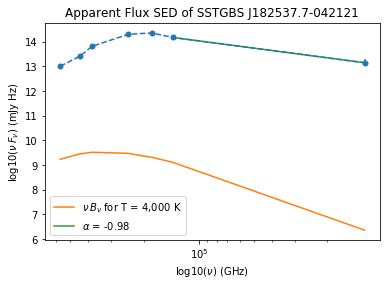

21
11550
COMPARISON OF FLUXES AND ERRORS CALCULATED BY DIFFERENT METHODS
[0.09129557 0.36870512 1.15366787 6.15585413 9.41672993 8.51913516]
[0.09129553 0.36870506 1.1536676  6.1558557  9.41673    8.519137  ]
[0.01680319 0.00152016 0.02792491 0.23101945 0.38945581 0.42617716]
[0.01680318 0.00152017 0.02792488 0.2267901  0.2267901  0.2267901 ]
Signal to Noise
[  5.43322963 242.54347476  41.31322031  26.64647577  24.1792
  19.98965675]
[  5.433231 242.54259   41.31325   27.143406  41.521786  37.563972]
5.433231 242.54259 41.31325
****************************************************************
The GB index 1185
RA:  276.8365334025829
DEC:  -4.316848306380546
The difference in RA is  0.066 arcseconds
The difference in Dec is  0.15 arcseconds
The Gould_Belt_ID is  SSTGBS J182720.8-041901
alpha is -1.32
2MASS ID: b'18272077-0419005'
FLUX SIGNAL TO NOISE
[  5.43323103 242.54258661  41.31325016  27.14340549  41.52178562
  37.56397378  15.42424242   1.          15.42424242   1.
   7.75193798]


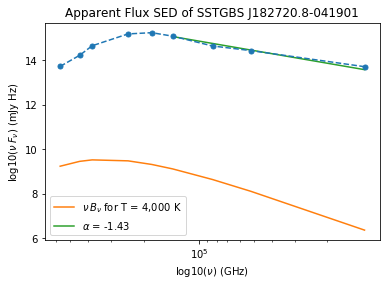

22
10931
COMPARISON OF FLUXES AND ERRORS CALCULATED BY DIFFERENT METHODS
[100.95787913 195.17480632 345.18963201 653.56404537 764.71567389
 934.10492387]
[100.95788 195.17488 345.18954 653.56415 764.7155  934.10474]
[ 1.31620853  0.57349963  2.53988957 12.76409097 27.23838914 22.63888719]
[ 1.3162127  0.5735052  2.5399084 12.641051  12.641051  12.641051 ]
Signal to Noise
[ 76.70355943 340.32246187 135.90733883  51.20333653  28.07492286
  41.26107949]
[ 76.703316 340.31927  135.9063    51.701725  60.494614  73.89455 ]
76.70332 340.31927 135.9063
****************************************************************
The GB index 1213
RA:  276.8586359925115
DEC:  -4.5798945359883545
The difference in RA is  0.422 arcseconds
The difference in Dec is  0.457 arcseconds
The Gould_Belt_ID is  SSTGBS J182726.0-043447
alpha is -0.53
2MASS ID: b'18272608-0434473'
FLUX SIGNAL TO NOISE
[ 76.70331826 340.31927387 135.90629624  51.70172423  60.49461373
  73.89454522   1.           1.           1.          

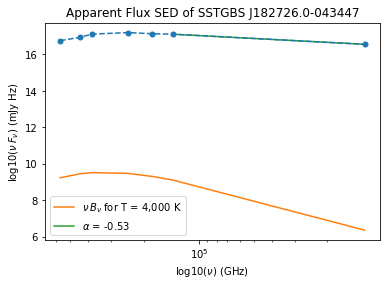

23
12391
COMPARISON OF FLUXES AND ERRORS CALCULATED BY DIFFERENT METHODS
[ 0.01994129  0.17699291  0.6081121   6.17288838 12.92706881 14.15128074]
[ 0.0199413   0.17699291  0.608112    6.1728916  12.927069   14.151287  ]
[0.00374589 0.00094486 0.00990981 0.16709944 0.33771148 0.35632508]
[0.00374589 0.00094487 0.00990979 0.16487785 0.16487785 0.16487785]
Signal to Noise
[  5.32351435 187.32097909  61.36464549  36.94140636  38.27844089
  39.71452329]
[  5.3235135 187.3201     61.364788   37.439182   78.403915   85.82892  ]
5.3235135 187.32008 61.364784
****************************************************************
The GB index 1280
RA:  276.9202852655942
DEC:  -3.8498061108230344
The difference in RA is  0.032 arcseconds
The difference in Dec is  0.046 arcseconds
The Gould_Belt_ID is  SSTGBS J182740.9-035059
alpha is -0.81
2MASS ID: b'18274086-0350593'
FLUX SIGNAL TO NOISE
[  5.32351347 187.32009382  61.36478659  37.4391814   78.40391513
  85.82891729  18.43065693  17.6744186   18.430

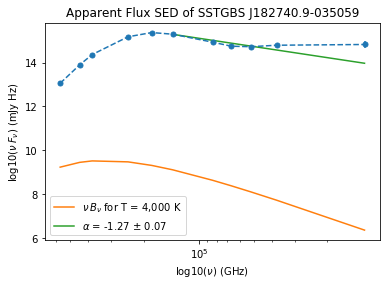

24
5732
COMPARISON OF FLUXES AND ERRORS CALCULATED BY DIFFERENT METHODS
[0.01214784 0.03351984 0.11778148 1.45240717 2.62240594 2.64238165]
[0.01214783 0.03351985 0.11778153 1.4524069  2.6224065  2.6423821 ]
[0.00286355 0.00019079 0.00365166 0.0656509  0.1034313  0.1168969 ]
[0.00286355 0.00019079 0.00365166 0.06421038 0.06421038 0.06421038]
Signal to Noise
[  4.24222851 175.69238227  32.25420228  22.12318809  25.35408591
  22.60437838]
[  4.2422276 175.69304    32.25422    22.619503   40.84085    41.151947 ]
4.2422276 175.69304 32.25422
****************************************************************
The GB index 1401
RA:  277.0572834711105
DEC:  -2.142441674558036
The difference in RA is  0.039 arcseconds
The difference in Dec is  0.004 arcseconds
The Gould_Belt_ID is  SSTGBS J182813.7-020833
alpha is -1.16
2MASS ID: b'18281374-0208327'
FLUX SIGNAL TO NOISE
[  4.24222779 175.69303586  32.25421842  22.61950384  40.84085127
  41.15194837  19.61538462  20.61349693  19.61538462  19.40144

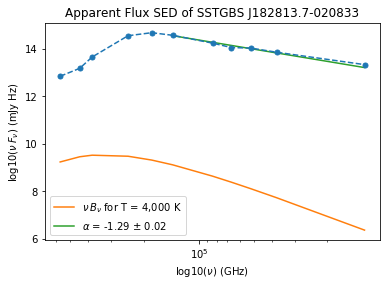

25
9989
COMPARISON OF FLUXES AND ERRORS CALCULATED BY DIFFERENT METHODS
[19.18311179 33.40060189 55.13387169 90.96791373 72.82827147 53.90084982]
[19.18312  33.400593 55.133896 90.96796  72.8283   53.900837]
[0.0157538  0.00716301 0.06204412 1.86206151 1.62778023 1.2555121 ]
[0.01575487 0.00716315 0.06204276 1.8432609  1.8432609  1.8432609 ]
Signal to Noise
[1217.68148065 4662.92826859  888.6236616    48.85333449   44.74085019
   42.93136635]
[1217.5996   4662.8364    888.6435     49.351646   39.51058    29.24211 ]
1217.5996 4662.8364 888.64355
****************************************************************
The GB index 1414
RA:  277.074417519472
DEC:  -4.574346488967392
The difference in RA is  0.113 arcseconds
The difference in Dec is  0.101 arcseconds
The Gould_Belt_ID is  SSTGBS J182817.9-043428
alpha is -2.31
2MASS ID: b'18281786-0434275'
FLUX SIGNAL TO NOISE
[1.21759963e+03 4.66283663e+03 8.88643485e+02 4.93516449e+01
 3.95105767e+01 2.92421097e+01 1.00000000e+00 1.00000000e+00


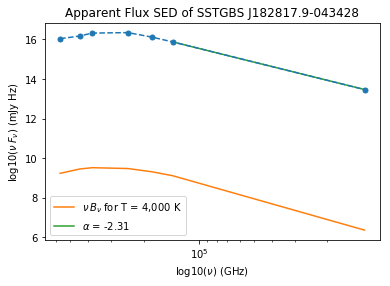

26
10829
COMPARISON OF FLUXES AND ERRORS CALCULATED BY DIFFERENT METHODS
[1.90099742e-02 1.30176859e-01 6.23330251e-01 3.69903244e+01
 1.34865191e+02 2.14188264e+02]
[1.9009974e-02 1.3017692e-01 6.2333012e-01 3.6990307e+01 1.3486516e+02
 2.1418831e+02]
[6.27766360e-03 1.69874073e-03 2.89303689e-02 7.91953673e-01
 3.14141390e+00 4.38431206e+00]
[0.00627766 0.00169875 0.02893038 0.7835946  0.7835946  0.7835946 ]
Signal to Noise
[ 3.02819256 76.63138752 21.54587983 46.70768716 42.93136635 48.85333449]
[  3.0281923  76.63108    21.54587    47.205925  172.11089   273.3407   ]
3.0281923 76.63109 21.545872
****************************************************************
The GB index 1437
RA:  277.1055878296834
DEC:  -4.280083195775563
The difference in RA is  0.051 arcseconds
The difference in Dec is  0.03 arcseconds
The Gould_Belt_ID is  SSTGBS J182825.3-041648
alpha is -1.99
2MASS ID: b'18282533-0416483'
FLUX SIGNAL TO NOISE
[  3.02819226  76.63108403  21.54587034  47.20592314 172.11088062


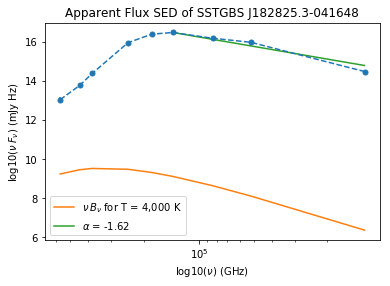

27
2374
COMPARISON OF FLUXES AND ERRORS CALCULATED BY DIFFERENT METHODS
[ 0.07398314  0.5263543   1.53641655 12.13636156 19.52990101 18.79297739]
[ 0.07398315  0.52635443  1.5364165  12.136367   19.52991    18.792969  ]
[4.56841894e-03 6.22004300e-04 9.18010166e-03 2.94135823e-01
 5.65655691e-01 6.87320402e-01]
[0.00456842 0.00062198 0.00918017 0.2906282  0.2906282  0.2906282 ]
Signal to Noise
[ 16.19447296 846.22292362 167.36378349  41.26107949  34.52612842
  27.34238259]
[ 16.194483 846.25824  167.36247   41.759083  67.19895   64.66327 ]
16.194483 846.2583 167.36247
****************************************************************
The GB index 1470
RA:  277.1662064999018
DEC:  -2.8153965444062554
The difference in RA is  0.041 arcseconds
The difference in Dec is  0.051 arcseconds
The Gould_Belt_ID is  SSTGBS J182839.9-024855
alpha is -1.71
2MASS ID: b'18283988-0248553'
FLUX SIGNAL TO NOISE
[ 16.19448352 846.25826322 167.36247608  41.75908278  67.19894863
  64.66326766  12.3986095   14

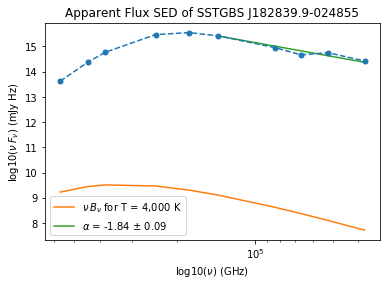

28
10935
COMPARISON OF FLUXES AND ERRORS CALCULATED BY DIFFERENT METHODS
[ 0.9382867   3.47331821  8.92970226 28.0342075  48.78651934 60.53349847]
[ 0.93828684  3.4733167   8.929702   28.034218   48.78653    60.5335    ]
[0.0324002  0.02411438 0.17152025 0.60020543 1.13638404 1.29600719]
[0.03240016 0.02411422 0.17151982 0.59387076 0.59387076 0.59387076]
Signal to Noise
[ 28.95928733 144.03516404  52.06208877  46.70768716  42.93136635
  46.70768716]
[ 28.959326 144.03606   52.062218  47.205925  82.15008  101.93043 ]
28.959326 144.03606 52.062218
****************************************************************
The GB index 1506
RA:  277.2300609043041
DEC:  -4.061409873104111
The difference in RA is  0.091 arcseconds
The difference in Dec is  0.207 arcseconds
The Gould_Belt_ID is  SSTGBS J182855.2-040341
alpha is -0.9
2MASS ID: b'18285520-0403410'
FLUX SIGNAL TO NOISE
[ 28.95932647 144.0360618   52.06221658  47.20592386  82.15007862
 101.93042805  20.03636364   1.          20.03636364   

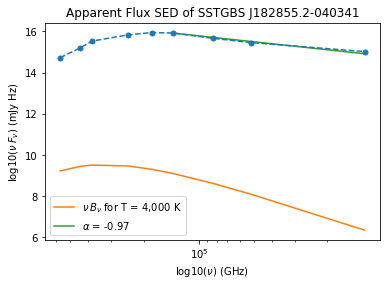

29
10976
COMPARISON OF FLUXES AND ERRORS CALCULATED BY DIFFERENT METHODS
[ 0.82079494  2.36585713  5.68266576 22.64061101 32.59116946 31.82697853]
[ 0.8207946  2.365858   5.682667  22.640621  32.591167  31.826965 ]
[0.03820647 0.04750098 0.30302577 0.57008392 0.72844323 0.77135593]
[0.03820649 0.04750104 0.30302554 0.5630251  0.5630251  0.5630251 ]
Signal to Noise
[21.48313964 49.80648755 18.75307754 39.71452329 44.74085019 41.26107949]
[21.48312  49.806454 18.753096 40.212452 57.885815 56.5285  ]
21.48312 49.806454 18.753096
****************************************************************
The GB index 1627
RA:  277.37861048384514
DEC:  -4.387455560507114
The difference in RA is  0.923 arcseconds
The difference in Dec is  0.019 arcseconds
The Gould_Belt_ID is  SSTGBS J182930.8-042315
alpha is -0.91
2MASS ID: b'18293086-0423146'
FLUX SIGNAL TO NOISE
[21.48312048 49.80645319 18.7530949  40.21245324 57.88581445 56.52850002
  1.          1.          1.          1.         10.7967033 ]
SED 

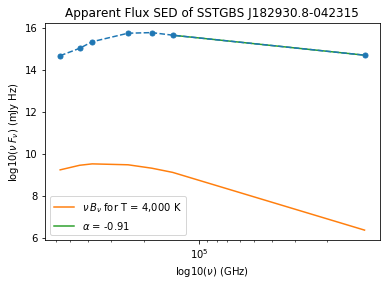

30
3784
COMPARISON OF FLUXES AND ERRORS CALCULATED BY DIFFERENT METHODS
[0.24409607 0.80779777 1.85535625 6.44597173 8.78819754 7.365386  ]
[0.24409601 0.8077974  1.8553557  6.4459715  8.788199   7.3653874 ]
[0.00459911 0.00081149 0.01161991 0.17449178 0.28791371 0.30461661]
[0.00459911 0.00081152 0.01161989 0.17217182 0.17217182 0.17217182]
Signal to Noise
[ 53.07465062 995.4441824  159.67048516  36.94140636  30.52372059
  24.1792    ]
[ 53.07466  995.4117   159.67065   37.43918   51.043194  42.779285]
53.074657 995.4116 159.67065
****************************************************************
The GB index 1764
RA:  277.5502544771099
DEC:  -2.502578917813625
The difference in RA is  0.195 arcseconds
The difference in Dec is  0.144 arcseconds
The Gould_Belt_ID is  SSTGBS J183012.1-023009
alpha is -1.84
2MASS ID: b'18301208-0230093'
FLUX SIGNAL TO NOISE
[5.30746594e+01 9.95411661e+02 1.59670653e+02 3.74391792e+01
 5.10431940e+01 4.27792864e+01 1.65882353e+01 1.45263158e+01
 1.65882353e

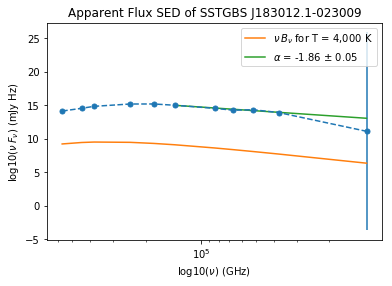

31
4157
COMPARISON OF FLUXES AND ERRORS CALCULATED BY DIFFERENT METHODS
[  5.85414439  16.04336094  34.44493987  95.1673879  108.81780229
  93.58270696]
[  5.8541455  16.043354   34.44494    95.16743   108.817825   93.582726 ]
[0.01354632 0.00706293 0.06425725 2.03751018 2.02307394 2.1798213 ]
[0.01354637 0.00706198 0.06425545 2.0160062  2.0160062  2.0160062 ]
Signal to Noise
[ 432.15744429 2271.4887681   536.04754342   46.70768716   53.7883465
   42.93136635]
[ 432.1562   2271.7932    536.06256    47.205917   53.97693    46.41986 ]
432.1562 2271.7935 536.06256
****************************************************************
The GB index 1799
RA:  277.588495556125
DEC:  -4.4605089120560635
The difference in RA is  0.269 arcseconds
The difference in Dec is  0.801 arcseconds
The Gould_Belt_ID is  SSTGBS J183021.2-042737
alpha is -0.41
2MASS ID: b'18302124-0427375'
FLUX SIGNAL TO NOISE
[4.32156183e+02 2.27179330e+03 5.36062555e+02 4.72059191e+01
 5.39769291e+01 4.64198593e+01 1.00000000e+

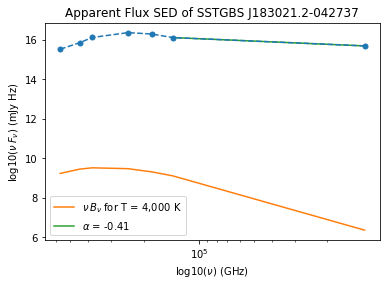

32
47459
COMPARISON OF FLUXES AND ERRORS CALCULATED BY DIFFERENT METHODS
[0.68661359 1.50962088 2.86363212 6.97731278 8.30806455 7.55084721]
[0.68661326 1.5096209  2.8636315  6.977316   8.308061   7.550844  ]
[0.0038785  0.00093238 0.0075112  0.68726421 0.16225631 0.126226  ]
[0.00387851 0.00093243 0.00751113 0.6554872  0.6554872  0.6554872 ]
Signal to Noise
[ 177.03087618 1619.10981687  381.24834545   10.15230043   51.20333653
   59.82006218]
[ 177.03029  1619.0093    381.25186    10.644473   12.674635   11.519439]
177.03029 1619.0093 381.25186
****************************************************************
The GB index 1880
RA:  277.66835048537
DEC:  -1.4180093677877597
The difference in RA is  0.212 arcseconds
The difference in Dec is  0.069 arcseconds
The Gould_Belt_ID is  SSTGBS J183040.4-012505
alpha is -1.93
2MASS ID: b'18304039-0125049'
FLUX SIGNAL TO NOISE
[ 177.03028744 1619.00929858  381.25186869   10.64447348   12.67463484
   11.51943841   13.77880184   13.91304348   13.77

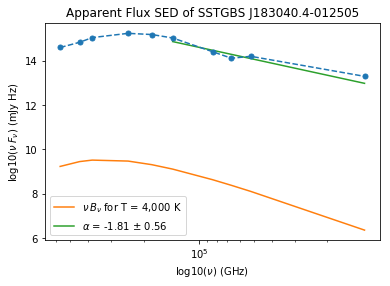

33
47465
COMPARISON OF FLUXES AND ERRORS CALCULATED BY DIFFERENT METHODS
[0.01151949 0.05606533 0.15562822 0.97563713 1.6065716  1.44409409]
[0.01151949 0.05606534 0.15562826 0.9756369  1.6065712  1.4440941 ]
[0.00177301 0.00022803 0.00348789 0.10701347 0.17950502 0.18218653]
[0.00177301 0.00022803 0.00348789 0.10154121 0.10154121 0.10154121]
Signal to Noise
[  6.4971259  245.8632475   44.61954591   9.11695667   8.95000914
   7.92645896]
[  6.4971256 245.86394    44.61954     9.608285   15.821863   14.221753 ]
6.4971256 245.86395 44.61954
****************************************************************
The GB index 1907
RA:  277.68874294609844
DEC:  -1.3897714565944583
The difference in RA is  0.529 arcseconds
The difference in Dec is  0.466 arcseconds
The Gould_Belt_ID is  SSTGBS J183045.3-012323
alpha is -1.39
2MASS ID: b'18304531-0123225'
FLUX SIGNAL TO NOISE
[  6.49712569 245.86393577  44.61954098   9.60828479  15.82186325
  14.22175301   5.61068702   6.8852459    5.61068702  11.23

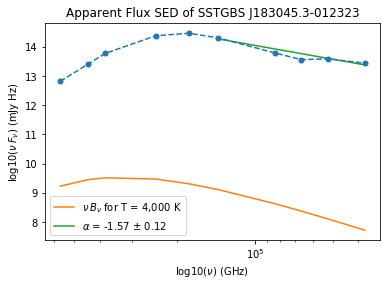

34
4060
COMPARISON OF FLUXES AND ERRORS CALCULATED BY DIFFERENT METHODS
[ 0.16968601  0.80286736  2.19355248 10.43490025 15.00720936 13.31667353]
[ 0.169686   0.802867   2.1935534 10.4349    15.007206  13.316677 ]
[0.00652639 0.00255735 0.01516862 0.25289935 0.30718905 0.26007433]
[0.00652639 0.00255731 0.01516873 0.24988335 0.24988335 0.24988335]
Signal to Noise
[ 25.99998099 313.94490894 144.6112224   41.26107949  48.85333449
  51.20333653]
[ 25.999968 313.95     144.61023   41.759087  60.056847  53.291573]
25.999968 313.95 144.61021
****************************************************************
The GB index 1956
RA:  277.717564748742
DEC:  -4.345782779953684
The difference in RA is  0.06 arcseconds
The difference in Dec is  0.028 arcseconds
The Gould_Belt_ID is  SSTGBS J183052.2-042045
alpha is -1.82
2MASS ID: b'18305221-0420447'
FLUX SIGNAL TO NOISE
[ 25.99996775 313.95000745 144.61022269  41.7590853   60.05684549
  53.29157343   1.           1.           1.           1.
   6.478

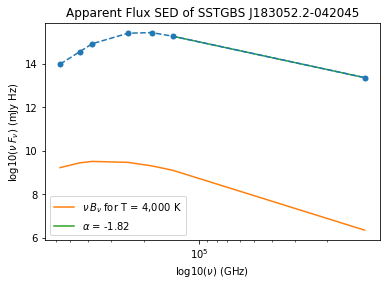

35
27828
COMPARISON OF FLUXES AND ERRORS CALCULATED BY DIFFERENT METHODS
[ 9.50625681 19.65248763 36.65051502 73.8054003  66.6653426  50.16439571]
[ 9.506256 19.652487 36.650517 73.8054   66.66533  50.164394]
[0.01911086 0.01117028 0.03843918 1.78874138 1.67861369 1.35794494]
[0.01911108 0.01116935 0.03843901 1.7674093  1.7674093  1.7674093 ]
Signal to Noise
[ 497.42691384 1759.35561618  953.46756887   41.26107949   39.71452329
   36.94140636]
[ 497.42117  1759.5016    953.4719     41.759087   37.719234   28.383009]
497.42117 1759.5016 953.472
****************************************************************
The GB index 2079
RA:  277.799036683928
DEC:  -4.005380132320037
The difference in RA is  0.023 arcseconds
The difference in Dec is  0.225 arcseconds
The Gould_Belt_ID is  SSTGBS J183111.8-040019
alpha is -0.85
2MASS ID: b'18311177-0400190'
FLUX SIGNAL TO NOISE
[4.97421185e+02 1.75950157e+03 9.53471932e+02 4.17590855e+01
 3.77192357e+01 2.83830088e+01 1.98518519e+01 1.00000000e+00
 

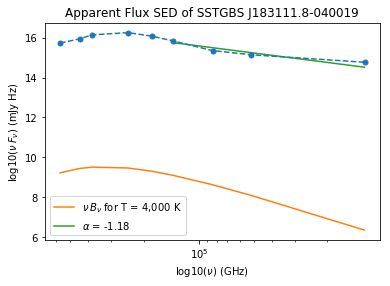

36
3802
COMPARISON OF FLUXES AND ERRORS CALCULATED BY DIFFERENT METHODS
[3.53470000e+06 2.04290229e-01 2.62030000e+06 1.50691366e+01
 5.12271288e+01 1.07348423e+02]
[         nan   0.20429017          nan  15.06914234  51.22714233
 107.3483963 ]
[0.         0.00330352 0.         0.32262648 1.28988401 2.29830313]
[       nan 0.00330351        nan 0.31922144 0.31922144 0.31922144]
Signal to Noise
[        inf 61.84008907         inf 46.70768716 39.71452329 46.70768716]
[         nan  61.84028057          nan  47.20592227 160.47525761
 336.28191552]
-- 61.840282 --
****************************************************************
The GB index 2107
RA:  277.8135699844219
DEC:  -2.093275295849145
The difference in RA is  0.015 arcseconds
The difference in Dec is  0.252 arcseconds
The Gould_Belt_ID is  SSTGBS J183115.3-020536
alpha is -0.81
2MASS ID: b'18311526-0205355'
FLUX SIGNAL TO NOISE
[         nan  61.84028057          nan  47.20592227 160.47525761
 336.28191552  16.57894737  19.705882

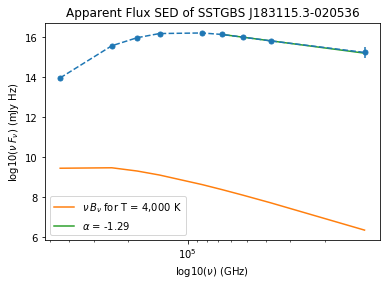

37
3974
COMPARISON OF FLUXES AND ERRORS CALCULATED BY DIFFERENT METHODS
[  1.16022274   8.97222397  26.8322086  206.67509802 311.24319738
 320.62365502]
[  1.1602223   8.972222   26.832209  206.67511   311.24326   320.62363  ]
[9.29092875e-03 6.41208707e-03 1.11821548e-01 5.59467325e+00
 1.37691553e+01 7.16623966e+00]
[0.00929094 0.00641227 0.11182281 5.5202894  5.5202894  5.5202894 ]
Signal to Noise
[ 124.87693832 1399.26733285  239.95561766   36.94140636   22.60437838
   44.74085019]
[ 124.8767   1399.228     239.95291    37.43918    56.38169    58.080944]
124.87671 1399.228 239.95291
****************************************************************
The GB index 2178
RA:  277.84409491064514
DEC:  -2.092138110870018
The difference in RA is  0.072 arcseconds
The difference in Dec is  0.081 arcseconds
The Gould_Belt_ID is  SSTGBS J183122.6-020532
alpha is -1.83
2MASS ID: b'18312257-0205315'
FLUX SIGNAL TO NOISE
[1.24876700e+02 1.39922807e+03 2.39952918e+02 3.74391801e+01
 5.63816916e+01 

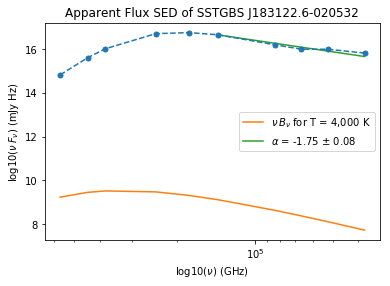

38
3857
COMPARISON OF FLUXES AND ERRORS CALCULATED BY DIFFERENT METHODS
[0.12172814 0.43061227 1.01013296 2.58040707 3.82208269 3.07040446]
[0.12172811 0.43061206 1.0101333  2.580407   3.822082   3.0704038 ]
[0.00403946 0.000543   0.00452516 0.07473781 0.1179523  0.17445273]
[0.00403946 0.00054301 0.00452517 0.07367592 0.07367592 0.07367592]
Signal to Noise
[ 30.13474289 793.02406729 223.22596135  34.52612842  32.4036301
  17.60020875]
[ 30.134762 793.00616  223.22525   35.023746  51.87695   41.674454]
30.134764 793.0062 223.22523
****************************************************************
The GB index 2186
RA:  277.8470074845617
DEC:  -2.3313913542952314
The difference in RA is  0.059 arcseconds
The difference in Dec is  0.11 arcseconds
The Gould_Belt_ID is  SSTGBS J183123.3-021953
alpha is 0.56
2MASS ID: b'18312326-0219529'
FLUX SIGNAL TO NOISE
[ 3.01347625e+01  7.93006192e+02  2.23225245e+02  3.50237472e+01
  5.18769482e+01  4.16744533e+01  9.12500000e+00  6.65217391e+00
  9.12

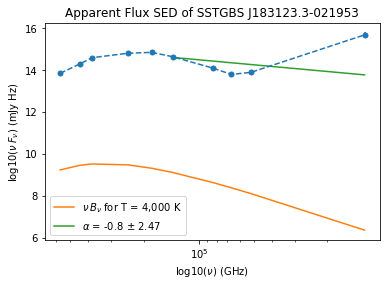

39
3715
COMPARISON OF FLUXES AND ERRORS CALCULATED BY DIFFERENT METHODS
[6.14472213e-03 4.46404111e-02 1.69484735e-01 5.25881784e+00
 2.02255381e+01 3.48976003e+01]
[6.1447192e-03 4.4640429e-02 1.6948473e-01 5.2588167e+00 2.0225529e+01
 3.4897610e+01]
[2.37065057e-03 4.65353698e-04 5.69963261e-03 1.42355648e-01
 5.47503197e-01 7.47148968e-01]
[0.00237065 0.00046535 0.00569963 0.14046292 0.14046292 0.14046292]
Signal to Noise
[ 2.59199825 95.92791738 29.73608064 36.94140636 36.94140636 46.70768716]
[  2.5919983  95.92802    29.736115   37.439182  143.99194   248.44713  ]
2.5919986 95.92802 29.736115
****************************************************************
The GB index 2219
RA:  277.85576950218535
DEC:  -2.0591104573735635
The difference in RA is  0.058 arcseconds
The difference in Dec is  0.086 arcseconds
The Gould_Belt_ID is  SSTGBS J183125.4-020333
alpha is -0.59
2MASS ID: b'18312538-0203326'
FLUX SIGNAL TO NOISE
[  2.59199846  95.92801841  29.73611417  37.43918122 143.9919425

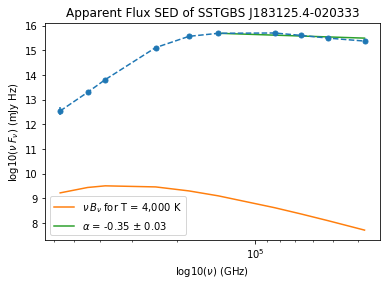

40
4052
COMPARISON OF FLUXES AND ERRORS CALCULATED BY DIFFERENT METHODS
[ 5.65555831 10.7659795  18.84726648 32.42561937 33.44258931 26.890295  ]
[ 5.6555595 10.76598   18.847267  32.425632  33.44259   26.89029  ]
[0.02843148 0.01240667 0.06260847 0.81646755 0.77897799 0.52516685]
[0.0284314  0.01240731 0.06260841 0.80635804 0.80635804 0.80635804]
Signal to Noise
[198.91888741 867.75705682 301.03382093  39.71452329  42.93136635
  51.20333653]
[198.9195   867.7128   301.0341    40.212452  41.47362   33.347828]
198.91951 867.7128 301.0341
****************************************************************
The GB index 2226
RA:  277.85651897766274
DEC:  -4.371850877723383
The difference in RA is  0.307 arcseconds
The difference in Dec is  0.245 arcseconds
The Gould_Belt_ID is  SSTGBS J183125.5-042218
alpha is -1.8
2MASS ID: b'18312556-0422185'
FLUX SIGNAL TO NOISE
[198.91949674 867.71281807 301.03409634  40.21245017  41.47362235
  33.34782813   1.           1.           1.           1.
   9.

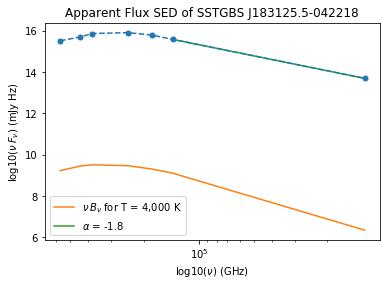

41
28230
COMPARISON OF FLUXES AND ERRORS CALCULATED BY DIFFERENT METHODS
[1.97612431e-02 1.04508743e-01 5.22079753e-01 2.72450889e+02
 1.01835673e+03 1.82808130e+03]
[1.97612252e-02 1.04508772e-01 5.22080004e-01 2.72450958e+02
 1.01835693e+03 1.82808142e+03]
[4.24064443e-03 7.73443145e-03 1.19016105e-01 6.60309647e+00
 3.14272423e+01 2.71390800e+01]
[4.2406404e-03 7.7344337e-03 1.1901617e-01 6.5243516e+00 6.5243516e+00
 6.5243516e+00]
Signal to Noise
[ 4.65996228 13.51214288  4.38663114 41.26107949 32.4036301  67.35973762]
[  4.6599627  13.512143    4.386631   41.759087  156.08554   280.19357  ]
4.659962 13.512143 4.386631
****************************************************************
The GB index 2254
RA:  277.86458941416277
DEC:  -3.64675060226728
The difference in RA is  0.02 arcseconds
The difference in Dec is  0.211 arcseconds
The Gould_Belt_ID is  SSTGBS J183127.5-033848
alpha is -1.3
2MASS ID: b'18312750-0338481'
FLUX SIGNAL TO NOISE
[  4.65996245  13.5121427    4.38663084  41

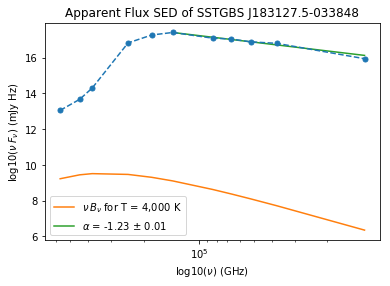

42
28115
COMPARISON OF FLUXES AND ERRORS CALCULATED BY DIFFERENT METHODS
[ 56.56387973  87.83480293 132.13941128 179.34464793 142.39668443
 103.75174457]
[ 56.563854  87.834785 132.13947  179.34467  142.39668  103.75176 ]
[0.08782005 0.02500409 0.14055728 4.34658158 2.91477922 2.02626922]
[0.08782065 0.0250071  0.14055    4.2947464  4.2947464  4.2947464 ]
Signal to Noise
[ 644.08846711 3512.81734817  940.11074536   41.26107949   48.85333449
   51.20333653]
[ 644.08374  3512.394     940.15985    41.759083   33.156017   24.157831]
644.08374 3512.3938 940.1598
****************************************************************
The GB index 2304
RA:  277.8825297953799
DEC:  -4.015997612184812
The difference in RA is  0.311 arcseconds
The difference in Dec is  0.158 arcseconds
The Gould_Belt_ID is  SSTGBS J183131.8-040057
alpha is -2.42
2MASS ID: b'18313180-0400574'
FLUX SIGNAL TO NOISE
[6.44083764e+02 3.51239405e+03 9.40159822e+02 4.17590816e+01
 3.31560166e+01 2.41578321e+01 1.00000000e+00 1

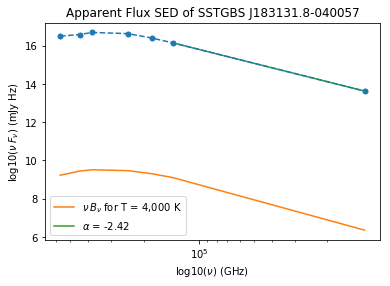

43
28080
COMPARISON OF FLUXES AND ERRORS CALCULATED BY DIFFERENT METHODS
[10.81303229 23.01642307 43.3196014  89.38985099 83.61801426 64.56477653]
[10.813027 23.016418 43.31958  89.38983  83.61798  64.56477 ]
[0.02239275 0.01293688 0.05305595 1.99794708 1.71161324 1.26094862]
[0.0223931  0.01293819 0.05305476 1.9759458  1.9759458  1.9759458 ]
Signal to Noise
[ 482.88095629 1779.13211302  816.48900366   44.74085019   48.85333449
   51.20333653]
[ 482.87326  1778.9518    816.50696    45.23901    42.31795    32.675377]
482.87326 1778.9518 816.5069
****************************************************************
The GB index 2330
RA:  277.89627575416006
DEC:  -3.8495648700158207
The difference in RA is  0.0 arcseconds
The difference in Dec is  0.096 arcseconds
The Gould_Belt_ID is  SSTGBS J183135.1-035058
alpha is -2.03
2MASS ID: b'18313510-0350583'
FLUX SIGNAL TO NOISE
[4.82873260e+02 1.77895180e+03 8.16506929e+02 4.52390092e+01
 4.23179521e+01 3.26753763e+01 2.04026846e+01 1.00000000e+00

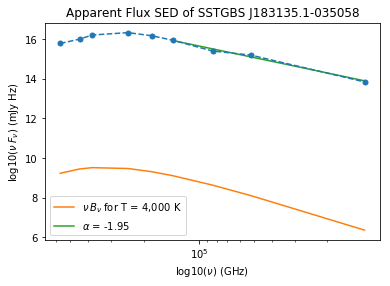

44
28112
COMPARISON OF FLUXES AND ERRORS CALCULATED BY DIFFERENT METHODS
[ 0.1369505   0.63658507  1.66736058  7.93027354 13.83884428 15.54516943]
[ 0.1369505   0.63658506  1.6673607   7.930272   13.838841   15.545173  ]
[0.00537253 0.00375739 0.02467547 0.20717337 0.29628622 0.30359681]
[0.00537254 0.0037574  0.02467542 0.20451342 0.20451342 0.20451342]
Signal to Noise
[ 25.49085905 169.4223207   67.57159352  38.27844089  46.70768716
  51.20333653]
[ 25.490833 169.42178   67.57173   38.776295  67.66716   76.01053 ]
25.490833 169.42178 67.57173
****************************************************************
The GB index 2572
RA:  278.0076277412323
DEC:  -3.900869306285377
The difference in RA is  0.391 arcseconds
The difference in Dec is  0.06 arcseconds
The Gould_Belt_ID is  SSTGBS J183201.8-035403
alpha is -1.04
2MASS ID: b'18320182-0354030'
FLUX SIGNAL TO NOISE
[ 25.49083414 169.4217854   67.57173516  38.77629287  67.66715715
  76.01052791   1.           1.           1.           1

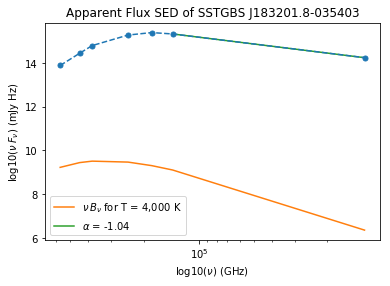

45
3905
COMPARISON OF FLUXES AND ERRORS CALCULATED BY DIFFERENT METHODS
[0.10851815 0.39550478 1.01533327 3.34879235 4.29635363 3.65422799]
[0.10851812 0.39550486 1.0153337  3.3487937  4.296352   3.654228  ]
[0.00230447 0.00202816 0.00652499 0.09065146 0.10007493 0.09201238]
[0.00230447 0.00202816 0.00652495 0.08944624 0.08944624 0.08944624]
Signal to Noise
[ 47.0902375  195.00679527 155.60682438  36.94140636  42.93136635
  39.71452329]
[ 47.090225 195.00676  155.60796   37.43918   48.032784  40.853905]
47.09022 195.00674 155.60796
****************************************************************
The GB index 2751
RA:  278.13398953005776
DEC:  -2.158207244933876
The difference in RA is  0.052 arcseconds
The difference in Dec is  0.089 arcseconds
The Gould_Belt_ID is  SSTGBS J183232.2-020929
alpha is -1.9
2MASS ID: b'18323214-0209294'
FLUX SIGNAL TO NOISE
[ 47.0902245  195.00675569 155.60795383  37.43917884  48.03278427
  40.85390292  20.38834951  19.56856703  20.38834951   6.37254902
  

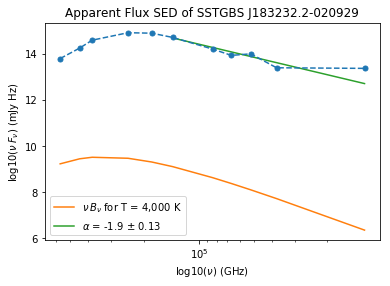

46
3642
COMPARISON OF FLUXES AND ERRORS CALCULATED BY DIFFERENT METHODS
[0.20231235 0.57977119 1.24340807 3.29980519 4.45758882 3.84764985]
[0.2023124  0.57977116 1.2434087  3.2998054  4.4575896  3.8476498 ]
[0.00435922 0.00094949 0.00276945 0.10183443 0.09543587 0.1077969 ]
[0.00435922 0.00094952 0.00276942 0.10029469 0.10029469 0.10029469]
Signal to Noise
[ 46.41025875 610.61347786 448.97279758  32.4036301   46.70768716
  35.69351019]
[ 46.410213 610.597    448.97723   32.901096  44.44492   38.36344 ]
46.410213 610.597 448.97723
****************************************************************
The GB index 2752
RA:  278.1340259731196
DEC:  -2.2169644958291386
The difference in RA is  0.105 arcseconds
The difference in Dec is  0.014 arcseconds
The Gould_Belt_ID is  SSTGBS J183232.2-021301
alpha is -2.05
2MASS ID: b'18323214-0213011'
FLUX SIGNAL TO NOISE
[ 46.41021168 610.59698975 448.97722956  32.90109637  44.44491962
  38.36344324  19.68253968  19.7301855   19.68253968   7.16
   3.333

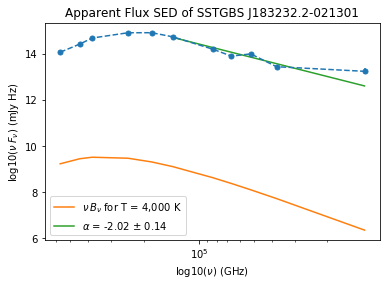

47
42116
COMPARISON OF FLUXES AND ERRORS CALCULATED BY DIFFERENT METHODS
[ 4.7669429   9.27378665 16.69094047 29.76380819 31.67377954 23.98809325]
[ 4.766945  9.273787 16.690933 29.763807 31.673775 23.9881  ]
[0.0158807  0.00404953 0.02922693 0.72135311 0.64834427 0.46848692]
[0.01588051 0.00404979 0.02922635 0.7127505  0.7127505  0.7127505 ]
Signal to Noise
[ 300.17204878 2290.09216805  571.0809251    41.26107949   48.85333449
   51.20333653]
[ 300.17572  2289.9443    571.092      41.759083   44.438797   33.655678]
300.17572 2289.9443 571.092
****************************************************************
The GB index 2859
RA:  278.1968226650767
DEC:  -4.866850358523684
The difference in RA is  0.095 arcseconds
The difference in Dec is  0.115 arcseconds
The Gould_Belt_ID is  SSTGBS J183247.2-045201
alpha is -1.95
2MASS ID: b'18324723-0452005'
FLUX SIGNAL TO NOISE
[3.00175731e+02 2.28994437e+03 5.71091993e+02 4.17590833e+01
 4.44387973e+01 3.36556765e+01 1.00000000e+00 1.00000000e+00


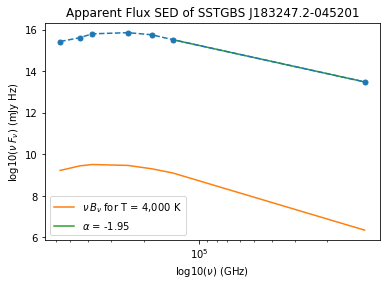

48
49613
COMPARISON OF FLUXES AND ERRORS CALCULATED BY DIFFERENT METHODS
[0.4013977  1.01184805 2.05727138 5.17712237 7.1433189  5.67016549]
[0.40139785 1.0118476  2.0572705  5.177121   7.143322   5.6701665 ]
[4.64923384e-03 8.15885148e-04 6.63340971e-03 3.85613394e-01
 8.71616731e-01 5.18481834e-01]
[0.00464925 0.00081593 0.00663344 0.37192777 0.37192777 0.37192777]
Signal to Noise
[  86.33631138 1240.18442589  310.13784259   13.42568085    8.19548162
   10.93609289]
[  86.335976 1240.1216    310.1363     13.919695   19.206207   15.245343]
86.335976 1240.1217 310.1363
****************************************************************
The GB index 2902
RA:  278.234657500942
DEC:  -0.5183239819912588
The difference in RA is  0.266 arcseconds
The difference in Dec is  0.148 arcseconds
The Gould_Belt_ID is  SSTGBS J183256.3+000-3106
alpha is -1.2
2MASS ID: b'18325633-0031059'
FLUX SIGNAL TO NOISE
[8.63359782e+01 1.24012161e+03 3.10136297e+02 1.39196952e+01
 1.92062078e+01 1.52453433e+01 1.4

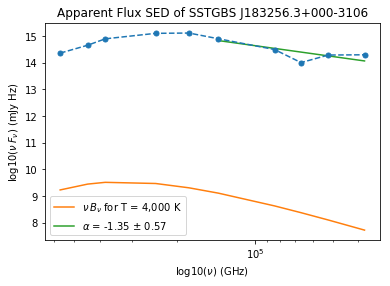

49
48753
COMPARISON OF FLUXES AND ERRORS CALCULATED BY DIFFERENT METHODS
[0.00738244 0.02954334 0.09264144 1.49447426 4.03924192 4.86626313]
[0.00738244 0.02954334 0.09264144 1.4944743  4.03924    4.8662653 ]
[0.00537942 0.00022339 0.00571605 0.07331772 0.17093034 0.18727549]
[0.00537942 0.00022339 0.00571605 0.07157601 0.07157601 0.07157601]
Signal to Noise
[  1.37234796 132.25192341  16.20723941  20.38353296  23.63092404
  25.98451691]
[  1.3723478 132.251      16.207254   20.879543   56.432877   67.98738  ]
1.372348 132.251 16.207254
****************************************************************
The GB index 3084
RA:  278.51607153390756
DEC:  -1.060809117858748
The difference in RA is  0.398 arcseconds
The difference in Dec is  0.07 arcseconds
The Gould_Belt_ID is  SSTGBS J183403.8-010339
alpha is -0.93
2MASS ID: b'18340385-0103388'
FLUX SIGNAL TO NOISE
[  1.37234787 132.25101263  16.2072537   20.87954275  56.43287561
  67.98738181   1.           1.           1.           1.
  10.

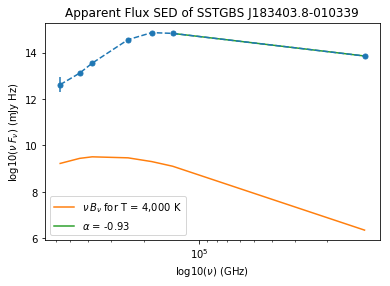

50
49286
COMPARISON OF FLUXES AND ERRORS CALCULATED BY DIFFERENT METHODS
[  1.9248888    6.05052423  13.82675927  61.67203259  98.24261776
 108.64143274]
[  1.9248884   6.050527   13.826753   61.672005   98.2426    108.641426 ]
[0.09360964 0.07600619 0.4717949  1.37842782 2.01097057 1.91791914]
[0.09360966 0.0760065  0.4717954  1.3632485  1.3632485  1.3632485 ]
Signal to Noise
[20.56293405 79.60567878 29.30671635 44.74085019 48.85333449 56.64547091]
[20.562923 79.605385 29.306671 45.239006 72.06507  79.69305 ]
20.562925 79.60539 29.306671
****************************************************************
The GB index 3119
RA:  278.7758028605848
DEC:  -0.6596334871103713
The difference in RA is  0.141 arcseconds
The difference in Dec is  0.436 arcseconds
The Gould_Belt_ID is  SSTGBS J183506.2+000-3935
alpha is -0.94
2MASS ID: b'18350619-0039344'
FLUX SIGNAL TO NOISE
[20.56292432 79.60538827 29.30667059 45.23900534 72.06507239 79.69304839
  1.          1.          1.          1.         10

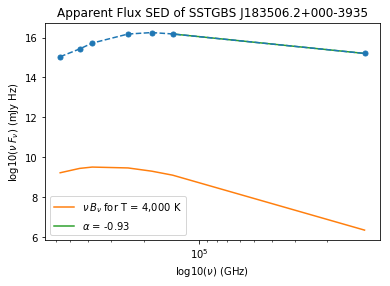

51
49179
COMPARISON OF FLUXES AND ERRORS CALCULATED BY DIFFERENT METHODS
[ 24.42011481  52.38824824  98.5036873  210.32368081 206.01549517
 170.60657887]
[ 24.420109  52.388268  98.50367  210.32373  206.01546  170.6066  ]
[0.04788476 0.01495717 0.15088008 5.09738677 4.99297395 3.65264455]
[0.04788572 0.01496024 0.1508826  5.036598   5.036598   5.036598  ]
Signal to Noise
[ 509.9767964  3502.55035844  652.86076711   41.26107949   41.26107949
   46.70768716]
[ 509.9664   3501.833     652.84973    41.759083   40.90369    33.87338 ]
509.96643 3501.8333 652.84973
****************************************************************
The GB index 3127
RA:  278.8426787695807
DEC:  -0.44302996157754904
The difference in RA is  1.183 arcseconds
The difference in Dec is  0.837 arcseconds
The Gould_Belt_ID is  SSTGBS J183522.3+000-2636
alpha is -1.77
2MASS ID: b'18352224-0026347'
FLUX SIGNAL TO NOISE
[5.09966415e+02 3.50183301e+03 6.52849756e+02 4.17590846e+01
 4.09036911e+01 3.38733786e+01 1.00000000e

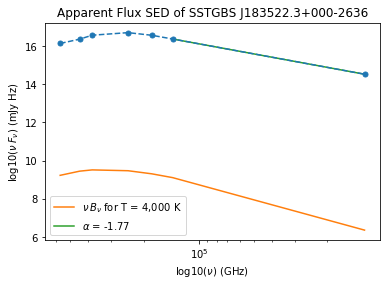

52
49220
COMPARISON OF FLUXES AND ERRORS CALCULATED BY DIFFERENT METHODS
[0.0144553  0.15128598 0.46052807 4.13131658 7.72502786 8.33288602]
[0.01445529 0.15128599 0.460528   4.1313148  7.72503    8.332887  ]
[0.00138969 0.00102156 0.00865651 0.10402533 0.25308277 0.23345661]
[0.00138969 0.00102156 0.0086565  0.1027372  0.1027372  0.1027372 ]
Signal to Noise
[ 10.40180434 148.09349754  53.2002017   39.71452329  30.52372059
  35.69351019]
[ 10.401807 148.09357   53.20027   40.212452  75.19214   81.10876 ]
10.401807 148.09357 53.200268
****************************************************************
The GB index 3129
RA:  278.8511555365188
DEC:  -0.6016645469695971
The difference in RA is  0.208 arcseconds
The difference in Dec is  0.024 arcseconds
The Gould_Belt_ID is  SSTGBS J183524.3+000-3606
alpha is -1.13
2MASS ID: b'18352427-0036057'
FLUX SIGNAL TO NOISE
[ 10.40180677 148.09356924  53.2002703   40.21245103  75.19213782
  81.10875548   1.           1.           1.           1.
  10.

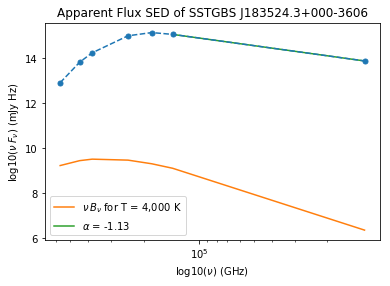

53
49437
COMPARISON OF FLUXES AND ERRORS CALCULATED BY DIFFERENT METHODS
[  8.93880734  20.34866583  41.15482263 106.97652166 141.35139836
 127.5251316 ]
[  8.938806  20.348675  41.154823 106.97657  141.35138  127.52514 ]
[0.11914456 0.07825227 0.38483934 2.59267385 3.42578042 3.0906882 ]
[0.11914408 0.07825149 0.3848383  2.5617557  2.5617557  2.5617557 ]
Signal to Noise
[ 75.02489147 260.03931736 106.94026908  41.26107949  41.26107949
  41.26107949]
[ 75.02518  260.04202  106.94056   41.759083  55.17754   49.78037 ]
75.02518 260.04202 106.94055
****************************************************************
The GB index 3133
RA:  278.87489854779886
DEC:  -0.7155786967456734
The difference in RA is  0.485 arcseconds
The difference in Dec is  0.381 arcseconds
The Gould_Belt_ID is  SSTGBS J183529.9+000-4256
alpha is -1.32
2MASS ID: b'18352997-0042557'
FLUX SIGNAL TO NOISE
[ 75.02517477 260.04201533 106.9405564   41.75908418  55.17754162
  49.78036781   1.           1.           1.      

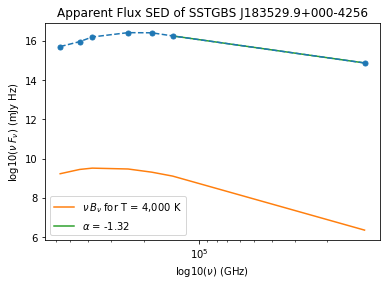

54
54893
COMPARISON OF FLUXES AND ERRORS CALCULATED BY DIFFERENT METHODS
[ 8.27562935 15.43504913 27.15330301 53.66464404 49.6935494  36.44144052]
[ 8.275633 15.435053 27.153292 53.66462  49.693527 36.441433]
[0.02475011 0.00419152 0.043637   1.09848477 1.20436862 0.84883021]
[0.02474991 0.00419234 0.04363597 1.0873927  1.0873927  1.0873927 ]
Signal to Noise
[ 334.36734737 3682.44406404  622.25416508   48.85333449   41.26107949
   42.93136635]
[ 334.3702   3681.731     622.2685     49.351646   45.699707   33.512672]
334.3702 3681.731 622.2685
****************************************************************
The GB index 3136
RA:  278.8849686882642
DEC:  0.18237800723529082
The difference in RA is  0.199 arcseconds
The difference in Dec is  0.151 arcseconds
The Gould_Belt_ID is  SSTGBS J183532.4+001057
alpha is -2.18
2MASS ID: b'18353238+0010567'
FLUX SIGNAL TO NOISE
[3.34370214e+02 3.68173087e+03 6.22268522e+02 4.93516464e+01
 4.56997070e+01 3.35126706e+01 1.00000000e+00 1.00000000e+00


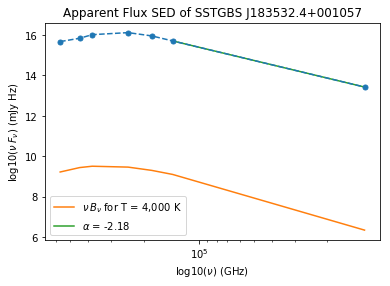

55
33320
COMPARISON OF FLUXES AND ERRORS CALCULATED BY DIFFERENT METHODS
[0.02350581 0.21433439 0.63723662 4.1199161  6.33723764 6.69260934]
[0.02350581 0.21433444 0.6372365  4.119918   6.33724    6.692608  ]
[0.0015846  0.00046349 0.00780201 0.14281927 0.25601919 0.23200316]
[0.0015846  0.00046348 0.00780201 0.14039962 0.14039962 0.14039962]
Signal to Noise
[ 14.83393949 462.43704765  81.67593305  28.84706117  24.75297861
  28.84706117]
[ 14.833934 462.44226   81.67592   29.344223  45.13716   47.668278]
14.833935 462.44226 81.67592
****************************************************************
The GB index 3170
RA:  278.9618097265066
DEC:  0.46418311297809745
The difference in RA is  1.248 arcseconds
The difference in Dec is  0.325 arcseconds
The Gould_Belt_ID is  SSTGBS J183550.8+002751
alpha is -0.86
2MASS ID: b'18355082+0027510'
FLUX SIGNAL TO NOISE
[ 14.8339343  462.44226545  81.67592171  29.34422381  45.13716078
  47.66827633   1.           1.           1.           1.
  10.480

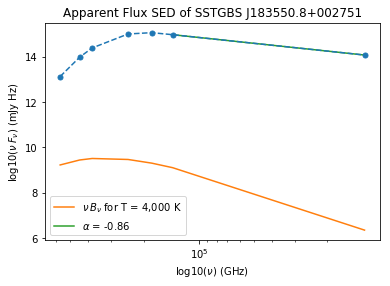

56
54737
COMPARISON OF FLUXES AND ERRORS CALCULATED BY DIFFERENT METHODS
[ 2.21778748  6.68544986 14.94186958 50.1289365  62.04404267 51.66487943]
[ 2.2177875  6.685448  14.94187   50.128925  62.044044  51.664867 ]
[0.00561519 0.00274555 0.02722401 1.12042879 1.2700063  0.91207432]
[0.00561508 0.00274595 0.02722392 1.1080908  1.1080908  1.1080908 ]
Signal to Noise
[ 394.96246191 2435.0095084   548.84899487   44.74085019   48.85333449
   56.64547091]
[ 394.96957  2434.6582    548.85077    45.239006   55.991844   46.625122]
394.96957 2434.6582 548.85077
****************************************************************
The GB index 3175
RA:  278.9723528917186
DEC:  -0.35988244065879404
The difference in RA is  0.134 arcseconds
The difference in Dec is  0.087 arcseconds
The Gould_Belt_ID is  SSTGBS J183553.4+000-2135
alpha is -2.28
2MASS ID: b'18355336-0021355'
FLUX SIGNAL TO NOISE
[3.94969574e+02 2.43465815e+03 5.48850771e+02 4.52390068e+01
 5.59918437e+01 4.66251225e+01 1.00000000e+00 2.0

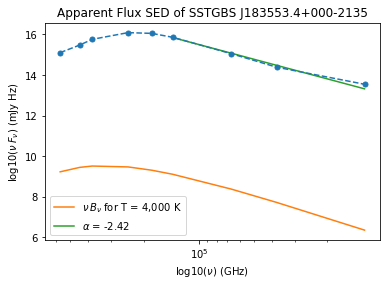

57
33287
COMPARISON OF FLUXES AND ERRORS CALCULATED BY DIFFERENT METHODS
[13.83487746 23.88709408 39.4310717  68.43656901 56.6369812  45.58222793]
[13.834877 23.887098 39.431053 68.4366   56.636993 45.582207]
[0.01972003 0.00746631 0.04404415 1.65862284 1.64040927 1.19080681]
[0.01971971 0.00746716 0.04404425 1.6388434  1.6388434  1.6388434 ]
Signal to Noise
[ 701.5646067  3199.31660311  895.26230879   41.26107949   34.52612842
   38.27844089]
[ 701.5761   3198.9553    895.25995    41.759083   34.559124   27.813644]
701.5762 3198.9553 895.25995
****************************************************************
The GB index 3213
RA:  279.02433323690326
DEC:  0.5171925520033311
The difference in RA is  0.276 arcseconds
The difference in Dec is  0.191 arcseconds
The Gould_Belt_ID is  SSTGBS J183605.8+003102
alpha is -2.16
2MASS ID: b'18360582+0031020'
FLUX SIGNAL TO NOISE
[7.01576135e+02 3.19895539e+03 8.95259978e+02 4.17590839e+01
 3.45591243e+01 2.78136436e+01 1.00000000e+00 1.00000000e+0

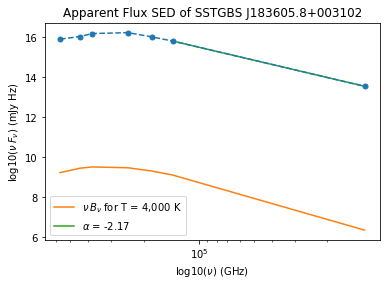

58
46997
COMPARISON OF FLUXES AND ERRORS CALCULATED BY DIFFERENT METHODS
[ 1.21397985  3.14475354  6.69169874 19.25255118 24.51884106 20.43597828]
[ 1.2139804  3.144755   6.691702  19.252542  24.518843  20.43597  ]
[0.01816207 0.01215148 0.08340644 0.41219235 0.52494231 0.41831286]
[0.01816207 0.01215163 0.08340687 0.40784168 0.40784168 0.40784168]
Signal to Noise
[ 66.84149752 258.79582717  80.22999789  46.70768716  46.70768716
  48.85333449]
[ 66.84153  258.79288   80.22963   47.20592   60.11853   50.107605]
66.84153 258.79288 80.22963
****************************************************************
The GB index 3267
RA:  279.1683670405813
DEC:  -0.6459599169799984
The difference in RA is  0.025 arcseconds
The difference in Dec is  0.071 arcseconds
The Gould_Belt_ID is  SSTGBS J183640.4+000-3845
alpha is -2.13
2MASS ID: b'18364041-0038453'
FLUX SIGNAL TO NOISE
[ 66.84153135 258.79287096  80.22962907  47.20592162  60.11853068
  50.10760593   1.           1.           1.           1.
 

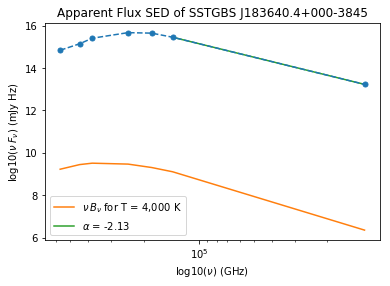

59
56004
COMPARISON OF FLUXES AND ERRORS CALCULATED BY DIFFERENT METHODS
[ 0.10903486  0.69788297  2.37771239 16.87673484 29.4238786  28.23551717]
[ 0.10903491  0.69788283  2.3777134  16.876743   29.423866   28.23551   ]
[0.00149717 0.00289757 0.01817962 0.39310966 0.71311461 0.65768969]
[0.00149718 0.00289753 0.01817966 0.3886014  0.3886014  0.3886014 ]
Signal to Noise
[ 72.82725961 240.85124177 130.78999003  42.93136635  41.26107949
  42.93136635]
[ 72.82699  240.85446  130.7898    43.429447  75.71735   72.65931 ]
72.82699 240.85446 130.7898
****************************************************************
The GB index 3271
RA:  279.17280086761184
DEC:  0.3949561609420856
The difference in RA is  0.245 arcseconds
The difference in Dec is  0.138 arcseconds
The Gould_Belt_ID is  SSTGBS J183641.5+002342
alpha is -1.44
2MASS ID: b'18364146+0023420'
FLUX SIGNAL TO NOISE
[ 72.82698681 240.85446307 130.78979948  43.42944632  75.71734646
  72.65931213  20.84765178   1.          20.84765178   

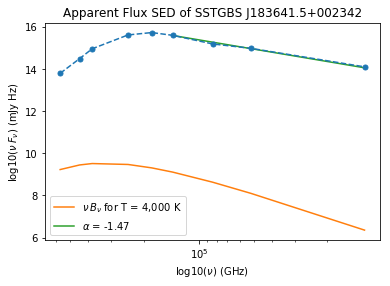

60
56239
COMPARISON OF FLUXES AND ERRORS CALCULATED BY DIFFERENT METHODS
[0.01892973 0.16113919 0.49944174 4.02242878 7.2426883  7.46785108]
[0.01892974 0.16113916 0.49944162 4.022428   7.2426887  7.467851  ]
[0.00353386 0.00123543 0.01068232 0.15095538 0.23728065 0.2375571 ]
[0.00353386 0.00123543 0.01068234 0.14819172 0.14819172 0.14819172]
Signal to Noise
[  5.3566726  130.43206796  46.75403064  26.64647577  30.52372059
  31.43602561]
[  5.356672 130.43143   46.75395   27.143406  48.873775  50.393173]
5.3566713 130.43143 46.75395
****************************************************************
The GB index 3287
RA:  279.2031943568173
DEC:  0.4631252451829466
The difference in RA is  0.008 arcseconds
The difference in Dec is  0.021 arcseconds
The Gould_Belt_ID is  SSTGBS J183648.8+002747
alpha is -0.94
2MASS ID: b'18364876+0027473'
FLUX SIGNAL TO NOISE
[  5.35667177 130.43142925  46.75395002  27.14340605  48.87377408
  50.39317412  20.19379845   1.          20.19379845   1.
  10.5434

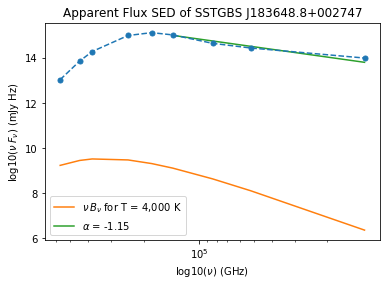

61
56774
COMPARISON OF FLUXES AND ERRORS CALCULATED BY DIFFERENT METHODS
[0.05170303 0.37408375 1.08884574 5.41113268 7.94877327 7.11206094]
[0.05170304 0.37408394 1.0888453  5.411133   7.9487767  7.112061  ]
[0.00278485 0.00095302 0.00844275 0.16185629 0.25285554 0.23300112]
[0.00278485 0.00095303 0.00844277 0.1594828  0.1594828  0.1594828 ]
Signal to Noise
[ 18.56580844 392.52295576 128.96820575  33.43171084  31.43602561
  30.52372059]
[ 18.565794 392.52136  128.96779   33.929256  49.84096   44.594532]
18.565794 392.52136 128.96779
****************************************************************
The GB index 3304
RA:  279.2453851510593
DEC:  0.550014447891231
The difference in RA is  0.116 arcseconds
The difference in Dec is  0.089 arcseconds
The Gould_Belt_ID is  SSTGBS J183658.9+003300
alpha is -1.73
2MASS ID: b'18365888+0033001'
FLUX SIGNAL TO NOISE
[ 18.5657941  392.52136689 128.96779188  33.92925493  49.84096327
  44.59453129   1.           1.           1.           1.
   5.9512

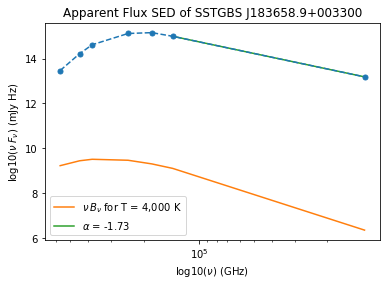

62
56146
COMPARISON OF FLUXES AND ERRORS CALCULATED BY DIFFERENT METHODS
[14.00654922 25.76238818 44.44176765 82.88735894 74.79974466 58.12935767]
[14.00655  25.762383 44.441757 82.887375 74.79976  58.129383]
[0.05466299 0.01884744 0.09239488 1.69665714 1.81284023 1.24453513]
[0.0546633  0.01884817 0.09239588 1.679526   1.679526   1.679526  ]
Signal to Noise
[ 256.2345863  1366.89063913  480.99814959   48.85333449   41.26107949
   46.70768716]
[ 256.23312  1366.8374    480.99286    49.351646   44.536232   34.610588]
256.23312 1366.8374 480.99286
****************************************************************
The GB index 3310
RA:  279.26811936263465
DEC:  0.41087308460682864
The difference in RA is  0.003 arcseconds
The difference in Dec is  0.067 arcseconds
The Gould_Belt_ID is  SSTGBS J183704.3+002439
alpha is -2.4
2MASS ID: b'18370434+0024393'
FLUX SIGNAL TO NOISE
[2.56233135e+02 1.36683737e+03 4.80992849e+02 4.93516482e+01
 4.45362324e+01 3.46105890e+01 2.10156250e+01 1.00000000e+

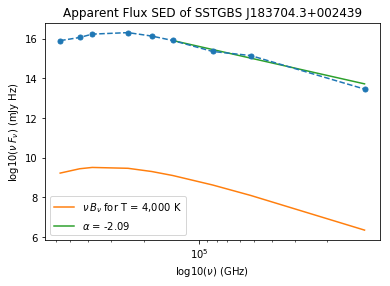

63
55890
COMPARISON OF FLUXES AND ERRORS CALCULATED BY DIFFERENT METHODS
[0.00843338 0.04304391 0.1227437  0.95959607 1.33014846 1.42822114]
[0.00843338 0.04304391 0.12274367 0.95959604 1.3301488  1.4282218 ]
[0.00208662 0.00023081 0.00272884 0.07432756 0.12833033 0.11346318]
[0.00208662 0.00023081 0.00272884 0.07158947 0.07158947 0.07158947]
Signal to Noise
[  4.04164125 186.49224498  44.98009646  12.91036704  10.36503608
  12.58752946]
[  4.0416408 186.49336    44.980095   13.404151   18.58023    19.950167 ]
4.0416408 186.49336 44.980095
****************************************************************
The GB index 3330
RA:  279.34341050210094
DEC:  0.37811582470526517
The difference in RA is  0.009 arcseconds
The difference in Dec is  0.074 arcseconds
The Gould_Belt_ID is  SSTGBS J183722.4+002241
alpha is -1.94
2MASS ID: b'18372242+0022413'
FLUX SIGNAL TO NOISE
[  4.04164079 186.4933628   44.98009538  13.40415063  18.58022999
  19.95016618  18.6827957   18.48484848  18.6827957    3.6

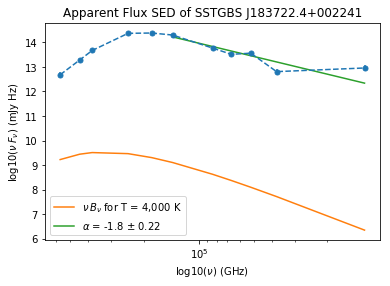

64
56584
COMPARISON OF FLUXES AND ERRORS CALCULATED BY DIFFERENT METHODS
[0.04390143 0.27966609 0.76889419 3.98188296 6.56900839 6.57650953]
[0.04390144 0.27966598 0.768894   3.981883   6.56901    6.5765114 ]
[0.00397665 0.00343643 0.02850468 0.11910497 0.20272446 0.2154557 ]
[0.00397666 0.00343644 0.02850467 0.1173584  0.1173584  0.1173584 ]
Signal to Noise
[11.03979223 81.38275273 26.97431635 33.43171084 32.4036301  30.52372059]
[11.03979  81.38236  26.974318 33.929253 55.97392  56.03784 ]
11.03979 81.38236 26.974316
****************************************************************
The GB index 3344
RA:  279.3842261275462
DEC:  0.5504029154082146
The difference in RA is  0.317 arcseconds
The difference in Dec is  0.562 arcseconds
The Gould_Belt_ID is  SSTGBS J183732.2+003302
alpha is -0.57
2MASS ID: b'18373220+0033014'
FLUX SIGNAL TO NOISE
[11.03979003 81.38236246 26.97431774 33.92925433 55.97392007 56.03784053
  1.          1.          1.          1.         10.76023392]
SED Flux
[ 4

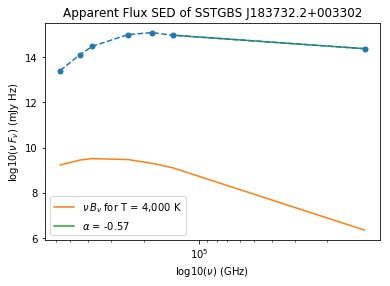

65
56666
COMPARISON OF FLUXES AND ERRORS CALCULATED BY DIFFERENT METHODS
[ 0.61335275  1.82702817  4.15648658 12.93267079 20.65855735 21.2811789 ]
[ 0.613353   1.8270273  4.1564884 12.932665  20.658558  21.281183 ]
[0.04271925 0.03354667 0.21648086 0.30124061 0.48119962 0.41562094]
[0.04271928 0.03354658 0.21648094 0.2977856  0.2977856  0.2977856 ]
Signal to Noise
[14.35776029 54.46228623 19.20025013 42.93136635 42.93136635 51.20333653]
[14.357757 54.4624   19.20025  43.429447 69.37393  71.46478 ]
14.357757 54.462402 19.20025
****************************************************************
The GB index 3346
RA:  279.387781857256
DEC:  0.4429629595360854
The difference in RA is  0.031 arcseconds
The difference in Dec is  0.087 arcseconds
The Gould_Belt_ID is  SSTGBS J183733.1+002635
alpha is -0.63
2MASS ID: b'18373306+0026347'
FLUX SIGNAL TO NOISE
[14.35775687 54.46239883 19.2002511  43.4294487  69.37392943 71.46478047
 20.63492063  1.         20.63492063  1.         10.73289902]
SED Fl

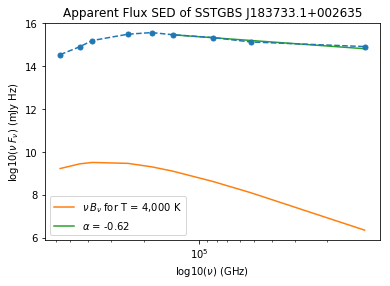

66
56656
COMPARISON OF FLUXES AND ERRORS CALCULATED BY DIFFERENT METHODS
[ 75.50298946 107.48319842 152.62022685 211.68406241 176.48174852
 134.89496149]
[ 75.50302 107.48322 152.62027 211.68411 176.48177 134.89499]
[0.1109241  0.02693292 0.13483387 4.93075531 4.27719659 3.3966154 ]
[0.11092291 0.02692719 0.13483995 4.874207   4.874207   4.874207  ]
Signal to Noise
[ 680.67254303 3990.77445302 1131.91308888   42.93136635   41.26107949
   39.71452329]
[ 680.6801   3991.6248   1131.8624     43.429447   36.20728    27.675268]
680.6801 3991.6248 1131.8623
****************************************************************
The GB index 3366
RA:  279.42756104838594
DEC:  0.48047163835068896
The difference in RA is  0.065 arcseconds
The difference in Dec is  0.132 arcseconds
The Gould_Belt_ID is  SSTGBS J183742.6+002850
alpha is -2.35
2MASS ID: b'18374261+0028498'
FLUX SIGNAL TO NOISE
[6.80680132e+02 3.99162476e+03 1.13186239e+03 4.34294464e+01
 3.62072774e+01 2.76752687e+01 1.74022346e+01 1.000

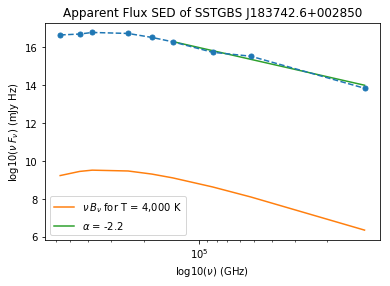

67
56710
COMPARISON OF FLUXES AND ERRORS CALCULATED BY DIFFERENT METHODS
[0.05201816 0.19509236 0.46162723 1.25686365 1.75509234 1.28468173]
[0.05201815 0.19509241 0.461627   1.2568642  1.7550931  1.284682  ]
[0.001963   0.00036364 0.00472424 0.06896734 0.08949818 0.08934616]
[0.001963   0.00036364 0.00472425 0.06714165 0.06714165 0.06714165]
Signal to Noise
[ 26.49926761 536.49320826  97.71465788  18.22404173  19.61036997
  14.37870145]
[ 26.499268 536.50385   97.71436   18.71959   26.140154  19.133905]
26.499268 536.50385 97.71436
****************************************************************
The GB index 3369
RA:  279.43432347474663
DEC:  0.4025944507239772
The difference in RA is  0.006 arcseconds
The difference in Dec is  0.2 arcseconds
The Gould_Belt_ID is  SSTGBS J183744.2+002410
alpha is -1.81
2MASS ID: b'18374423+0024096'
FLUX SIGNAL TO NOISE
[ 26.499268   536.50384006  97.71436322  18.71958986  26.14015358
  19.13390563  18.94252874  18.08080808  18.94252874   1.81693989
  

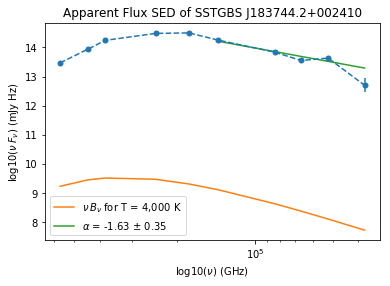

68
56479
COMPARISON OF FLUXES AND ERRORS CALCULATED BY DIFFERENT METHODS
[0.09597591 0.10503865 0.34952208 2.08779766 2.78419811 2.81835323]
[0.09597593 0.10503862 0.34952202 2.0877967  2.7841976  2.818354  ]
[0.02545662 0.00056192 0.00767751 0.12065659 0.1500723  0.17663709]
[0.02545663 0.00056192 0.00767753 0.11729885 0.11729885 0.11729885]
Signal to Noise
[  3.77017446 186.92860929  45.52543377  17.30363565  18.55237829
  15.95561402]
[  3.7701743 186.92906    45.525345   17.798952   23.735933   24.027122 ]
3.770174 186.92906 45.525345
****************************************************************
The GB index 3372
RA:  279.44504484623263
DEC:  0.5925652805502504
The difference in RA is  0.016 arcseconds
The difference in Dec is  0.099 arcseconds
The Gould_Belt_ID is  SSTGBS J183746.8+003533
alpha is -1.35
2MASS ID: b'18374680+0035332'
FLUX SIGNAL TO NOISE
[  3.77017418 186.92905831  45.52534432  17.79895291  23.73593257
  24.02712317  18.07692308   1.          18.07692308   1.
  

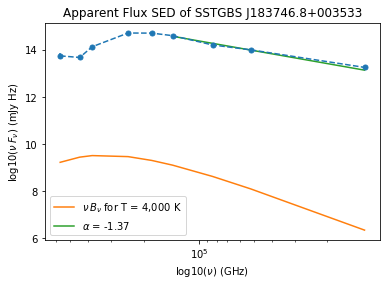

69
54649
COMPARISON OF FLUXES AND ERRORS CALCULATED BY DIFFERENT METHODS
[ 0.20499231  0.73209615  1.80834758  7.99628894 12.14227667 10.20458972]
[ 0.20499222  0.73209643  1.8083483   7.996292   12.142282   10.204595  ]
[0.01313725 0.00459997 0.0335156  0.23918276 0.40935319 0.35374798]
[0.01313724 0.00459997 0.03351569 0.23567545 0.23567545 0.23567545]
Signal to Noise
[ 15.60389747 159.15246672  53.95540425  33.43171084  29.66210337
  28.84706117]
[ 15.603901 159.15256   53.95528   33.929253  51.5212    43.299355]
15.603901 159.15256 53.95528
****************************************************************
The GB index 3375
RA:  279.45014662659435
DEC:  -0.2715059066943372
The difference in RA is  0.048 arcseconds
The difference in Dec is  0.268 arcseconds
The Gould_Belt_ID is  SSTGBS J183748.0+000-1617
alpha is -1.23
2MASS ID: b'18374802-0016170'
FLUX SIGNAL TO NOISE
[ 15.60390092 159.15255509  53.95527898  33.92925302  51.52119713
  43.2993527   20.32258065  20.33653846  20.3225806

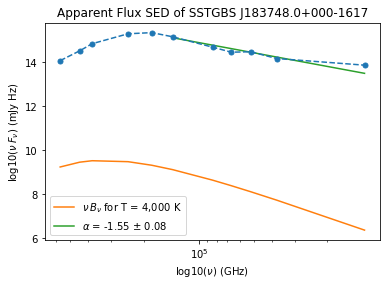

70
56913
71
51667
COMPARISON OF FLUXES AND ERRORS CALCULATED BY DIFFERENT METHODS
[0.01708151 0.04360138 0.13421704 0.96491329 1.36489759 1.1127446 ]
[0.01708151 0.04360138 0.13421698 0.9649135  1.364898   1.1127441 ]
[0.00491858 0.00023453 0.00547264 0.06900993 0.10301457 0.11298731]
[0.00491858 0.00023453 0.00547265 0.06665387 0.06665387 0.06665387]
Signal to Noise
[  3.47285183 185.90948826  24.52508052  13.98223816  13.24955857
   9.84840292]
[  3.472852 185.90782   24.525051  14.476481  20.4774    16.694366]
3.472852 185.90784 24.525051
****************************************************************
The GB index 3406
RA:  279.48389889127253
DEC:  -0.3415313111456956
The difference in RA is  0.018 arcseconds
The difference in Dec is  0.254 arcseconds
The Gould_Belt_ID is  SSTGBS J183756.1+000-2029
alpha is -1.74
2MASS ID: b'18375612-0020291'
FLUX SIGNAL TO NOISE
[  3.47285198 185.90782353  24.52505054  14.47648106  20.47740012
  16.69436587  19.85680191  18.84057971  19.85680191  

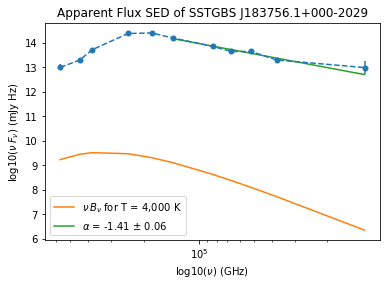

72
51542
COMPARISON OF FLUXES AND ERRORS CALCULATED BY DIFFERENT METHODS
[0.02303169 0.04078189 0.12898638 0.97294483 1.11866447 1.158766  ]
[0.0230317  0.0407819  0.12898643 0.9729444  1.1186639  1.1587663 ]
[0.00430165 0.0002201  0.00475759 0.06288453 0.10004404 0.0955176 ]
[0.00430165 0.0002201  0.00475759 0.06093582 0.06093582 0.06093582]
Signal to Noise
[  5.35415246 185.28533892  27.11171414  15.47192688  11.18171971
  12.13143922]
[  5.354151 185.28528   27.111694  15.966707  18.358068  19.016176]
5.354151 185.28528 27.111694
****************************************************************
The GB index 3417
RA:  279.4923836198011
DEC:  -0.39197243585457325
The difference in RA is  0.119 arcseconds
The difference in Dec is  0.162 arcseconds
The Gould_Belt_ID is  SSTGBS J183758.2+000-2331
alpha is -0.6
2MASS ID: b'18375816-0023310'
FLUX SIGNAL TO NOISE
[  5.354151   185.28527399  27.11169494  15.96670753  18.35806837
  19.0161766   19.60893855  15.69620253  19.60893855   2.8983957

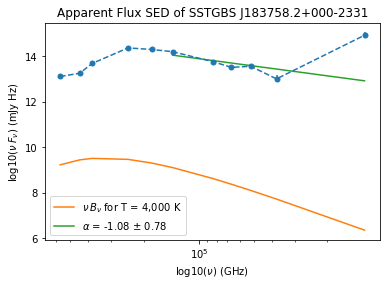

73
57219
COMPARISON OF FLUXES AND ERRORS CALCULATED BY DIFFERENT METHODS
[0.06914627 0.31983114 0.80773152 3.50661669 5.05242502 4.35306821]
[0.06914627 0.319831   0.80773133 3.5066175  5.0524273  4.3530674 ]
[0.00504087 0.00072113 0.00522474 0.11821875 0.19443983 0.17586038]
[0.00504087 0.00072112 0.00522474 0.1162697  0.1162697  0.1162697 ]
Signal to Noise
[ 13.71714153 443.51316905 154.59736807  29.66210337  25.98451691
  24.75297861]
[ 13.717131 443.5213   154.59747   30.159342  43.454376  37.439396]
13.717131 443.52127 154.59747
****************************************************************
The GB index 3435
RA:  279.5197148916612
DEC:  0.7441423868430713
The difference in RA is  0.23 arcseconds
The difference in Dec is  0.265 arcseconds
The Gould_Belt_ID is  SSTGBS J183804.7+004439
alpha is -1.59
2MASS ID: b'18380474+0044390'
FLUX SIGNAL TO NOISE
[ 13.71713093 443.52129883 154.59747238  30.15934108  43.45437618
  37.43939642   1.           1.           1.           1.
   5.2475

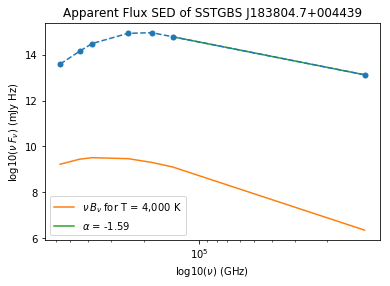

74
51872
COMPARISON OF FLUXES AND ERRORS CALCULATED BY DIFFERENT METHODS
[0.01082778 0.05926318 0.19905606 1.38448535 2.24853677 2.11249424]
[0.01082778 0.05926316 0.19905601 1.3844848  2.2485363  2.1124952 ]
[0.00286495 0.00029751 0.01326387 0.06926009 0.11683818 0.1303315 ]
[0.00286495 0.00029751 0.01326387 0.06758335 0.06758335 0.06758335]
Signal to Noise
[  3.77939778 199.19756102  15.00739334  19.98965675  19.2448796
  16.20862317]
[  3.7793982 199.19688    15.007386   20.485588   33.270565   31.257626 ]
3.779398 199.19688 15.007385
****************************************************************
The GB index 3465
RA:  279.56380807438825
DEC:  -0.359721558091634
The difference in RA is  0.011 arcseconds
The difference in Dec is  0.071 arcseconds
The Gould_Belt_ID is  SSTGBS J183815.3+000-2135
alpha is -1.25
2MASS ID: b'18381531-0021350'
FLUX SIGNAL TO NOISE
[  3.77939811 199.19688229  15.00738577  20.48558884  33.27056547
  31.25762649  19.16859122  19.37669377  19.16859122  16.44

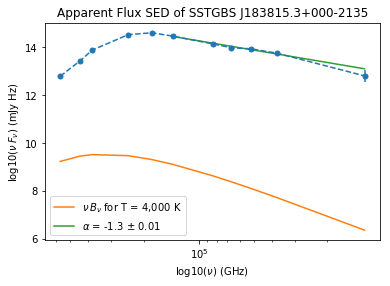

75
57159
COMPARISON OF FLUXES AND ERRORS CALCULATED BY DIFFERENT METHODS
[0.01174411 0.12849034 0.38819262 2.35336045 3.71791797 4.07751373]
[0.0117441  0.12849036 0.38819262 2.3533595  3.7179189  4.0775137 ]
[0.002591   0.00129363 0.0120263  0.08607006 0.12888377 0.1569209 ]
[0.00259099 0.00129364 0.01202631 0.08453345 0.08453345 0.08453345]
Signal to Noise
[ 4.53266287 99.32519372 32.27864953 27.34238259 28.84706117 25.98451691]
[ 4.532664 99.32462  32.278606 27.839388 43.981632 48.235508]
4.532664 99.324615 32.278606
****************************************************************
The GB index 3478
RA:  279.59830455650985
DEC:  0.8523970128544923
The difference in RA is  0.072 arcseconds
The difference in Dec is  0.27 arcseconds
The Gould_Belt_ID is  SSTGBS J183823.6+005109
alpha is -1.02
2MASS ID: b'18382359+0051087'
FLUX SIGNAL TO NOISE
[ 4.53266364 99.32461938 32.27860455 27.83938885 43.98163176 48.23550807
  1.          1.          1.          1.          8.57768053]
SED Flux
[ 

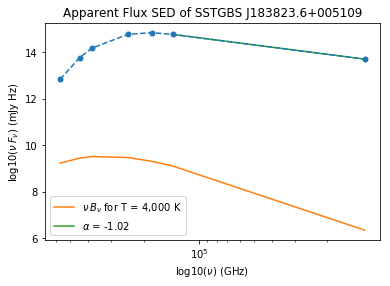

76
56866
COMPARISON OF FLUXES AND ERRORS CALCULATED BY DIFFERENT METHODS
[122.53872769 128.04891127 219.32326638 319.2186092  250.89949417
 190.89549106]
[122.53873 128.04886 219.32332 319.2187  250.89943 190.89545]
[2.17629252 0.13622147 4.57604095 6.53422356 5.84420007 3.54901207]
[2.1762943  0.13622367 4.5760293  6.468248   6.468248   6.468248  ]
Signal to Noise
[ 56.30618431 940.00536226  47.92860656  48.85333449  42.93136635
  53.7883465 ]
[ 56.306137 939.98975   47.92874   49.351646  38.789394  29.512697]
56.306137 939.98975 47.928738
****************************************************************
The GB index 3488
RA:  279.6340291439558
DEC:  0.7408494598774539
The difference in RA is  0.428 arcseconds
The difference in Dec is  0.056 arcseconds
The Gould_Belt_ID is  SSTGBS J183832.1+004427
alpha is -2.17
2MASS ID: b'18383214+0044271'
FLUX SIGNAL TO NOISE
[ 56.30613713 939.98976133  47.92873998  49.35164737  38.78939607
  29.51269803  16.56074766   1.          16.56074766   1.
 

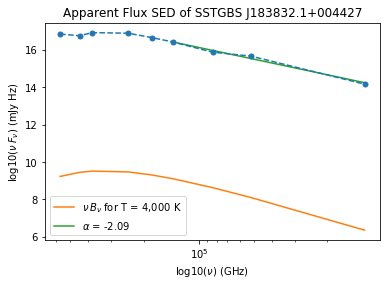

77
56967
COMPARISON OF FLUXES AND ERRORS CALCULATED BY DIFFERENT METHODS
[0.03711655 0.25389966 0.71160294 3.53580435 5.62730053 5.40500022]
[0.03711655 0.25389972 0.7116026  3.5358028  5.627302   5.405     ]
[0.00276055 0.00064133 0.0108006  0.11583792 0.17366266 0.16167286]
[0.00276055 0.00064134 0.01080056 0.11398081 0.11398081 0.11398081]
Signal to Noise
[ 13.44535053 395.89446968  65.88549803  30.52372059  32.4036301
  33.43171084]
[ 13.445348 395.88885   65.88572   31.021034  49.37061   47.42026 ]
13.445348 395.88885 65.88572
****************************************************************
The GB index 3489
RA:  279.6352128856142
DEC:  0.7541730458609259
The difference in RA is  0.085 arcseconds
The difference in Dec is  0.151 arcseconds
The Gould_Belt_ID is  SSTGBS J183832.5+004515
alpha is -0.91
2MASS ID: b'18383245+0045151'
FLUX SIGNAL TO NOISE
[ 13.44534802 395.88886014  65.8857216   31.02103496  49.37060837
  47.42026295  20.10869565   1.          20.10869565   1.
  10.30721

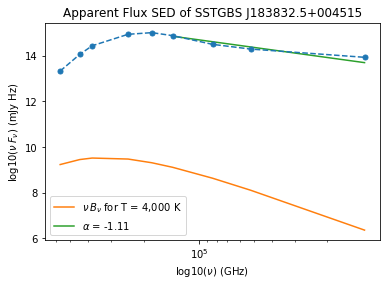

78
51619
COMPARISON OF FLUXES AND ERRORS CALCULATED BY DIFFERENT METHODS
[0.01608643 0.12698039 0.41432112 2.48707131 3.19963282 3.12173079]
[0.01608642 0.12698033 0.41432112 2.4870725  3.199632   3.1217294 ]
[0.00151433 0.00042244 0.00553396 0.07439258 0.12007715 0.11417186]
[0.00151432 0.00042243 0.00553395 0.07330171 0.07330171 0.07330171]
Signal to Noise
[ 10.6228348  300.59153799  74.8688724   33.43171084  26.64647577
  27.34238259]
[ 10.622834 300.5956    74.86903   33.929256  43.65017   42.587402]
10.622835 300.5956 74.86903
****************************************************************
The GB index 3512
RA:  279.6944761510876
DEC:  -0.4302043796431921
The difference in RA is  0.047 arcseconds
The difference in Dec is  0.136 arcseconds
The Gould_Belt_ID is  SSTGBS J183846.7+000-2549
alpha is -1.53
2MASS ID: b'18384667-0025486'
FLUX SIGNAL TO NOISE
[ 10.62283459 300.59562096  74.86903168  33.92925569  43.65016752
  42.58740166  19.79899497  20.42253521  19.79899497  17.45350501

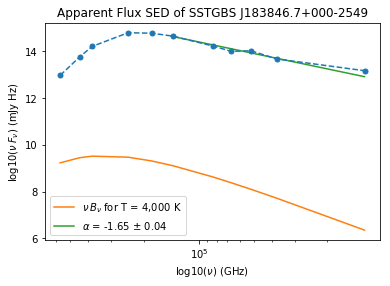

79
54801
COMPARISON OF FLUXES AND ERRORS CALCULATED BY DIFFERENT METHODS
[0.00831548 0.07962922 0.23795991 1.48760762 2.1892728  1.97512939]
[0.00831547 0.07962924 0.2379599  1.4876082  2.1892729  1.9751298 ]
[0.00172286 0.00030497 0.00463324 0.05298706 0.09474709 0.09118096]
[0.00172285 0.00030497 0.00463325 0.05206523 0.05206523 0.05206523]
Signal to Noise
[  4.82656725 261.10774123  51.35924559  28.07492286  23.10649145
  21.66164307]
[  4.8265676 261.1093     51.359177   28.572006   42.048653   37.935677 ]
4.8265676 261.1093 51.359173
****************************************************************
The GB index 3530
RA:  279.7188923957327
DEC:  -0.07835774164619097
The difference in RA is  0.017 arcseconds
The difference in Dec is  0.246 arcseconds
The Gould_Belt_ID is  SSTGBS J183852.5+000-442
alpha is -1.19
2MASS ID: b'18385254-0004418'
FLUX SIGNAL TO NOISE
[  4.8265677  261.10931245  51.35917492  28.57200596  42.04865101
  37.93567544  19.65317919  19.7761194   19.65317919  13.3

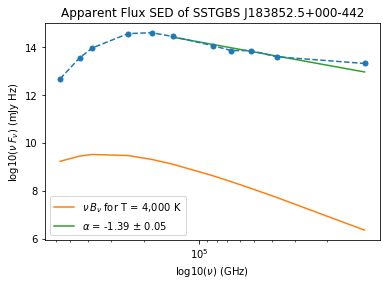

80
57296
COMPARISON OF FLUXES AND ERRORS CALCULATED BY DIFFERENT METHODS
[0.0332424  0.21486331 0.60712047 3.5816917  5.0664059  4.98879616]
[0.03324242 0.2148634  0.60712063 3.5816903  5.066404   4.9887953 ]
[0.00241976 0.00382735 0.03338088 0.11393589 0.14674121 0.13032914]
[0.00241976 0.00382735 0.03338093 0.1121612  0.1121612  0.1121612 ]
Signal to Noise
[13.7378755  56.13887841 18.18767099 31.43602561 34.52612842 38.27844089]
[13.73787  56.138916 18.18765  31.933418 45.17074  44.478798]
13.73787 56.138912 18.187653
****************************************************************
The GB index 3549
RA:  279.7630502739988
DEC:  0.8721223559850535
The difference in RA is  0.284 arcseconds
The difference in Dec is  0.265 arcseconds
The Gould_Belt_ID is  SSTGBS J183903.1+005220
alpha is -1.11
2MASS ID: b'18390311+0052197'
FLUX SIGNAL TO NOISE
[13.73787015 56.13891465 18.18765122 31.93341739 45.17073651 44.47879859
  1.          1.          1.          1.          8.18376068]
SED Flux
[ 

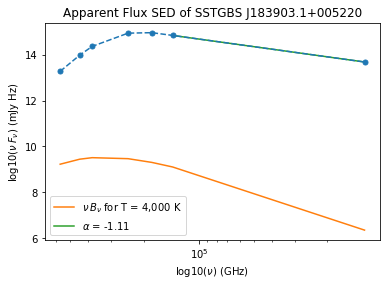

81
56093
COMPARISON OF FLUXES AND ERRORS CALCULATED BY DIFFERENT METHODS
[0.01565753 0.10222411 0.30698168 1.63714984 2.12960956 2.09312633]
[0.01565754 0.10222416 0.30698162 1.6371496  2.1296086  2.0931268 ]
[0.00350479 0.00066861 0.01624301 0.06770902 0.0880761  0.10066563]
[0.00350479 0.00066862 0.016243   0.0663463  0.0663463  0.0663463 ]
Signal to Noise
[  4.46746736 152.88986974  18.89930631  24.1792      24.1792
  20.79285984]
[  4.4674673 152.88922    18.899315   24.675823   32.098377   31.548506 ]
4.4674673 152.88922 18.899315
****************************************************************
The GB index 3625
RA:  279.9477053253108
DEC:  0.4896973059229912
The difference in RA is  0.098 arcseconds
The difference in Dec is  0.104 arcseconds
The Gould_Belt_ID is  SSTGBS J183947.5+002923
alpha is -1.54
2MASS ID: b'18394744+0029230'
FLUX SIGNAL TO NOISE
[  4.4674674  152.88921854  18.89931421  24.67582228  32.09837695
  31.54850671  19.04191617  20.35541195  19.04191617  17.4576271

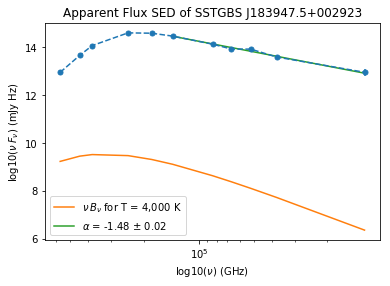

In [159]:
#DETERMINE WHICH S+D COULD BE YSOs
classI_ysos = np.array([])
classII_ysos = np.array([])
classIII_ysos = np.array([])
classIII_ysos_noerr = np.array([])
flat_ysos = np.array([])
sd_stars = np.array([])
notYSOs = np.array([59418,35960,32502,56913])
SD_id_vals = SD_ALL['id']
alphas = np.array([])
alpha_errs = np.array([])
for i in range(len(SD_id_vals)):
    print(i)
    id_val = int(SD_id_vals[i])
    print(id_val)
    if (id_val != 59418 and id_val != 35960 and id_val != 32502 and id_val != 56913):
        Values = SEDCreator(id_val,SD_match,'S+D','Star+Dust_SEDS',0,0)
        alphas = np.append(alphas,Values['alpha'])
        alpha_errs = np.append(alpha_errs, Values['alpha_e'])
        if (Values['alpha'] > 0.3):
            classI_ysos = np.append(classI_ysos,id_val)
        elif (Values['alpha'] < 0.3 and Values['alpha'] > -0.3):
            flat_ysos = np.append(flat_ysos,id_val)
        elif (Values['alpha'] < -0.3 and Values['alpha'] > -1.6):
            classII_ysos = np.append(classII_ysos,id_val)
        elif (Values['alpha'] < -1.6 and Values['alpha']-Values['alpha_e'] > -2.5 and Values['alpha_e'] > -1):
            classIII_ysos = np.append(classIII_ysos,id_val)
        elif (Values['alpha'] < -1.6 and Values['alpha'] > -2.5 and Values['alpha_e'] == -1):
            classIII_ysos_noerr = np.append(classIII_ysos_noerr,id_val)
        #else:
        #   sd_stars = np.append(sd_stars,id_val)
        elif (Values['alpha'] < -1.6 and Values['alpha'] > -2.5 and Values['alpha_e'] > -1):
                sd_stars = np.append(sd_stars,id_val)
            

In [160]:
print(alphas)
print(alpha_errs)
print('The total number of YSOs is:',len(SD_id_vals))
print('Number of YSOs that wont plot for some reason:',len(notYSOs))
print('Number of Class I YSOs:',len(classI_ysos))
print('Number of Class II YSOs:',len(classII_ysos))
print('Number of Class III YSOs:',len(classIII_ysos))
print('Number of Class III YSOs that have no error:',len(classIII_ysos_noerr))
print('Number of flat YSOs:',len(flat_ysos))
print('Number of stars:',len(sd_stars))

[-0.57928515 -0.61449587 -1.23492899 -2.74120738 -1.37147598 -1.65984265
 -1.81735757 -0.94740903 -1.37218034 -1.15177486 -1.07383546 -0.65462443
 -2.15983443 -1.02168748 -1.06937907 -1.37108766 -2.25276238 -0.98262219
 -1.42617071 -0.53266242 -1.26554831 -1.28816717 -2.30964367 -1.6214797
 -1.84397874 -0.96653735 -0.91218857 -1.85816197 -0.40575146 -1.80515819
 -1.57198008 -1.82405003 -1.18448613 -1.28963409 -1.74546962 -0.79852891
 -0.34785889 -1.8049417  -1.22918527 -2.42071673 -1.95379731 -1.04062494
 -1.89527804 -2.01529115 -1.94818096 -1.35236235 -0.93342978 -0.93499438
 -1.76908527 -1.1326057  -1.32020312 -2.18420393 -0.85945211 -2.42353611
 -2.16604292 -2.13128728 -1.47104889 -1.1465199  -1.73399045 -2.09450816
 -1.80489193 -0.57164578 -0.62225725 -2.20441951 -1.62970071 -1.37478506
 -1.55158942 -1.40616752 -1.08166204 -1.58813282 -1.29703943 -1.0164022
 -2.09043844 -1.10885954 -1.64507541 -1.39243413 -1.11005213 -1.48053259]
[-1.         -1.         -1.          0.19148947  0.

Number of All matches in the correct distance interval: 9
Number of _match with parallax > 5, 10, 20:  5 2 1
For all stars in region
The mean velocity in ra is  7.9420929001292615 +/- 2.2315818345656577
The mean velocity in dec is  -13.698033622379306 +/- 3.2234950174206127
The median velocity in ra is  5.9053894524136386 +/- 2.7968730618375983
The median velocity in dec is  -16.27799036027799 +/- 4.040051876899328
The mean magnitude of velocity is 18.743244213017654 +/- 2.0478080321973624
The median magnitude of velocity is 19.78608409288267 +/- 2.566546757261189
The standard deviation of velocity is 6.143424096592087
The median parallax is 2.434229125038176 with a standard deviation of 0.3137511976230696
The median distance is 410.8076720116957 with a standard deviation of 59.634993452787434
For parallax S/N > 10 stars:
The mean velocity in ra is  14.739259491581166 +/- 6.083699061841383
The mean velocity in dec is  -4.937708303517673 +/- 10.036252767993536
The median velocity in ra 

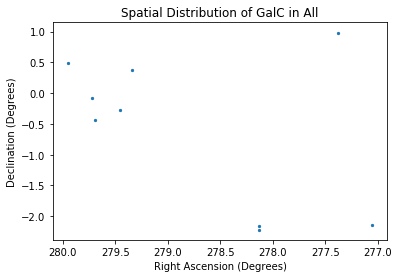

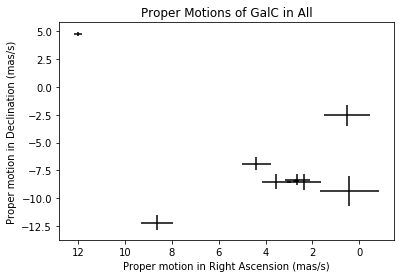

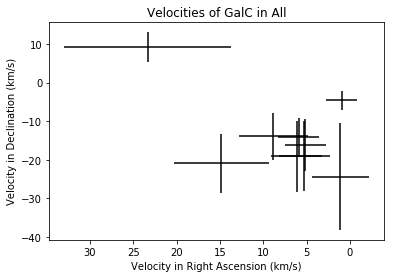

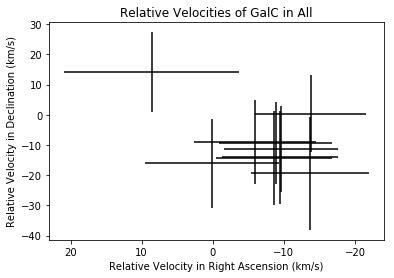

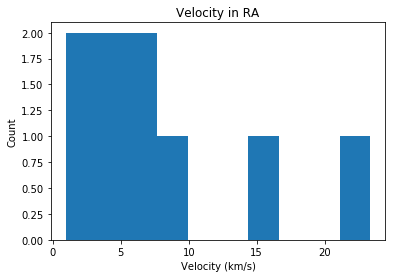

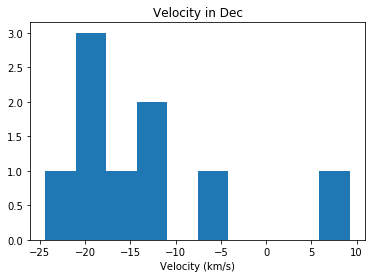

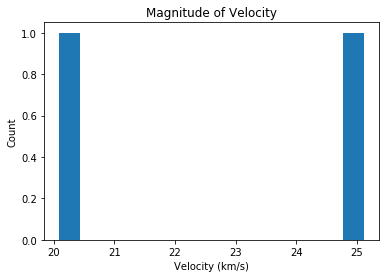

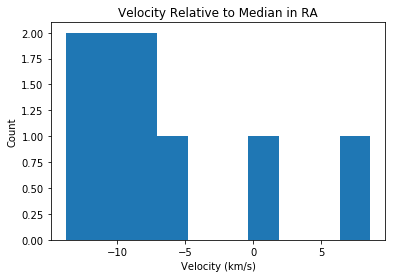

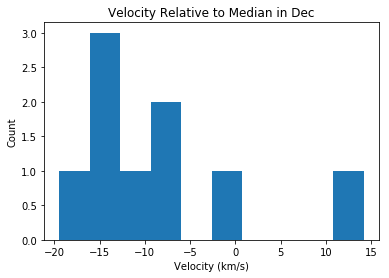

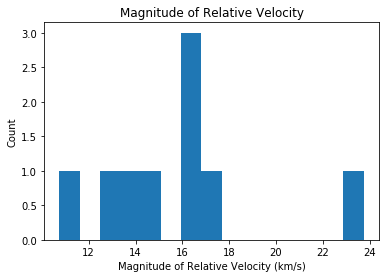

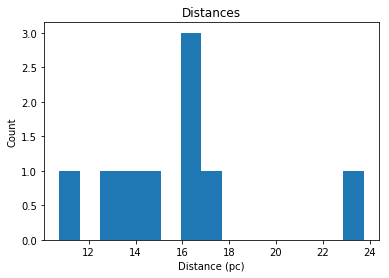

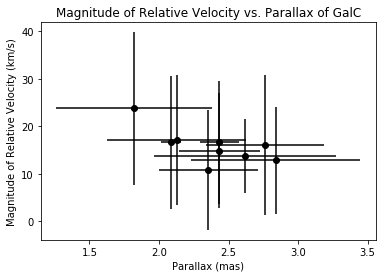

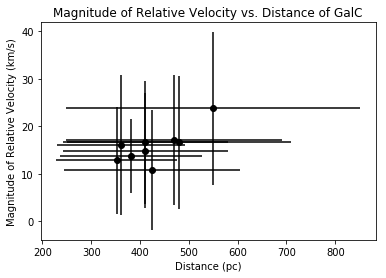

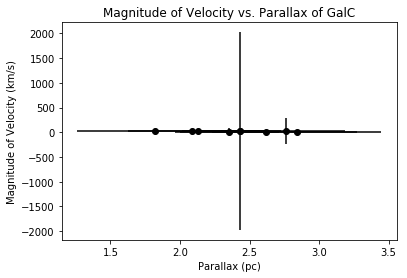

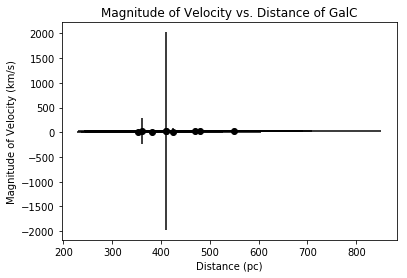

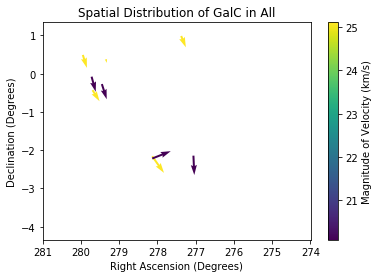

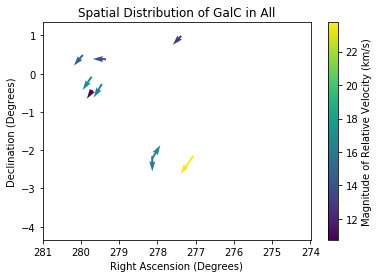

In [136]:
#ALL GALC
GALC_ALL = CalculateProperties('All','GalC',GALC_match,Gvalues,distance_range=[350.,550.])

Number of All matches in the correct distance interval: 147
Number of _match with parallax > 5, 10, 20:  135 86 43
For all stars in region
The mean velocity in ra is  5.088614554878728 +/- 0.263163713731217
The mean velocity in dec is  -15.883223357672083 +/- 0.47228346954285033
The median velocity in ra is  5.945705108420212 +/- 0.3298268028477835
The median velocity in dec is  -16.976615792259537 +/- 0.5919195491984688
The mean magnitude of velocity is 17.532150680395958 +/- 0.30598982647783296
The median magnitude of velocity is 18.145427185349604 +/- 0.3835013753993848
The standard deviation of velocity is 3.7099294824115385
The median parallax is 2.23829890655066 with a standard deviation of 0.2316646427527986
The median distance is 446.7678544064761 with a standard deviation of 46.46531915646724
For parallax S/N > 10 stars:
The mean velocity in ra is  5.366214797096912 +/- 0.3413222154945661
The mean velocity in dec is  -15.452831767729315 +/- 0.7538078148492561
The median veloci

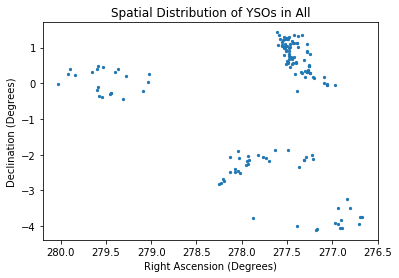

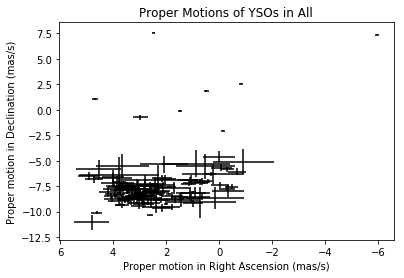

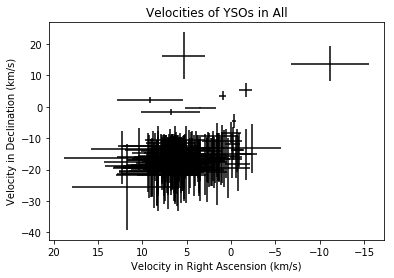

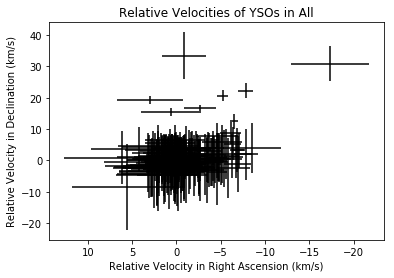

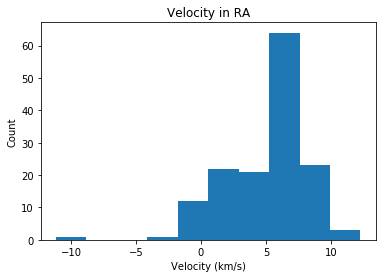

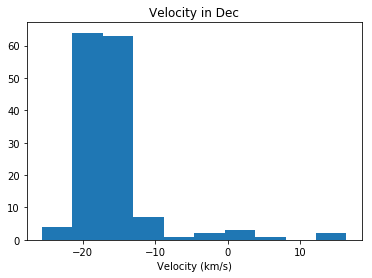

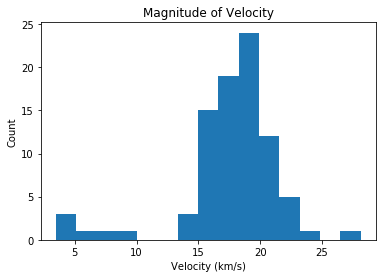

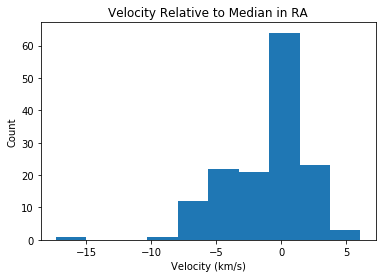

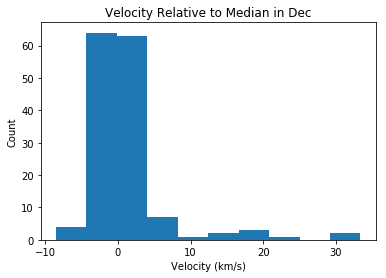

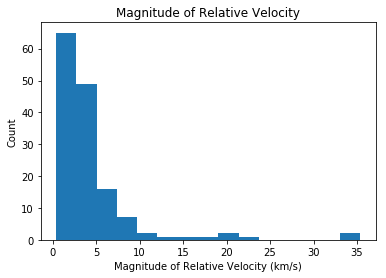

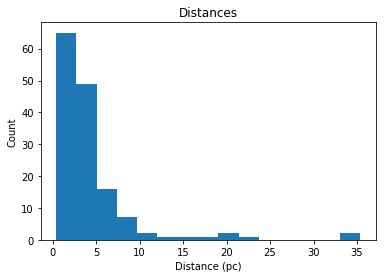

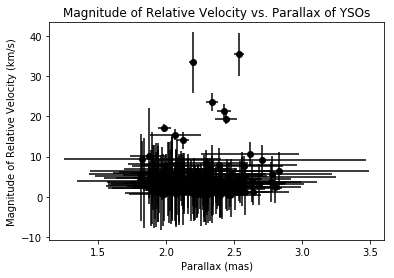

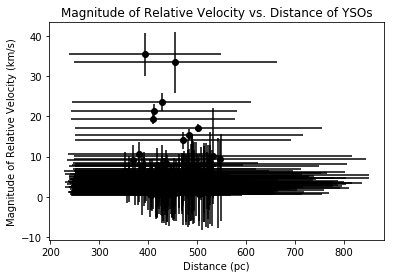

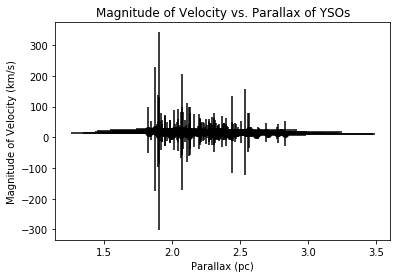

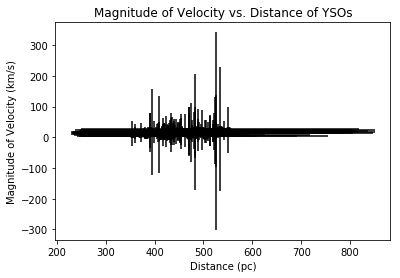

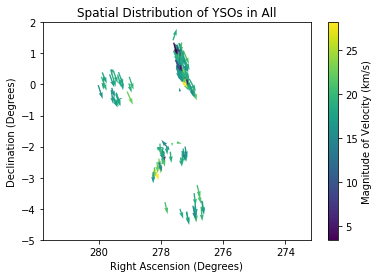

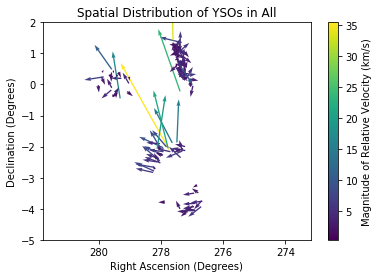

In [17]:
#All YSOs
adj1 = [0,0,0,0]
adj=[1,6,1,6]
YSO_ALL = CalculateProperties('All','YSOs',YSO_match,Gvalues,distance_range=[350.,550.])

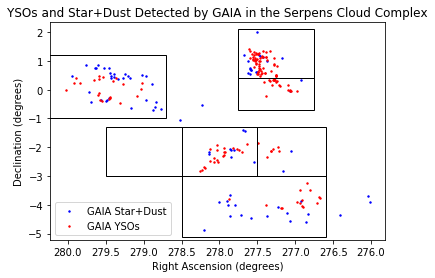

In [18]:
#Plot of YSOs and star +dust in GAIA
figure = plt.figure()
plt.scatter(SD_ALL['ra'],SD_ALL['dec'],c='b',s=2,label='GAIA Star+Dust')
plt.scatter(YSO_ALL['ra'],YSO_ALL['dec'],c='r',s=2,label='GAIA YSOs')
plt.xlabel('Right Ascension (degrees)')
plt.ylabel('Declination (degrees)')
plt.title('YSOs and Star+Dust Detected by GAIA in the Serpens Cloud Complex')
plt.legend()
plt.gca().add_patch(Rectangle((ra_min1,dec_min1),width1,height1,fill=False))
plt.gca().add_patch(Rectangle((ra_minW40,dec_minW40),widthW40,heightW40,fill=False))
plt.gca().add_patch(Rectangle((ra_minS,dec_minS),widthS,heightS,fill=False))
plt.gca().add_patch(Rectangle((ra_min2d,dec_min2d),width2d,height2d,fill=False))
plt.gca().add_patch(Rectangle((ra_min3u,dec_min3u),width3u,height3u,fill=False))
plt.gca().add_patch(Rectangle((ra_min3d,dec_min3d),width3d,height3d,fill=False))
plt.gca().add_patch(Rectangle((sky_regionW40side[0],sky_regionW40side[2]),widthW40,heightW40,fill=False))
plt.gca().invert_xaxis()
plt.savefig('Figures/StarPlots/YSO_SD_plot.png',dpi=600)
plt.show()

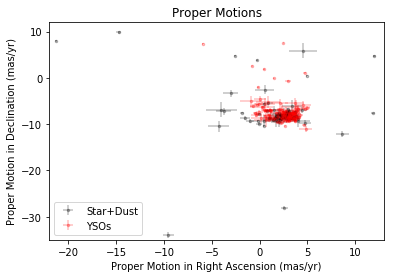

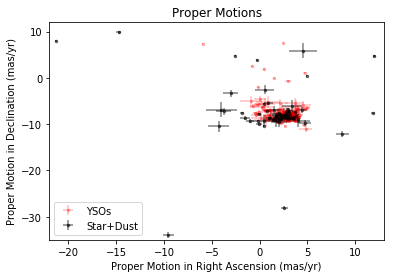

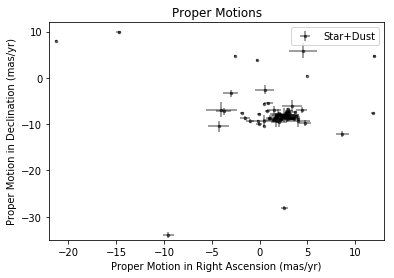

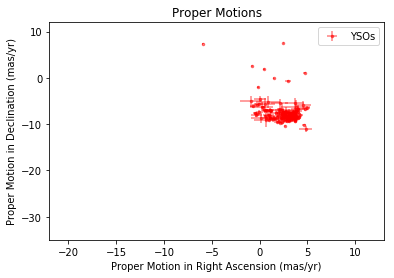

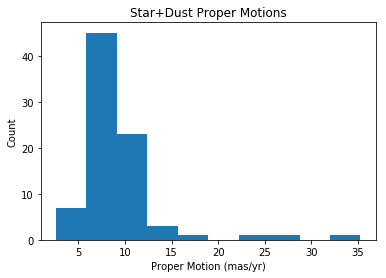

There are  147 YSOs with a median proper motion of  8.563309527433125 and stdev of 1.6209497367581411


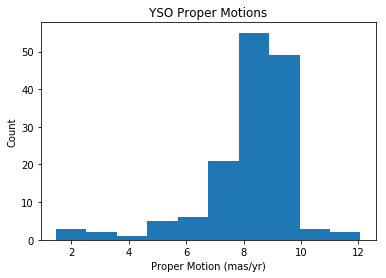

There are  82 S+D with a median proper motion of  8.834054811059719 and stdev of 4.376226101376523


In [19]:
#Plot of proper motions

plt.errorbar(SD_ALL['pmra'],SD_ALL['pmdec'],yerr = SD_ALL['pmdec_e'],xerr=SD_ALL['pmra_e'],linestyle='None'\
            ,color='black',label='Star+Dust',marker='o',markersize=2.5,alpha=0.25)
plt.errorbar(YSO_ALL['pmra'],YSO_ALL['pmdec'],yerr = YSO_ALL['pmdec_e'],xerr=YSO_ALL['pmra_e'],linestyle='None'\
            ,color='red',label='YSOs',marker='o',markersize=2.5,alpha=0.25)
plt.xlabel('Proper Motion in Right Ascension (mas/yr)')
plt.ylabel('Proper Motion in Declination (mas/yr)')
plt.title('Proper Motions')
plt.xlim(-22,13)
plt.ylim(-35,12)
plt.legend()
plt.savefig('Figures/proper_motions_all.png',dpi=300)
plt.show()

plt.errorbar(YSO_ALL['pmra'],YSO_ALL['pmdec'],yerr = YSO_ALL['pmdec_e'],xerr=YSO_ALL['pmra_e'],linestyle='None'\
            ,color='red',label='YSOs',marker='o',markersize=2.5,alpha=0.25)
plt.errorbar(SD_ALL['pmra'],SD_ALL['pmdec'],yerr = SD_ALL['pmdec_e'],xerr=SD_ALL['pmra_e'],linestyle='None'\
            ,color='black',label='Star+Dust',marker='o',markersize=2.5,alpha=0.5)
plt.xlabel('Proper Motion in Right Ascension (mas/yr)')
plt.ylabel('Proper Motion in Declination (mas/yr)')
plt.title('Proper Motions')
plt.xlim(-22,13)
plt.ylim(-35,12)
plt.legend()
plt.savefig('Figures/proper_motions_all2.png',dpi=300)
plt.show()

plt.errorbar(SD_ALL['pmra'],SD_ALL['pmdec'],yerr = SD_ALL['pmdec_e'],xerr=SD_ALL['pmra_e'],linestyle='None'\
            ,color='black',label='Star+Dust',marker='o',markersize=2.5,alpha=0.5)
plt.xlabel('Proper Motion in Right Ascension (mas/yr)')
plt.ylabel('Proper Motion in Declination (mas/yr)')
plt.title('Proper Motions')
plt.xlim(-22,13)
plt.ylim(-35,12)
plt.legend()
plt.savefig('Figures/proper_motions_SD.png',dpi=300)
plt.show()

plt.errorbar(YSO_ALL['pmra'],YSO_ALL['pmdec'],yerr = YSO_ALL['pmdec_e'],xerr=YSO_ALL['pmra_e'],linestyle='None'\
            ,color='red',label='YSOs',marker='o',markersize=2.5,alpha=0.5)
plt.xlabel('Proper Motion in Right Ascension (mas/yr)')
plt.ylabel('Proper Motion in Declination (mas/yr)')
plt.title('Proper Motions')
plt.xlim(-22,13)
plt.ylim(-35,12)
plt.legend()
plt.savefig('Figures/proper_motions_YSO.png',dpi=300)
plt.show()

#histogram of proper motions
SD_pm = np.sqrt(np.square(SD_ALL['pmra'])+np.square(SD_ALL['pmdec']))
YSO_pm = np.sqrt(np.square(YSO_ALL['pmra'])+np.square(YSO_ALL['pmdec']))
plt.hist(SD_pm,bins=10)
plt.title('Star+Dust Proper Motions')
plt.xlabel('Proper Motion (mas/yr)')
plt.ylabel('Count')
plt.savefig('Figures/proper_motions_hist_YSO.png',dpi=300)
plt.show()
print('There are ',len(YSO_pm),'YSOs with a median proper motion of ',np.median(YSO_pm),'and stdev of',np.std(YSO_pm))

plt.hist(YSO_pm,bins=10)
plt.title('YSO Proper Motions')
plt.xlabel('Proper Motion (mas/yr)')
plt.ylabel('Count')
plt.savefig('Figures/proper_motions_hist_SD.png',dpi=300)
plt.show()
print('There are ',len(SD_pm),'S+D with a median proper motion of ',np.median(SD_pm),'and stdev of',np.std(SD_pm))


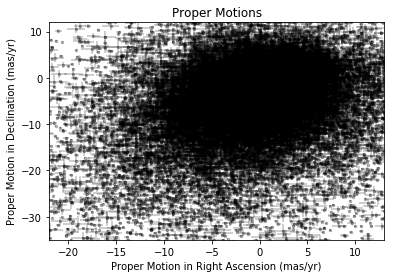

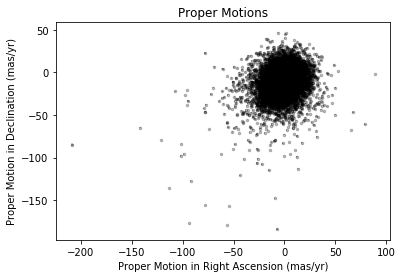

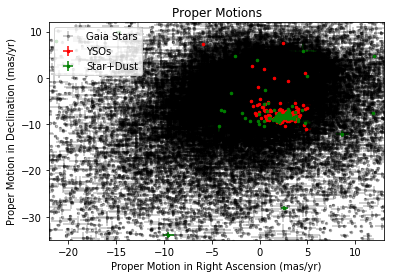

In [20]:
#i currently have no better idea how to filter using two conditions
Gdist2 = Gdist[Gdist >= 350]
Gpmra2 = Gpmra[Gdist >= 350]
Gpmdec2 = Gpmdec[Gdist >= 350]
Gpmra_e2 = Gpmra_e[Gdist >= 350]
Gpmdec_e2 = Gpmdec_e[Gdist >= 350]

#zoomed in plot
plt.errorbar(Gpmra2[Gdist2 <= 550],Gpmdec2[Gdist2 <= 550],yerr = Gpmdec_e2[Gdist2 <= 550],\
             xerr=Gpmra_e2[Gdist2 <= 550],linestyle='None'\
            ,color='black',marker='o',markersize=2.5,alpha=0.25)
plt.xlabel('Proper Motion in Right Ascension (mas/yr)')
plt.ylabel('Proper Motion in Declination (mas/yr)')
plt.title('Proper Motions')
plt.xlim(-22,13)
plt.ylim(-35,12)
plt.savefig('Figures/proper_motions_AllGaiaStars_zoom.png',dpi=300)
plt.show()

#all plot
plt.errorbar(Gpmra2[Gdist2 <= 550],Gpmdec2[Gdist2 <= 550],yerr = Gpmdec_e2[Gdist2 <= 550],\
             xerr=Gpmra_e2[Gdist2 <= 550],linestyle='None'\
            ,color='black',marker='o',markersize=2.5,alpha=0.25)
plt.xlabel('Proper Motion in Right Ascension (mas/yr)')
plt.ylabel('Proper Motion in Declination (mas/yr)')
plt.title('Proper Motions')
plt.savefig('Figures/proper_motions_AllGaiaStars.png',dpi=300)
plt.show()

#zoomed in plot with ysos and s+d overlapping
plt.errorbar(Gpmra2[Gdist2 <= 550],Gpmdec2[Gdist2 <= 550],yerr = Gpmdec_e2[Gdist2 <= 550],\
             xerr=Gpmra_e2[Gdist2 <= 550],linestyle='None'\
            ,color='black',label='Gaia Stars',marker='o',markersize=2.5,alpha=0.25)
plt.errorbar(YSO_ALL['pmra'],YSO_ALL['pmdec'],yerr = YSO_ALL['pmdec_e'],xerr=YSO_ALL['pmra_e'],linestyle='None'\
            ,color='red',label='YSOs',marker='o',markersize=2.5)
plt.errorbar(SD_ALL['pmra'],SD_ALL['pmdec'],yerr = SD_ALL['pmdec_e'],xerr=SD_ALL['pmra_e'],linestyle='None'\
            ,color='green',label='Star+Dust',marker='o',markersize=2.5)
plt.xlabel('Proper Motion in Right Ascension (mas/yr)')
plt.ylabel('Proper Motion in Declination (mas/yr)')
plt.title('Proper Motions')
plt.xlim(-22,13)
plt.ylim(-35,12)
plt.legend()
plt.savefig('Figures/proper_motions_AllGaiaStars_zoom2.png',dpi=300)
plt.show()

# Look at SEDs of proper motion outliers in ALL Regions Combined

There are 8 outliers


The index in region is  [[30]]
The GAIA list number is 3784
The outlier is at a distance of 490.78 +/- 240.86712483708362 pc
The proper motion magnitude is  [[41.20180845]] +/- [[8090.79956367]] km/s
plx [[2.03756389]]
parallax signal to noise [[19.85214615]]
COMPARISON OF FLUXES AND ERRORS CALCULATED BY DIFFERENT METHODS
[0.24409607 0.80779777 1.85535625 6.44597173 8.78819754 7.365386  ]
[0.24409601 0.8077974  1.8553557  6.4459715  8.788199   7.3653874 ]
[0.00459911 0.00081149 0.01161991 0.17449178 0.28791371 0.30461661]
[0.00459911 0.00081152 0.01161989 0.17217182 0.17217182 0.17217182]
Signal to Noise
[ 53.07465062 995.4441824  159.67048516  36.94140636  30.52372059
  24.1792    ]
[ 53.07466  995.4117   159.67065   37.43918   51.043194  42.779285]
53.074657 995.4116 159.67065
****************************************************************
The GB index 1764
RA:  277.5502544771099
DEC:  -2.502578917813625
The difference in RA is  0.195 arcseconds
The difference

/Users/roxanapopescu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:57: RuntimeWarning: divide by zero encountered in log10
/Users/roxanapopescu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in log10


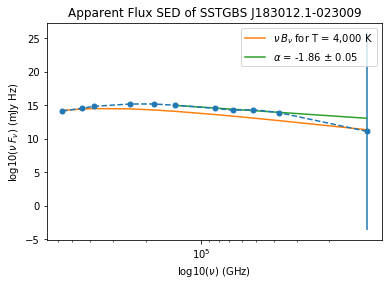

The index in region is  [[33]]
The GAIA list number is 47465
The outlier is at a distance of 441.78 +/- 195.16927942008985 pc
The proper motion magnitude is  [[73.87254469]] +/- [[459.70137333]] km/s
plx [[2.26357178]]
parallax signal to noise [[7.37603617]]
COMPARISON OF FLUXES AND ERRORS CALCULATED BY DIFFERENT METHODS
[0.01151949 0.05606533 0.15562822 0.97563713 1.6065716  1.44409409]
[0.01151949 0.05606534 0.15562826 0.9756369  1.6065712  1.4440941 ]
[0.00177301 0.00022803 0.00348789 0.10701347 0.17950502 0.18218653]
[0.00177301 0.00022803 0.00348789 0.10154121 0.10154121 0.10154121]
Signal to Noise
[  6.4971259  245.8632475   44.61954591   9.11695667   8.95000914
   7.92645896]
[  6.4971256 245.86394    44.61954     9.608285   15.821863   14.221753 ]
6.4971256 245.86395 44.61954
****************************************************************
The GB index 1907
RA:  277.68874294609844
DEC:  -1.3897714565944583
The difference in RA is  0.529 arcseconds
The difference in Dec is  0.46

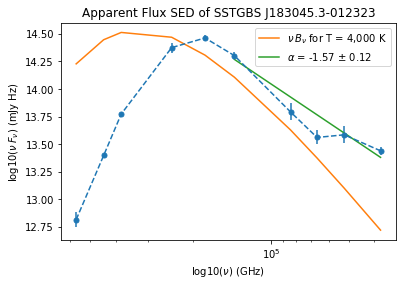

The index in region is  [[38]]
The GAIA list number is 3857
The outlier is at a distance of 366.44 +/- 134.27568777538715 pc
The proper motion magnitude is  [[24.5292911]] +/- [[984.6846188]] km/s
plx [[2.728986]]
parallax signal to noise [[21.47133827]]
COMPARISON OF FLUXES AND ERRORS CALCULATED BY DIFFERENT METHODS
[0.12172814 0.43061227 1.01013296 2.58040707 3.82208269 3.07040446]
[0.12172811 0.43061206 1.0101333  2.580407   3.822082   3.0704038 ]
[0.00403946 0.000543   0.00452516 0.07473781 0.1179523  0.17445273]
[0.00403946 0.00054301 0.00452517 0.07367592 0.07367592 0.07367592]
Signal to Noise
[ 30.13474289 793.02406729 223.22596135  34.52612842  32.4036301
  17.60020875]
[ 30.134762 793.00616  223.22525   35.023746  51.87695   41.674454]
30.134764 793.0062 223.22523
****************************************************************
The GB index 2186
RA:  277.8470074845617
DEC:  -2.3313913542952314
The difference in RA is  0.059 arcseconds
The difference in Dec is  0.11 arcseconds


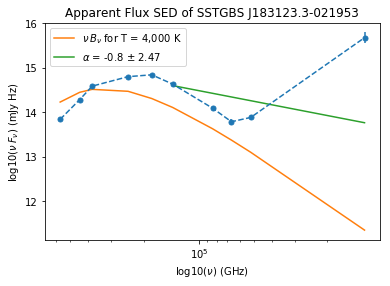

The index in region is  [[45]]
The GAIA list number is 3905
The outlier is at a distance of 361.86 +/- 130.94612962650592 pc
The proper motion magnitude is  [[25.6522286]] +/- [[264.07835728]] km/s
plx [[2.76346308]]
parallax signal to noise [[6.54265022]]
COMPARISON OF FLUXES AND ERRORS CALCULATED BY DIFFERENT METHODS
[0.10851815 0.39550478 1.01533327 3.34879235 4.29635363 3.65422799]
[0.10851812 0.39550486 1.0153337  3.3487937  4.296352   3.654228  ]
[0.00230447 0.00202816 0.00652499 0.09065146 0.10007493 0.09201238]
[0.00230447 0.00202816 0.00652495 0.08944624 0.08944624 0.08944624]
Signal to Noise
[ 47.0902375  195.00679527 155.60682438  36.94140636  42.93136635
  39.71452329]
[ 47.090225 195.00676  155.60796   37.43918   48.032784  40.853905]
47.09022 195.00674 155.60796
****************************************************************
The GB index 2751
RA:  278.13398953005776
DEC:  -2.158207244933876
The difference in RA is  0.052 arcseconds
The difference in Dec is  0.089 arcseco

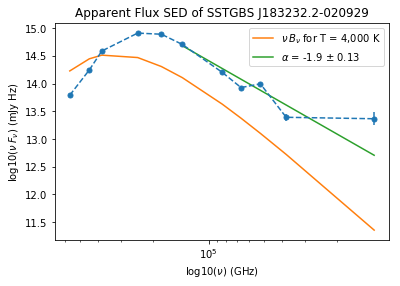

The index in region is  [[48]]
The GAIA list number is 49613
The outlier is at a distance of 418.84 +/- 175.42726682387826 pc
The proper motion magnitude is  [[45.2072867]] +/- [[12479.20203431]] km/s
plx [[2.38754437]]
parallax signal to noise [[36.02447891]]
COMPARISON OF FLUXES AND ERRORS CALCULATED BY DIFFERENT METHODS
[0.4013977  1.01184805 2.05727138 5.17712237 7.1433189  5.67016549]
[0.40139785 1.0118476  2.0572705  5.177121   7.143322   5.6701665 ]
[4.64923384e-03 8.15885148e-04 6.63340971e-03 3.85613394e-01
 8.71616731e-01 5.18481834e-01]
[0.00464925 0.00081593 0.00663344 0.37192777 0.37192777 0.37192777]
Signal to Noise
[  86.33631138 1240.18442589  310.13784259   13.42568085    8.19548162
   10.93609289]
[  86.335976 1240.1216    310.1363     13.919695   19.206207   15.245343]
86.335976 1240.1217 310.1363
****************************************************************
The GB index 2902
RA:  278.234657500942
DEC:  -0.5183239819912588
The difference in RA is  0.266 arcseconds

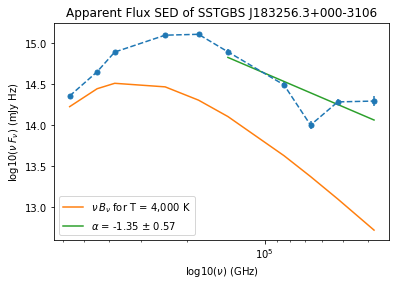

The index in region is  [[56]]
The GAIA list number is 54737
The outlier is at a distance of 504.53 +/- 254.5555541888779 pc
The proper motion magnitude is  [[9.20508856]] +/- [[4.6341571]] km/s
plx [[1.9820231]]
parallax signal to noise [[26.80694389]]
COMPARISON OF FLUXES AND ERRORS CALCULATED BY DIFFERENT METHODS
[ 2.21778748  6.68544986 14.94186958 50.1289365  62.04404267 51.66487943]
[ 2.2177875  6.685448  14.94187   50.128925  62.044044  51.664867 ]
[0.00561519 0.00274555 0.02722401 1.12042879 1.2700063  0.91207432]
[0.00561508 0.00274595 0.02722392 1.1080908  1.1080908  1.1080908 ]
Signal to Noise
[ 394.96246191 2435.0095084   548.84899487   44.74085019   48.85333449
   56.64547091]
[ 394.96957  2434.6582    548.85077    45.239006   55.991844   46.625122]
394.96957 2434.6582 548.85077
****************************************************************
The GB index 3175
RA:  278.9723528917186
DEC:  -0.35988244065879404
The difference in RA is  0.134 arcseconds
The difference in Dec 

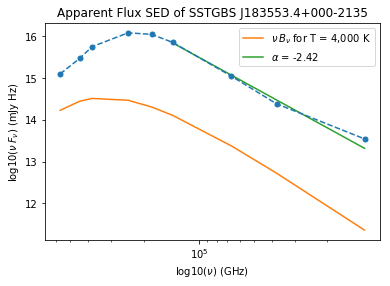

The index in region is  [[63]]
The GAIA list number is 55890
The outlier is at a distance of 381.9 +/- 145.84906729609563 pc
The proper motion magnitude is  [[4.69572621]] +/- [[3.04588524]] km/s
plx [[2.61847343]]
parallax signal to noise [[3.99592781]]
COMPARISON OF FLUXES AND ERRORS CALCULATED BY DIFFERENT METHODS
[0.00843338 0.04304391 0.1227437  0.95959607 1.33014846 1.42822114]
[0.00843338 0.04304391 0.12274367 0.95959604 1.3301488  1.4282218 ]
[0.00208662 0.00023081 0.00272884 0.07432756 0.12833033 0.11346318]
[0.00208662 0.00023081 0.00272884 0.07158947 0.07158947 0.07158947]
Signal to Noise
[  4.04164125 186.49224498  44.98009646  12.91036704  10.36503608
  12.58752946]
[  4.0416408 186.49336    44.980095   13.404151   18.58023    19.950167 ]
4.0416408 186.49336 44.980095
****************************************************************
The GB index 3330
RA:  279.34341050210094
DEC:  0.37811582470526517
The difference in RA is  0.009 arcseconds
The difference in Dec is  0.074 a

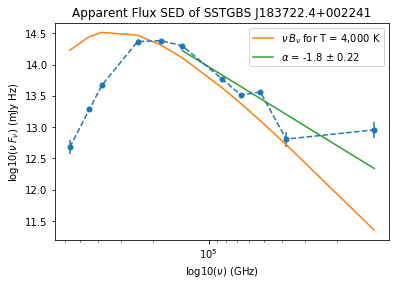

The index in region is  [[67]]
The GAIA list number is 56710
The outlier is at a distance of 520.24 +/- 270.6486320492232 pc
The proper motion magnitude is  [[69.43543054]] +/- [[42.91842849]] km/s
plx [[1.9221934]]
parallax signal to noise [[8.74844742]]
COMPARISON OF FLUXES AND ERRORS CALCULATED BY DIFFERENT METHODS
[0.05201816 0.19509236 0.46162723 1.25686365 1.75509234 1.28468173]
[0.05201815 0.19509241 0.461627   1.2568642  1.7550931  1.284682  ]
[0.001963   0.00036364 0.00472424 0.06896734 0.08949818 0.08934616]
[0.001963   0.00036364 0.00472425 0.06714165 0.06714165 0.06714165]
Signal to Noise
[ 26.49926761 536.49320826  97.71465788  18.22404173  19.61036997
  14.37870145]
[ 26.499268 536.50385   97.71436   18.71959   26.140154  19.133905]
26.499268 536.50385 97.71436
****************************************************************
The GB index 3369
RA:  279.43432347474663
DEC:  0.4025944507239772
The difference in RA is  0.006 arcseconds
The difference in Dec is  0.2 arcseconds

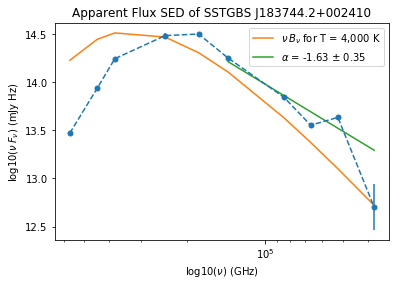

In [21]:
#Print SEDs of outliers 

#condition
SD_pm_median = np.median(SD_pm)
YSO_pm_median = np.median(YSO_pm)
SD_pm_std = np.std(SD_pm)
YSO_pm_std = np.std(YSO_pm)

#Conditions
conditionSD = np.abs(SD_pm - SD_pm_median) > SD_pm_std
conditionYSO = np.abs(YSO_pm - YSO_pm_median) > YSO_pm_std

#name folders
folder1 = 'Outlier_All_pmmag_YSO'
folder2 = 'Outlier_All_pmmag_SD'

#FindOutlier(YSO_ALL,YSO_match,'YSO',conditionYSO,folder1)
FindOutlier(SD_ALL,SD_match,'S+D',conditionSD,folder2,shift1=5)

In [22]:
#Figure out why some outliers are not classified as outliers with the given method
print(SD_pm_std)

what = np.abs(SD_pm - SD_pm_median)
print(what)
n = 0
for i in range(len(what)):
    if (what[i] > SD_pm_std):
        print(what[i])
        n += 1
print(n)

4.376226101376523
[2.87790136e-01 3.26981922e-01 4.30054977e-01 3.93059689e-01
 1.23207009e+00 2.49936828e-01 2.33058214e-01 1.75556803e+00
 1.26823923e-01 9.95629968e-01 3.86902088e-01 4.73319381e-01
 4.40974347e-01 2.94231897e-01 4.11101260e-01 5.55458537e-01
 8.83014937e-01 2.03874404e+00 3.95230970e-01 3.36098780e+00
 6.66469305e-01 1.04046789e+00 1.53141373e+00 4.52943202e-01
 5.36025768e-01 3.24950070e+00 4.33461796e+00 9.56491211e-01
 5.92048829e-02 6.37283021e-01 8.87719354e+00 3.31954864e-01
 3.91043960e+00 2.64435417e+01 1.01000114e-01 1.25769336e-02
 1.60996207e-02 1.11042669e+00 5.28832745e+00 8.71262459e-01
 3.10510443e-01 2.46431275e+00 4.53330001e-01 2.51908271e-01
 1.13077649e-01 6.12142761e+00 4.06167989e+00 1.01334167e+00
 1.39369163e+01 4.22257370e-01 2.58944917e-01 1.84667335e-01
 6.67357344e-01 3.74774152e-01 9.43050411e-01 1.58294900e+00
 4.98496238e+00 1.49046233e+00 8.97195948e-02 5.45133660e-01
 3.25117008e+00 1.31975731e-02 1.24509956e-01 6.24003913e+00
 7.061

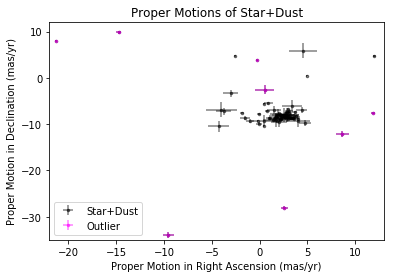

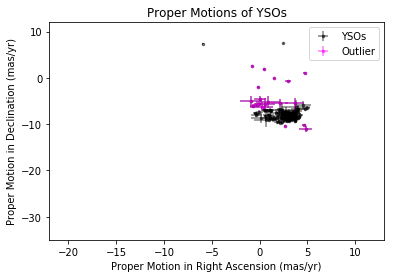

In [23]:
plt.errorbar(SD_ALL['pmra'],SD_ALL['pmdec'],yerr = SD_ALL['pmdec_e'],xerr=SD_ALL['pmra_e'],linestyle='None'\
            ,color='black',label='Star+Dust',marker='o',markersize=2.5,alpha=0.5)
plt.errorbar(SD_ALL['pmra'][conditionSD],SD_ALL['pmdec'][conditionSD],yerr = SD_ALL['pmdec_e'][conditionSD],\
             xerr=SD_ALL['pmra_e'][conditionSD],linestyle='None',color='magenta',label='Outlier',
             marker='o',markersize=2.5,alpha=0.5)
plt.xlabel('Proper Motion in Right Ascension (mas/yr)')
plt.ylabel('Proper Motion in Declination (mas/yr)')
plt.title('Proper Motions of Star+Dust')
plt.xlim(-22,13)
plt.ylim(-35,12)
plt.legend()
plt.savefig('Figures/proper_motions_SD_OUTLIER.png',dpi=300)
plt.show()

plt.errorbar(YSO_ALL['pmra'],YSO_ALL['pmdec'],yerr = YSO_ALL['pmdec_e'],xerr=YSO_ALL['pmra_e'],linestyle='None'\
            ,color='black',label='YSOs',marker='o',markersize=2.5,alpha=0.5)
plt.errorbar(YSO_ALL['pmra'][conditionYSO],YSO_ALL['pmdec'][conditionYSO],yerr = YSO_ALL['pmdec_e'][conditionYSO],\
             xerr=YSO_ALL['pmra_e'][conditionYSO],linestyle='None',color='magenta',label='Outlier',
             marker='o',markersize=2.5,alpha=0.5)
plt.xlabel('Proper Motion in Right Ascension (mas/yr)')
plt.ylabel('Proper Motion in Declination (mas/yr)')
plt.title('Proper Motions of YSOs')
plt.xlim(-22,13)
plt.ylim(-35,12)
plt.legend()
plt.savefig('Figures/proper_motions_YSO_OUTLIER.png',dpi=300)
plt.show()



# Compare distribution of stars/ysos outside distance range

Number of All matches in the correct distance interval: 17
Number of _match with parallax > 5, 10, 20:  11 3 1
For all stars in region
The mean velocity in ra is  2.4863901266033372 +/- 0.778708178001169
The mean velocity in dec is  -8.287112858278858 +/- 1.1890453675866108
The median velocity in ra is  3.3453817864833115 +/- 0.9759659683320601
The median velocity in dec is  -9.563286940011004 +/- 1.490247369105805
The mean magnitude of velocity is 9.971017168283346 +/- 0.758514505372428
The median magnitude of velocity is 9.601570838198466 +/- 0.9506569529421379
The standard deviation of velocity is 3.1274354242136555
The median parallax is 3.207205165339307 with a standard deviation of 0.7973798786256896
The median distance is 311.7979513150992 with a standard deviation of 49.822146078774175
For parallax S/N > 10 stars:
The mean velocity in ra is  1.4924822107059723 +/- 1.2514789227178933
The mean velocity in dec is  -2.4020962730222215 +/- 3.2628557620741976
The median velocity in r

/Users/roxanapopescu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:172: RuntimeWarning: invalid value encountered in true_divide


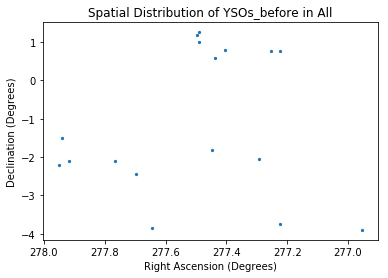

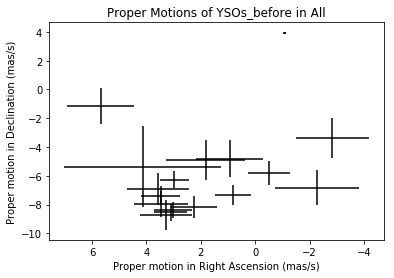

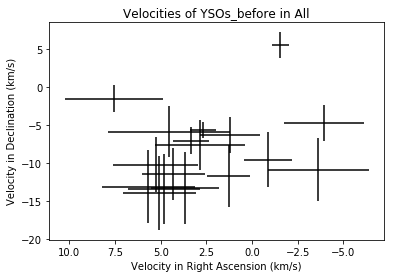

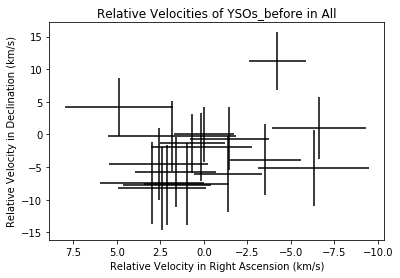

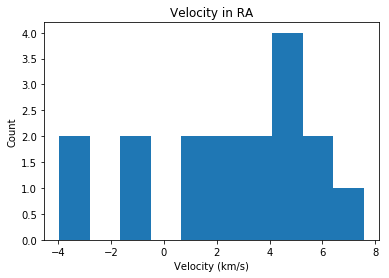

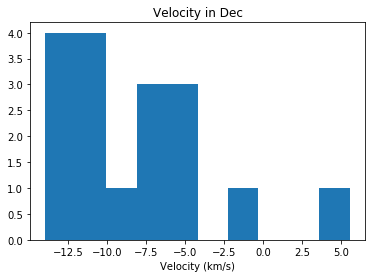

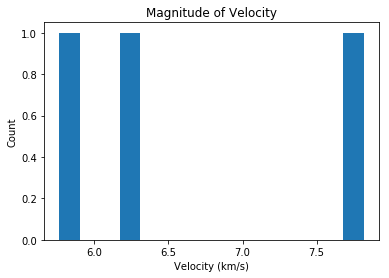

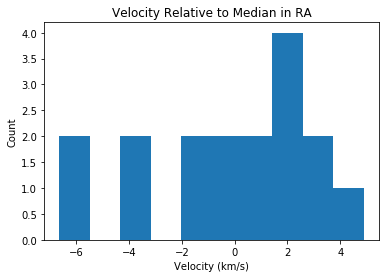

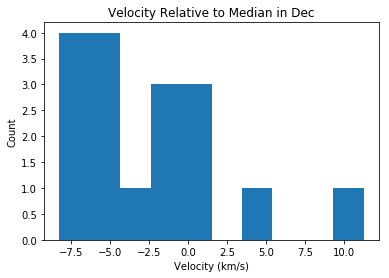

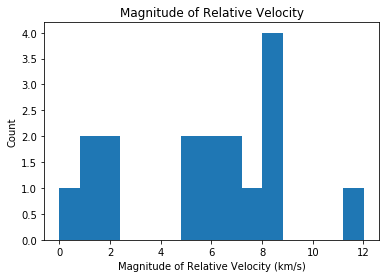

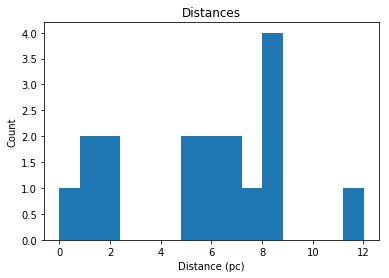

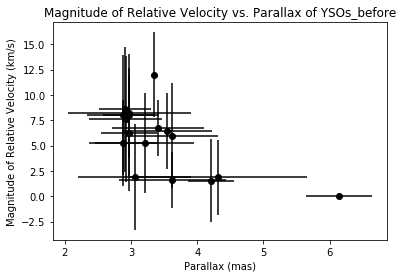

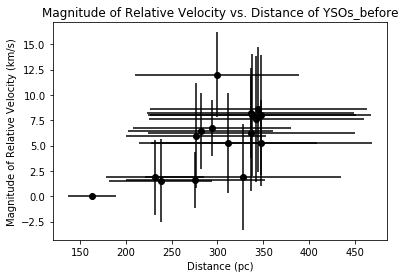

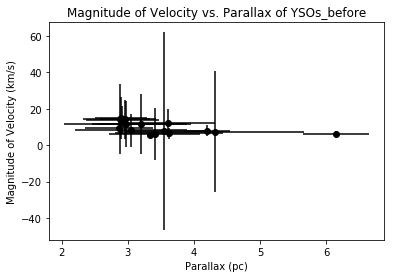

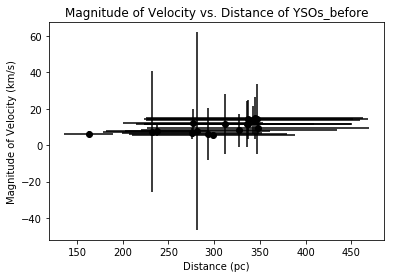

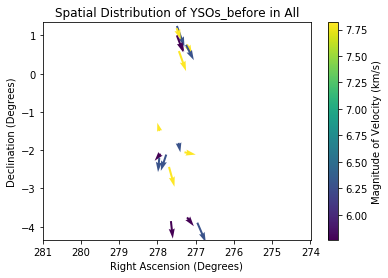

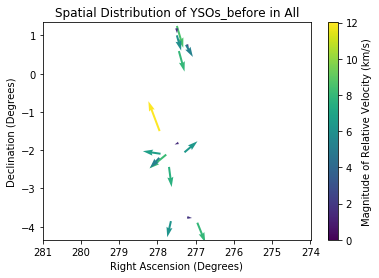

In [24]:
#YSOs before distance range
adj1 = [0,0,0,0]
adj=[1,6,1,6]
YSO_before = CalculateProperties('All','YSOs_before',YSO_match,Gvalues,distance_range=[0,350],exclude = [59408,32169,35855,3580])

In [25]:
#Print out information about foreground YSOs

for i in range(len(YSO_before['dist'])):
    print(i,YSO_before['gaia_id'][i],YSO_before['par_sn'][i],YSO_before['par'][i],\
          YSO_before['dist'][i],YSO_before['dec'][i])

0 32850.0 12.048959732055664 4.203716473127306 237.8847399420498 0.7646345895387392
1 32140.0 4.2938923835754395 3.207205165339307 311.7979513150992 0.7521241374657242
2 32479.0 12.30760383605957 6.143915853720335 162.76264581235571 0.7993754421840261
3 32340.0 7.778141021728516 2.9625282569794433 337.54952299411565 0.5906797547756377
4 36105.0 7.365920543670654 2.9034949188148267 344.4125193813628 1.2472385465022717
5 35905.0 5.128466606140137 3.6121127420505537 276.8462867613351 1.0015554334005383
6 36025.0 3.592302083969116 3.0531782122292626 327.5275566930812 1.18888913009958
7 12429.0 5.251336097717285 2.879492471949177 347.28342224943657 -3.8945766720004538
8 12382.0 3.2213423252105713 4.31817881180147 231.57910859713036 -3.75662087125433
9 5936.0 5.308325290679932 3.5496131429154176 281.72084104316394 -2.05429403386938
10 6732.0 4.474447250366211 3.625258418135861 275.8424047779216 -1.8084413634658203
11 27951.0 7.0655059814453125 2.966322011174267 337.11781668778895 -3.85330885

3.4669051785545473
0.7973798786256896
[4.20371647 3.20720517 6.14391585 2.96252826 2.90349492 3.61211274
 3.05317821 2.87949247 4.31817881 3.54961314 3.62525842 2.96632201
 2.91939728 2.97273507 3.40558119 3.34132239 2.87333562]
[0.34888627 0.7469226  0.49919674 0.38087871 0.3941795  0.7043261
 0.84992244 0.54833519 1.34049056 0.66868796 0.81021368 0.41983152
 0.55163194 0.92899496 0.69227509 0.03110104 0.5137664 ]
[3855 2460 5645 2582 2509 2908 2203 2331 2978 2881 2815 2546 2368 2044
 2713 3310 2360]
[4553 3954 6643 3343 3298 4316 3903 3428 5659 4218 4435 3386 3471 3902
 4098 3372 3387]


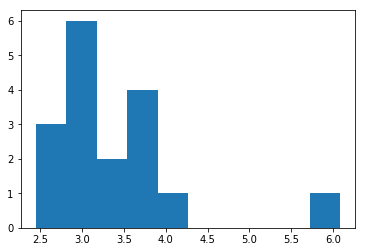

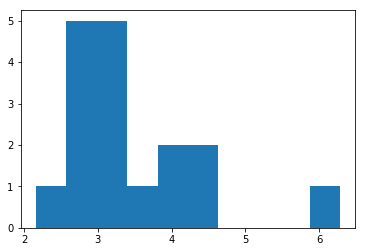

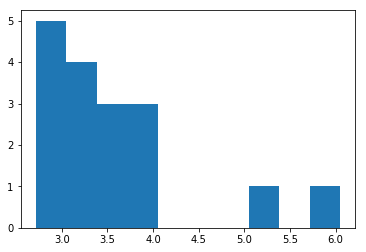

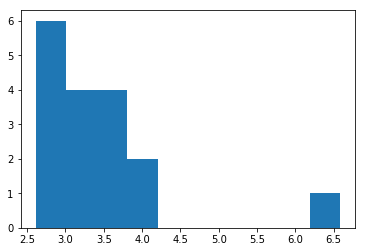

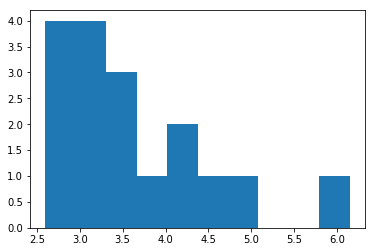

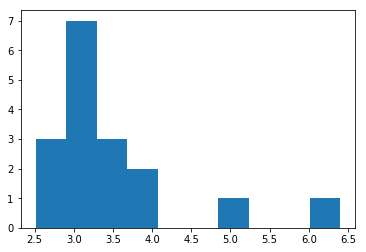

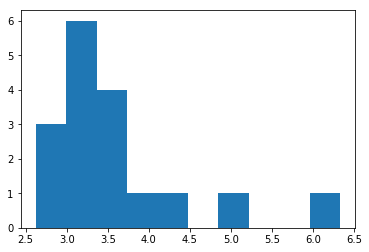

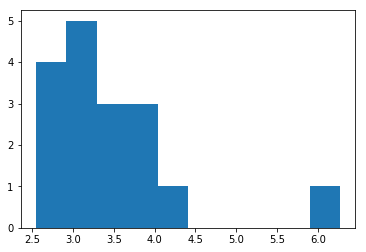

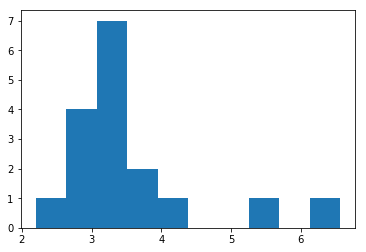

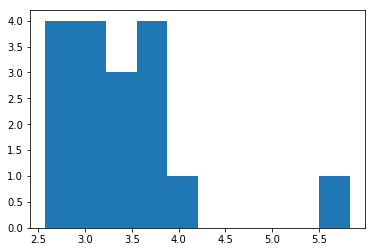

In [26]:

print(np.mean(YSO_before['par']))
print(np.std(YSO_before['par']))
par = YSO_before['par']
par_e = YSO_before['par_e']

lower = np.round((par - par_e),3)*1000
higher = np.round((par + par_e),3)*1000

lower = lower.astype(int)
higher = higher.astype(int)

print(par)
print(par_e)
print(lower)
print(higher)

#fill an array with randomly generated values
num_rows = 10
distributions = np.ones((num_rows,len(par)))
for i in range(num_rows):
    for j in range(len(par)):
        distributions[i,j] = (np.random.randint(lower[j],higher[j]))/1000.
        
for i in range(num_rows):
    plt.hist(distributions[i,:])
    plt.show()

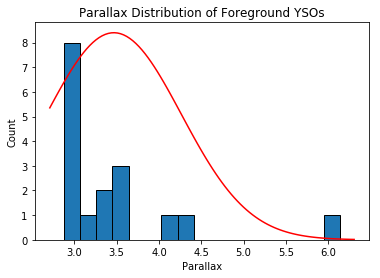

The mean of the gaussian fit is 3.4669051785545473


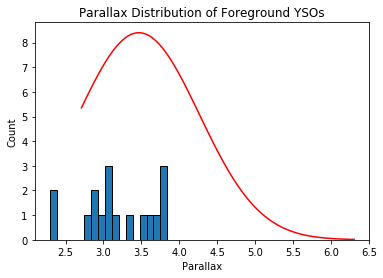

Ks_2sampResult(statistic=0.29411764705882354, pvalue=0.3873903320738349)
KstestResult(statistic=0.9979691881237602, pvalue=0.0)


In [27]:
#fitting a standard normal distribution to the data

#function for probability distribution of a gaussian
def gaussian(x,var,mu,height):
    
    pdf = height*(1/np.sqrt(2*math.pi*var))*np.exp(-((x-mu)**2)/(2*var**2))
    
    return pdf

import matplotlib.mlab as mlab
from astropy.modeling import models

#parameters for sample fit
#par_vals = np.random.normal(loc=5.0, scale=2.0, size=1000)
par_vals = YSO_before['par']
par_err = YSO_before['par_e']
n, bins, patches = plt.hist(par_vals,bins=17,edgecolor='black')
ymin, ymax = plt.ylim()
xmin, xmax = plt.xlim()
mean = np.mean(par_vals)
median = np.median(par_vals)
stdev = np.std(par_vals)

#using astropy model
gmodel = models.Gaussian1D(amplitude=ymax,mean=mean,stddev=stdev)
x = np.linspace(xmin, xmax, 100)
plt.plot(x,gmodel(x),color='red')
plt.xlabel('Parallax')
plt.ylabel('Count')
plt.title('Parallax Distribution of Foreground YSOs')
plt.show()

print('The mean of the gaussian fit is',mean)

#generate population based on gaussian distribution
pop = np.random.normal(loc=mean, scale = stdev, size=17)
n, bins, patches = plt.hist(pop,bins=17,edgecolor='black')
plt.plot(x,gmodel(x),color='red')
plt.xlabel('Parallax')
plt.ylabel('Count')
plt.title('Parallax Distribution of Foreground YSOs')
plt.show()

#compare the two populations with a ks test
print(scipy.stats.ks_2samp(par_vals,pop))
print(scipy.stats.kstest(par_vals, 'norm'))

#need to figure out how to get chisquare to work with bins
#print(scipy.stats.chisquare(par_vals,pop))

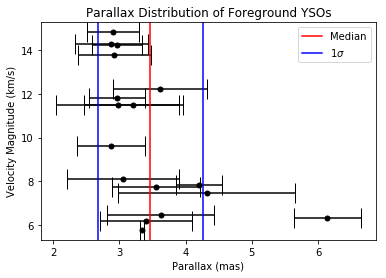

The median is 3.207205165339307


In [28]:
plt.axvline(x=mean,color='red',label = 'Median')
plt.axvline(x=mean+stdev,color='blue',label = '1$ \sigma$')
plt.axvline(x=mean-stdev,color='blue')
plt.errorbar(par_vals,YSO_before['pmmag_all'],xerr=par_err,ls='None',color='black',marker='.',markersize=10,capsize=10)
plt.xlabel('Parallax (mas)')
plt.ylabel('Velocity Magnitude (km/s)')
plt.title('Parallax Distribution of Foreground YSOs')
plt.legend()
plt.savefig('Figures/ForegroundYSOs.png',dpi=300)
plt.show()
print('The median is',median)

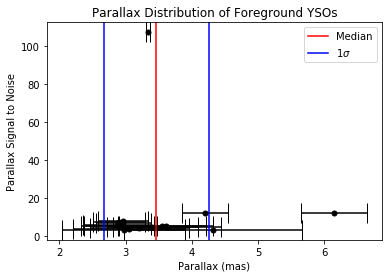

The median is 3.207205165339307


In [29]:
plt.axvline(x=mean,color='red',label = 'Median')
plt.axvline(x=mean+stdev,color='blue',label = '1$ \sigma$')
plt.axvline(x=mean-stdev,color='blue')
plt.errorbar(par_vals,YSO_before['par_sn'],xerr=par_err,ls='None',color='black',marker='.',markersize=10,capsize=10)
plt.xlabel('Parallax (mas)')
plt.ylabel('Parallax Signal to Noise')
plt.title('Parallax Distribution of Foreground YSOs')
plt.legend()
plt.savefig('Figures/ForegroundYSOs2.png',dpi=300)
plt.show()
print('The median is',median)

In [30]:
for i in range(len(YSO_before['id'])):
    gaia_id = int(YSO_before['id'][i])
    print(GTab["phot_g_mean_mag"][gaia_id])

17.835432
19.489304
19.079334
18.99846
18.852211
19.646921
19.571754
19.405912
20.65685
19.227919
19.269001
19.1508
19.580032
19.845863
19.805155
13.984467
19.193785


In [31]:
#remove closest yso
max_idx = np.argmax(par_vals)
par_vals2 = np.delete(par_vals,max_idx)
par_err2 = np.delete(par_err,max_idx)
print(YSO_before['ra'][max_idx])
print(YSO_before['dec'][max_idx])
gaia_id = int(YSO_before['id'][max_idx])
print(gaia_id)
print(G2MASS[gaia_id])

#remove highest signal to noise yso
min_idx = np.argmin(par_err)
par_vals3 = np.delete(par_vals,min_idx)
par_err3 = np.delete(par_err,min_idx)

#test if meets normal distribution
median = np.median(par_vals)
z = (par_vals-median)/par_err
a,b = scipy.stats.normaltest(z)
print('statstic:',a)
print('p-value:',b)

#test if meets normal distribution w/o outlier
median2 = np.median(par_vals2)
z2 = (par_vals2-median2)/par_err2
a2,b2 = scipy.stats.normaltest(z2)
print('statstic:',a2)
print('p-value:',b2)

#test if meets normal distribution
median3 = np.median(par_vals3)
z3 = (par_vals3-median3)/par_err3
a3,b3 = scipy.stats.normaltest(z3)
print('statstic:',a3)
print('p-value:',b3)

277.40303610870143
0.7993754421840261
32479
b'18293672+0047577'
statstic: 13.898863003143454
p-value: 0.0009591802912124115
statstic: 27.148246998567217
p-value: 1.2730136709545773e-06
statstic: 24.337145690452104
p-value: 5.191058948775943e-06


/Users/roxanapopescu/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1394: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=17
  "anyway, n=%i" % int(n))
/Users/roxanapopescu/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1394: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=16
  "anyway, n=%i" % int(n))


COMPARISON OF FLUXES AND ERRORS CALCULATED BY DIFFERENT METHODS
[ 0.0189261   0.07696262  0.31757001  4.3942853  10.72259822 13.77829991]
[ 0.01892609  0.07696258  0.31757003  4.394287   10.722596   13.778295  ]
[0.00675367 0.00149774 0.02439865 0.11479792 0.34109268 0.29498998]
[0.00675367 0.00149775 0.02439863 0.11332407 0.11332407 0.11332407]
Signal to Noise
[ 2.80234189 51.38566594 13.01588469 38.27844089 31.43602561 46.70768716]
[  2.8023417  51.385544   13.015894   38.77629    94.61888   121.58313  ]
2.8023417 51.385544 13.015894
****************************************************************
The c2d index is 127
RA:  277.40303610870143
DEC:  0.7993754421840261
The difference in RA is  0.2689513252107645 arcseconds
The difference in Decliantion is  0.20360813750608386 arcseconds
The c2d_ID is  SSTc2d J182936.7+004758
alpha is -1.08
2MASS ID: b'18293672+0047577'
FLUX SIGNAL TO NOISE
[  2.80234169  51.38554474  13.01589376  38.77629146  94.61887763
 121.58312658  20.74340528  20.6

/Users/roxanapopescu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:57: RuntimeWarning: divide by zero encountered in log10


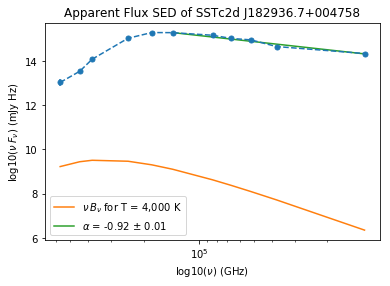

In [32]:
#SED of really close source
Values = SEDCreator(int(YSO_before['id'][max_idx]),YSO_match,'YSO',"",shift1=0,shift2=0)

COMPARISON OF FLUXES AND ERRORS CALCULATED BY DIFFERENT METHODS
[ 3662.46170292  6417.17446636 10184.57254681 10946.82864893
 15021.03687929 13121.86739338]
[ 3662.461  6417.174 10184.571 10946.831 15021.037 13121.867]
[7.46061165e+00 1.82678854e+00 3.91472999e+01 2.70806487e+03
 1.08912526e+03 4.42378183e+02]
[7.4606786e+00 1.8266670e+00 3.9147217e+01 2.4197771e+03 2.4197771e+03
 2.4197771e+03]
Signal to Noise
[ 490.906359   3512.81734817  260.16028084    4.04230665   13.79183589
   29.66210337]
[ 490.90186   3513.0508     260.1608       4.5239005    6.207612
    5.4227586]
490.90182 3513.051 260.1608
****************************************************************
The GB index 979
RA:  277.94262308024383
DEC:  -2.418435543111859
The difference in RA is  0.352 arcseconds
The difference in Dec is  0.001 arcseconds
The Gould_Belt_ID is  SSTGBS J183146.2-022506
alpha is -2.62
2MASS ID: b'18314620-0225066'
FLUX SIGNAL TO NOISE
[ 490.90185289 3513.05081859  260.16080126    4.52390059    6.

/Users/roxanapopescu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:57: RuntimeWarning: divide by zero encountered in log10
/Users/roxanapopescu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in log10


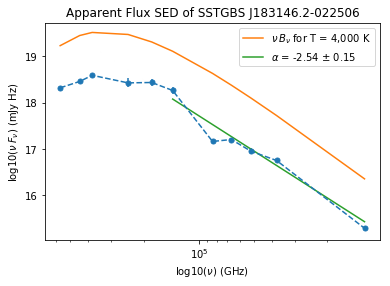

In [33]:
#sed of suspected red giant source
Values = SEDCreator(3580,YSO_match,'YSO','',shift1 =10,shift2=0)

Number of All matches in the correct distance interval: 26
Number of _match with parallax > 5, 10, 20:  17 10 7
For all stars in region
The mean velocity in ra is  -0.612364279756435 +/- 1.4386212713442228
The mean velocity in dec is  -14.330482583960876 +/- 3.31615205883519
The median velocity in ra is  1.4405611010697994 +/- 1.8030443776185126
The median velocity in dec is  -11.085290297900519 +/- 4.156180256826046
The mean magnitude of velocity is 16.79910767550279 +/- 3.182020336920066
The median magnitude of velocity is 11.882245797418959 +/- 3.9880710734873497
The standard deviation of velocity is 16.225183790604504
The median parallax is 3.4516299726437856 with a standard deviation of 1.3730171419284776
The median distance is 289.7182110446478 with a standard deviation of 65.02144490922893
For parallax S/N > 10 stars:
The mean velocity in ra is  -4.834406665410445 +/- 3.018505295057567
The mean velocity in dec is  -21.029660918332368 +/- 7.03795457282011
The median velocity in r

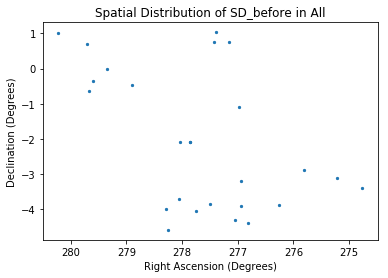

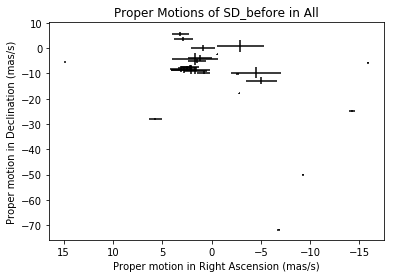

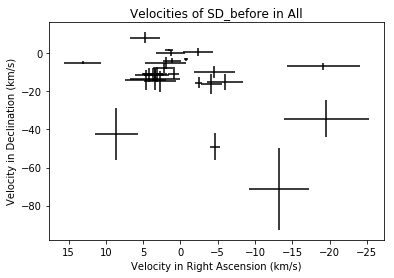

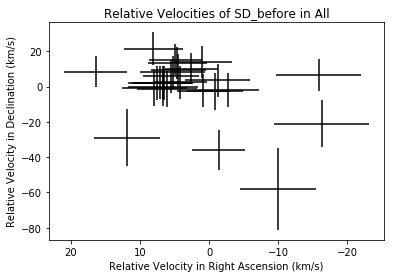

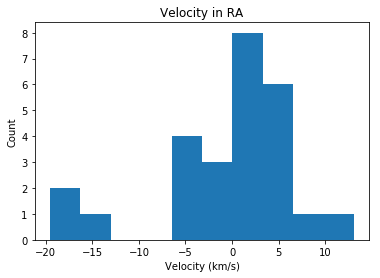

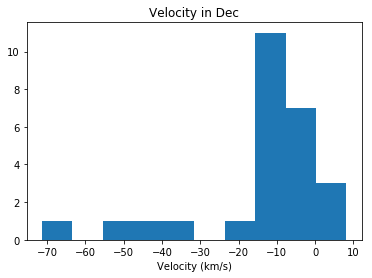

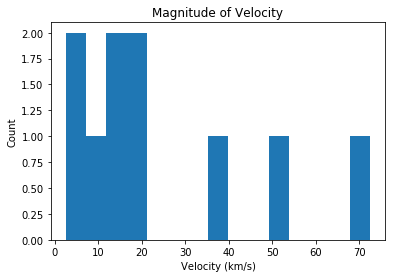

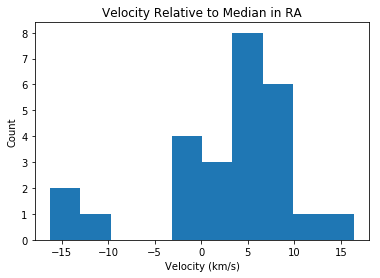

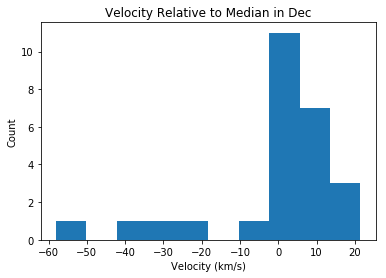

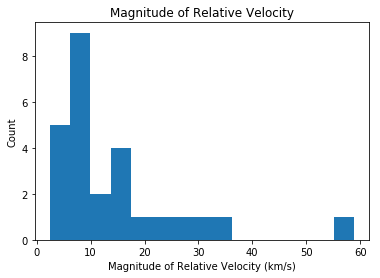

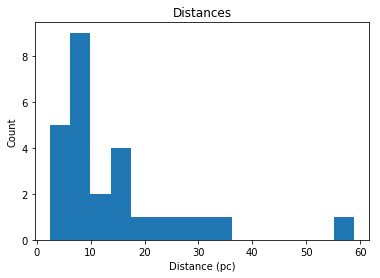

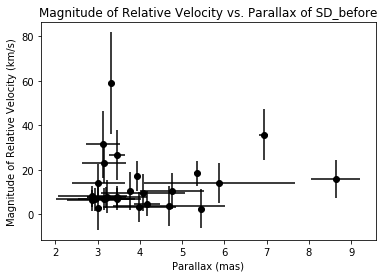

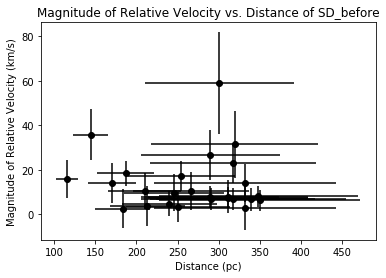

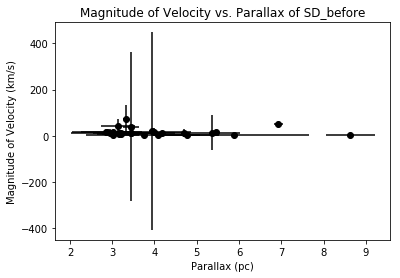

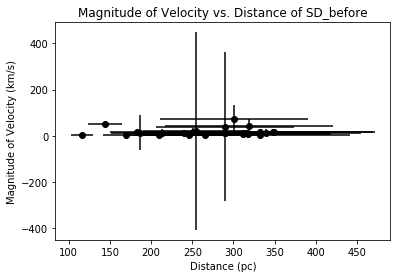

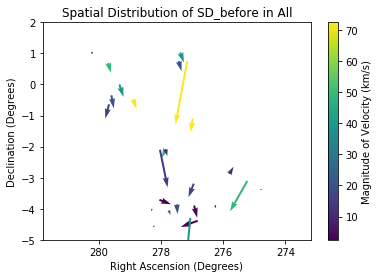

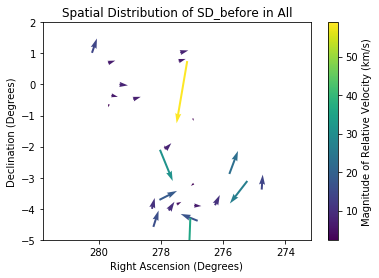

In [34]:
SD_before = CalculateProperties('All','SD_before',SD_match,Gvalues,distance_range=[0,350])

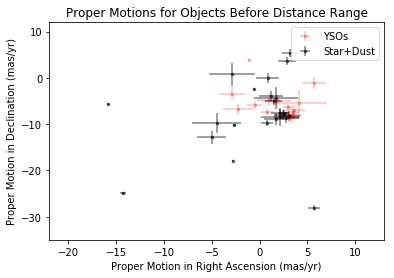

In [35]:
#Proper motions of before distance range

plt.errorbar(YSO_before['pmra'],YSO_before['pmdec'],yerr = YSO_before['pmdec_e'],xerr=YSO_before['pmra_e'],linestyle='None'\
            ,color='red',label='YSOs',marker='o',markersize=2.5,alpha=0.25)
plt.errorbar(SD_before['pmra'],SD_before['pmdec'],yerr = SD_before['pmdec_e'],xerr=SD_before['pmra_e'],linestyle='None'\
            ,color='black',label='Star+Dust',marker='o',markersize=2.5,alpha=0.5)
plt.xlabel('Proper Motion in Right Ascension (mas/yr)')
plt.ylabel('Proper Motion in Declination (mas/yr)')
plt.title('Proper Motions for Objects Before Distance Range')
plt.xlim(-22,13)
plt.ylim(-35,12)
plt.legend()
plt.savefig('Figures/proper_motions_before2.png',dpi=300)
plt.show()

Number of All matches in the correct distance interval: 27
Number of _match with parallax > 5, 10, 20:  17 7 2
For all stars in region
The mean velocity in ra is  3.9946764193276123 +/- 0.9738840102251642
The mean velocity in dec is  -20.22238929342102 +/- 0.8201278876659226
The median velocity in ra is  4.28367154378261 +/- 1.2205825981207115
The median velocity in dec is  -20.52262046733864 +/- 1.027877876018399
The mean magnitude of velocity is 21.25803245732624 +/- 0.7880388114514968
The median magnitude of velocity is 21.37909027162688 +/- 0.9876601831454648
The standard deviation of velocity is 4.09476977931055
The median parallax is 1.7381007912908562 with a standard deviation of 0.06260093538148587
The median distance is 575.340627546299 with a standard deviation of 21.49877153958135
For parallax S/N > 10 stars:
The mean velocity in ra is  5.1333578626859975 +/- 1.2446993698523856
The mean velocity in dec is  -20.762998791843625 +/- 1.0096880324265785
The median velocity in ra 

/Users/roxanapopescu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:172: RuntimeWarning: invalid value encountered in true_divide


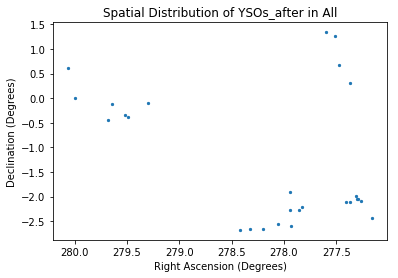

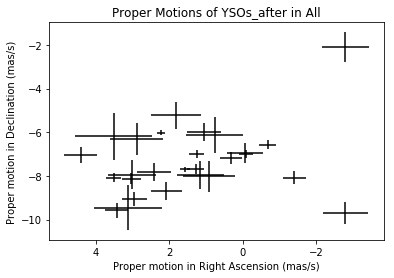

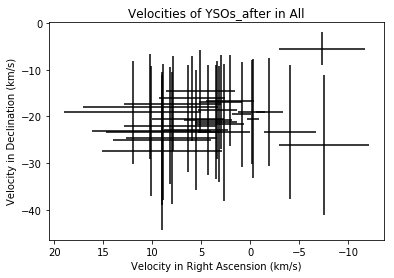

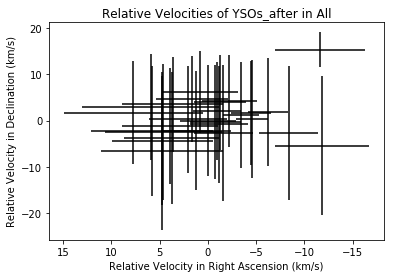

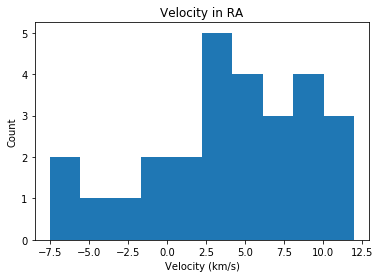

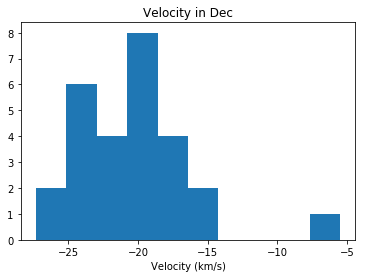

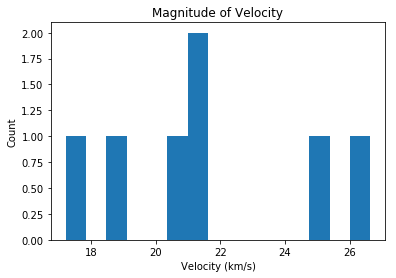

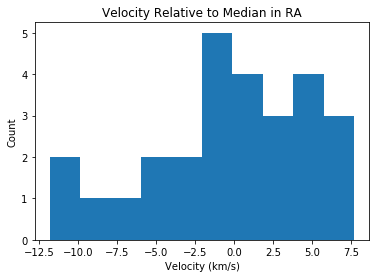

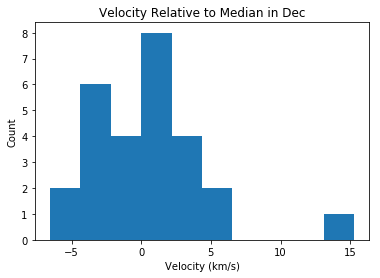

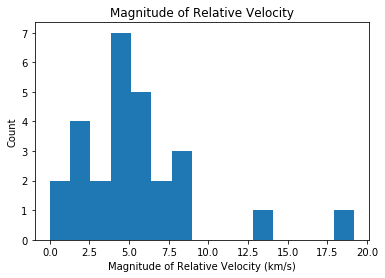

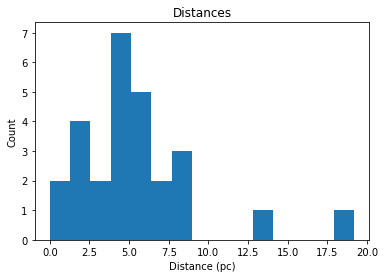

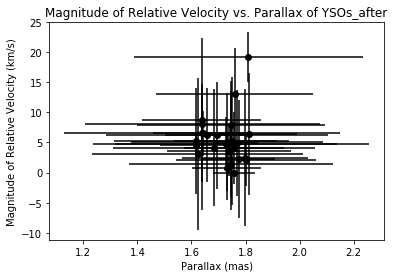

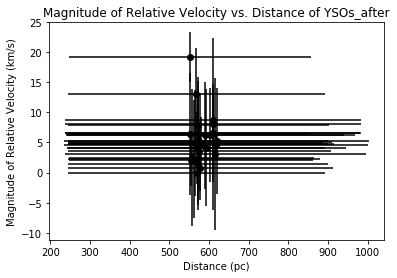

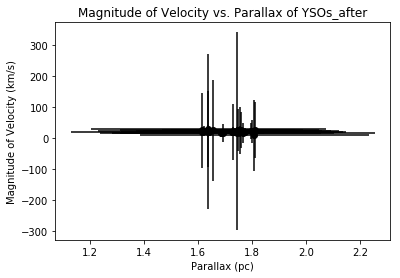

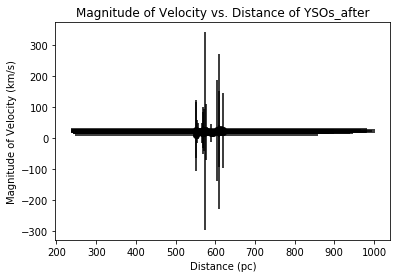

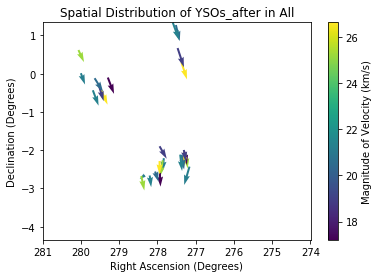

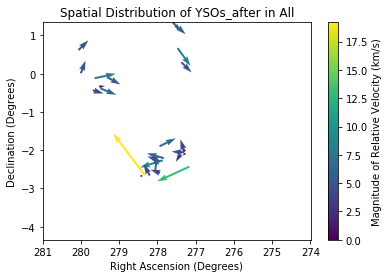

In [36]:
#YSOs after distance range
adj1 = [0,0,0,0]
adj=[1,6,1,6]
YSO_after = CalculateProperties('All','YSOs_after',YSO_match,Gvalues,distance_range=[550,1000])

Number of All matches in the correct distance interval: 13
Number of _match with parallax > 5, 10, 20:  7 4 1
For all stars in region
The mean velocity in ra is  1.303918658382584 +/- 3.2268630106043195
The mean velocity in dec is  -19.713708014721007 +/- 3.382432265330278
The median velocity in ra is  3.723915906666929 +/- 4.04427303037085
The median velocity in dec is  -23.830988908507845 +/- 4.23925017665053
The mean magnitude of velocity is 24.365896999683425 +/- 2.491971090429446
The median magnitude of velocity is 25.17884736464364 +/- 3.1232225974167473
The standard deviation of velocity is 8.984929543517277
The median parallax is 1.6999095847514027 with a standard deviation of 0.06135158186077687
The median distance is 588.2665813348193 with a standard deviation of 20.940973512035693
For parallax S/N > 10 stars:
The mean velocity in ra is  0.47270039492154403 +/- 9.153756387337692
The mean velocity in dec is  -16.975259301826572 +/- 10.017941088961189
The median velocity in ra 

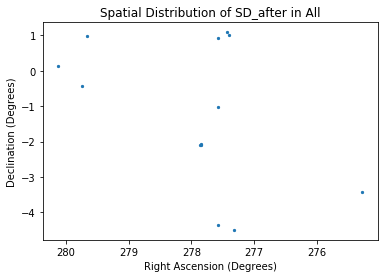

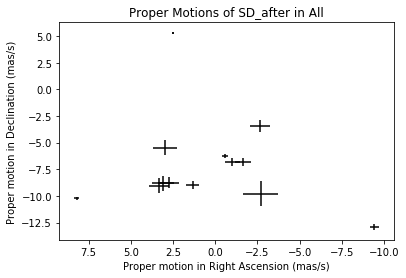

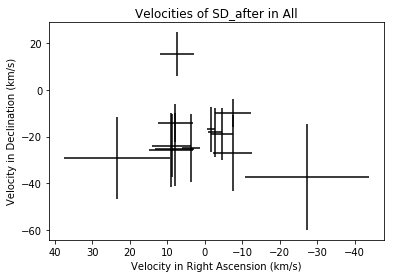

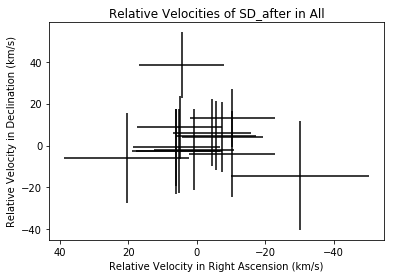

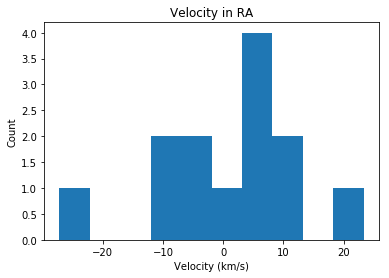

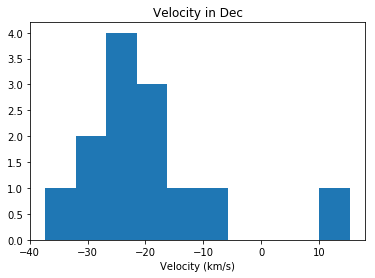

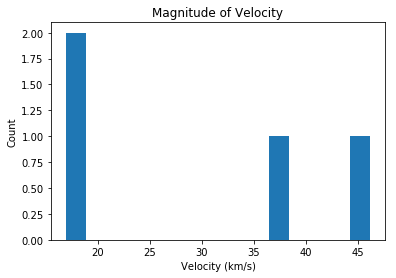

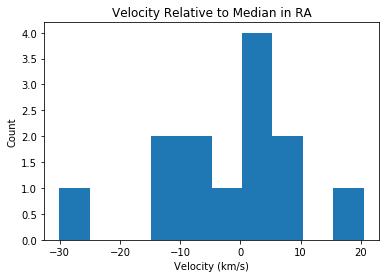

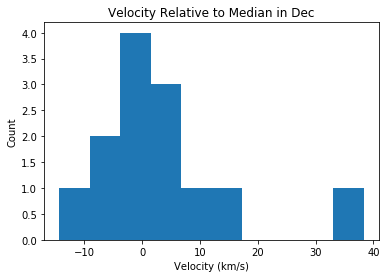

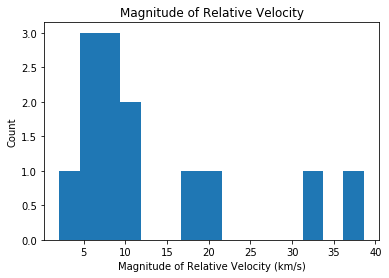

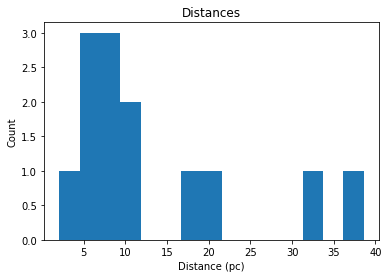

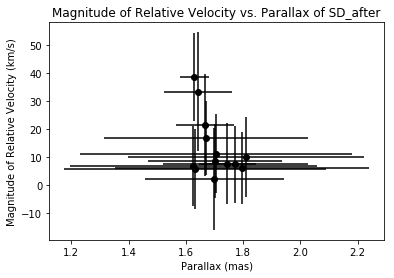

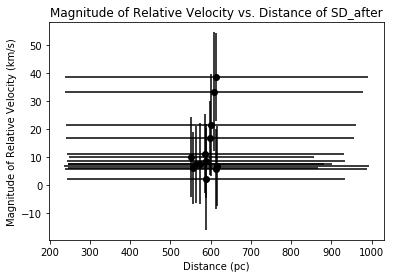

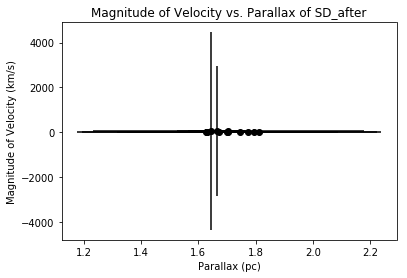

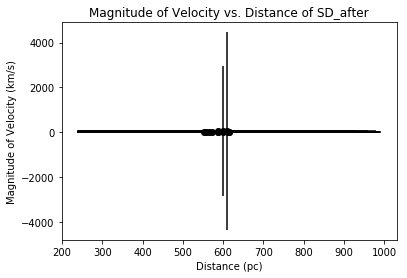

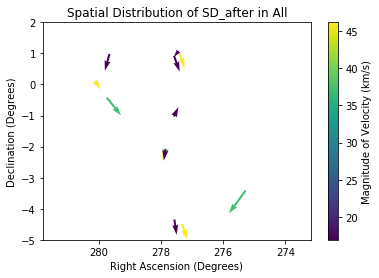

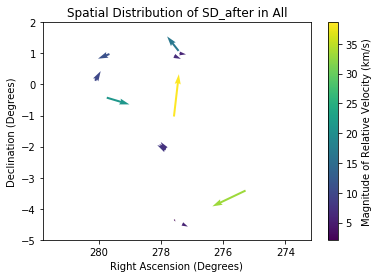

In [37]:
SD_after = CalculateProperties('All','SD_after',SD_match,Gvalues,distance_range=[550,1000])

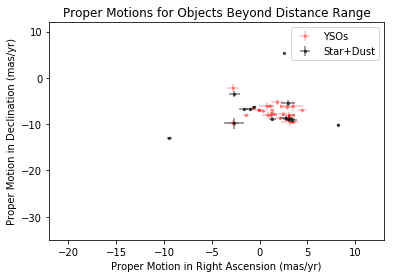

In [38]:
#Proper motions of after distance range

plt.errorbar(YSO_after['pmra'],YSO_after['pmdec'],yerr = YSO_after['pmdec_e'],xerr=YSO_after['pmra_e'],linestyle='None'\
            ,color='red',label='YSOs',marker='o',markersize=2.5,alpha=0.25)
plt.errorbar(SD_after['pmra'],SD_after['pmdec'],yerr = SD_after['pmdec_e'],xerr=SD_after['pmra_e'],linestyle='None'\
            ,color='black',label='Star+Dust',marker='o',markersize=2.5,alpha=0.5)
plt.xlabel('Proper Motion in Right Ascension (mas/yr)')
plt.ylabel('Proper Motion in Declination (mas/yr)')
plt.title('Proper Motions for Objects Beyond Distance Range')
plt.xlim(-22,13)
plt.ylim(-35,12)
plt.legend()
plt.savefig('Figures/proper_motions_after2.png',dpi=300)
plt.show()

In [39]:
for i in range(len(YSO_after['dist'])):
    print(YSO_after['par_sn'][i],YSO_after['dist'][i],YSO_after['ra'][i],YSO_after['dec'][i])

8.21078109741211 572.0273875688519 277.372015169934 0.29996047418929306
3.7706964015960693 610.0862557106859 277.4710826608046 0.6695359668808843
7.693463325500488 556.0079616821722 277.51537089802196 1.2705939708659786
10.179717063903809 551.7101175289381 277.5963783043579 1.3359625822330243
6.055475234985352 568.3647320416519 277.16079190862115 -2.429227405656995
4.642491340637207 572.6038848133663 277.26383419234844 -2.0814064724977697
13.226445198059082 563.1083653635588 277.28917055868067 -2.0410485356545918
12.077617645263672 618.8408194274487 277.3010188142919 -2.055801341189787
4.517009735107422 593.7139487310073 277.3082349143362 -1.9935389213169425
13.661266326904297 578.2164618245073 277.36584656437134 -2.120190326770624
4.152629375457764 616.3537886386679 277.4028707604419 -2.115018994305407
8.994075775146484 609.1031883971195 277.830719408831 -2.208214121686533
7.420624256134033 610.6677986447406 277.8579979233556 -2.262962336868625
7.575274467468262 575.340627546299 277.9

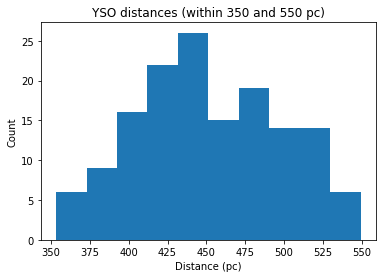

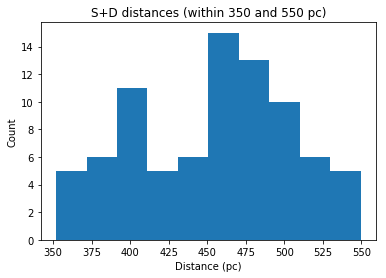

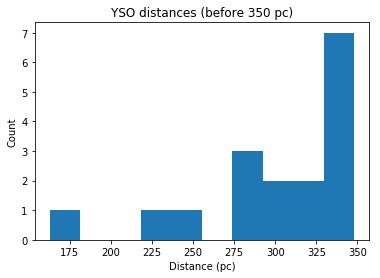

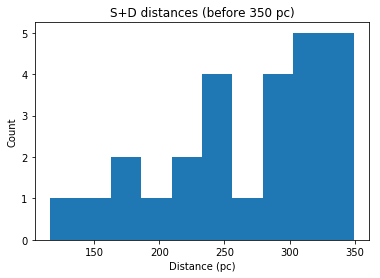

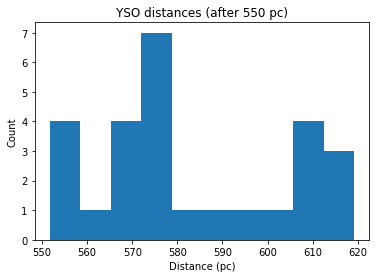

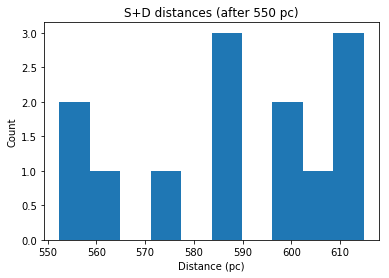

In [40]:
#Distances Histogram!!

plt.hist(YSO_ALL['dist'],bins=10)
plt.title('YSO distances (within 350 and 550 pc)')
plt.xlabel('Distance (pc)')
plt.ylabel('Count')
plt.show()

plt.hist(SD_ALL['dist'],bins=10)
plt.title('S+D distances (within 350 and 550 pc)')
plt.xlabel('Distance (pc)')
plt.ylabel('Count')
plt.show()

plt.hist(YSO_before['dist'],bins=10)
plt.title('YSO distances (before 350 pc)')
plt.xlabel('Distance (pc)')
plt.ylabel('Count')
plt.show()

plt.hist(SD_before['dist'],bins=10)
plt.title('S+D distances (before 350 pc)')
plt.xlabel('Distance (pc)')
plt.ylabel('Count')
plt.show()

plt.hist(YSO_after['dist'],bins=10)
plt.title('YSO distances (after 550 pc)')
plt.xlabel('Distance (pc)')
plt.ylabel('Count')
plt.show()

plt.hist(SD_after['dist'],bins=10)
plt.title('S+D distances (after 550 pc)')
plt.xlabel('Distance (pc)')
plt.ylabel('Count')
plt.show()

# All YSOs and S+D in All Regions and Distances

Number of All matches in the correct distance interval: 195
Number of _match with parallax > 5, 10, 20:  167 100 47
For all stars in region
The mean velocity in ra is  4.783304230931253 +/- 0.26842557205911954
The mean velocity in dec is  -15.627051479570925 +/- 0.451678470664493
The median velocity in ra is  5.562616307623746 +/- 0.336421564278695
The median velocity in dec is  -16.94442505082579 +/- 0.5660950128048535
The mean magnitude of velocity is 17.314152110761388 +/- 0.32923914675687027
The median magnitude of velocity is 18.082449322123765 +/- 0.4126400771880782
The standard deviation of velocity is 4.597574477118607
The median parallax is 2.2285799218224156 with a standard deviation of 0.6348906608910004
The median distance is 448.7162386270861 with a standard deviation of 85.09729023815228
For parallax S/N > 10 stars:
The mean velocity in ra is  5.364985142115735 +/- 0.3516799317548377
The mean velocity in dec is  -15.070465878121185 +/- 0.7464868409290338
The median veloci

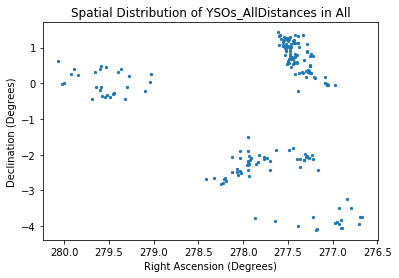

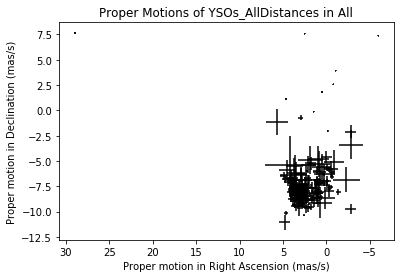

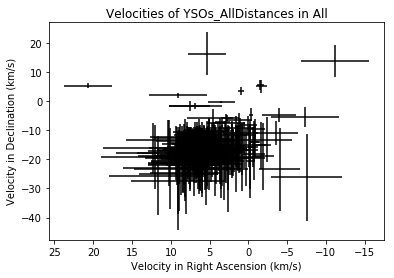

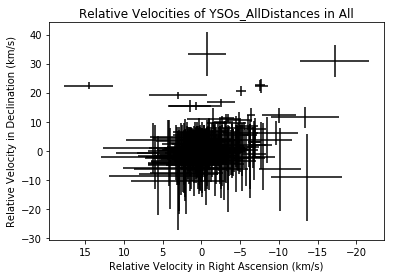

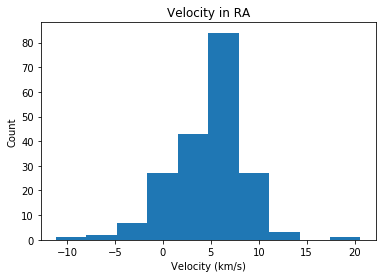

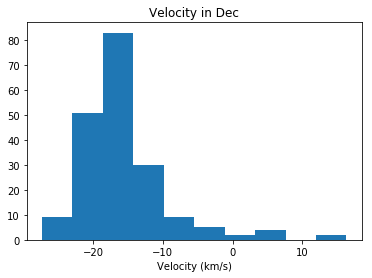

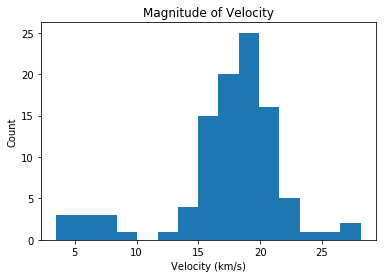

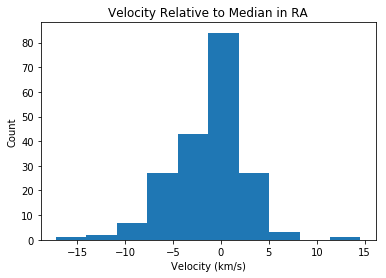

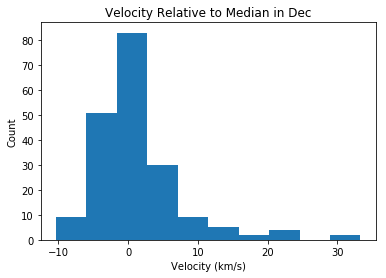

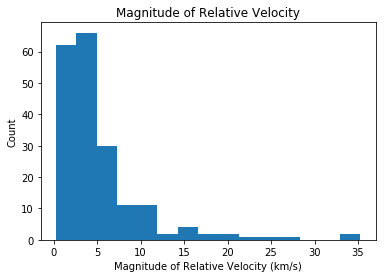

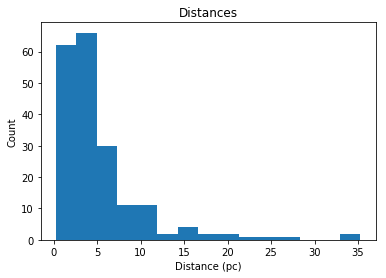

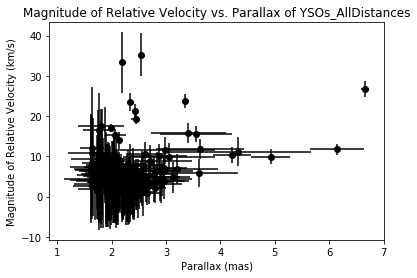

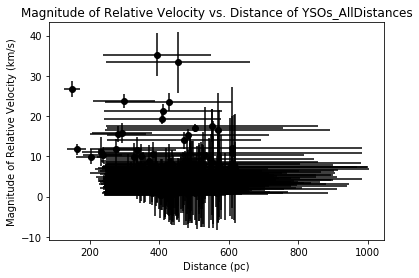

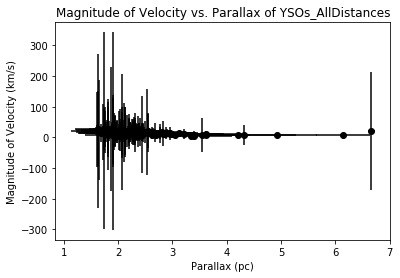

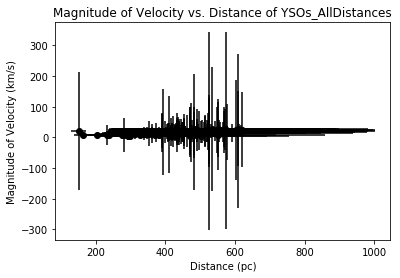

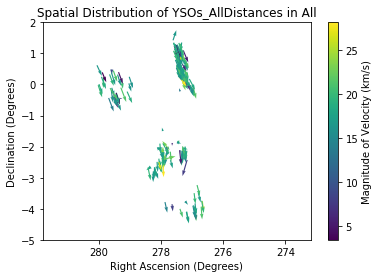

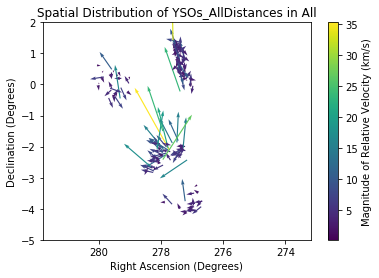

In [41]:
YSO_ALL2 = CalculateProperties('All','YSOs_AllDistances',YSO_match,Gvalues)

Number of All matches in the correct distance interval: 121
Number of _match with parallax > 5, 10, 20:  89 57 34
For all stars in region
The mean velocity in ra is  2.145786280532846 +/- 0.8157529858261277
The mean velocity in dec is  -16.29376683345163 +/- 1.2298104040513838
The median velocity in ra is  3.8801132787764887 +/- 1.0223947496932166
The median velocity in dec is  -17.281270608418968 +/- 1.5413387656152866
The mean magnitude of velocity is 20.00278809834134 +/- 1.0503992900653112
The median magnitude of velocity is 18.6027030874556 +/- 1.3164802800650193
The standard deviation of velocity is 11.554392190718424
The median parallax is 2.2125150430084792 with a standard deviation of 1.0464307719672035
The median distance is 451.97432811134456 with a standard deviation of 107.37478121099633
For parallax S/N > 10 stars:
The mean velocity in ra is  1.481574529033548 +/- 1.5136246283026633
The mean velocity in dec is  -15.241981218740404 +/- 1.9090878642836815
The median velocit

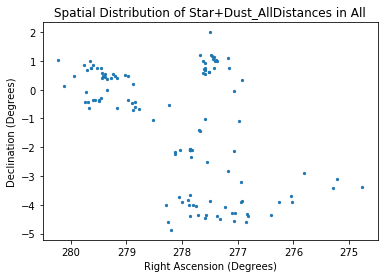

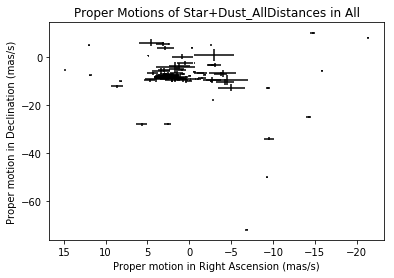

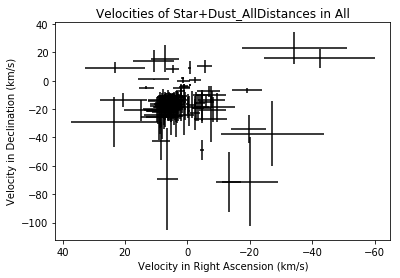

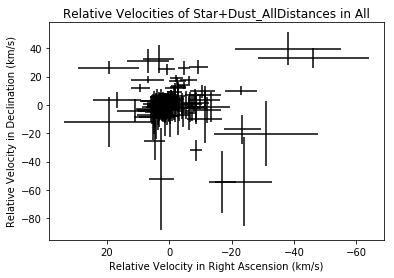

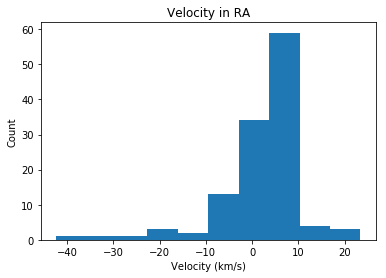

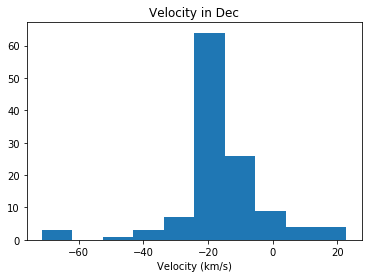

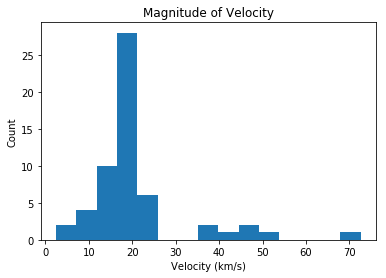

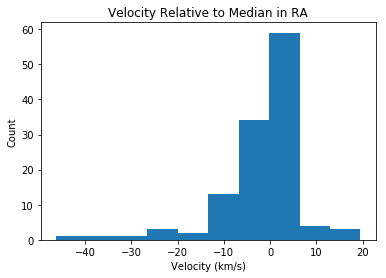

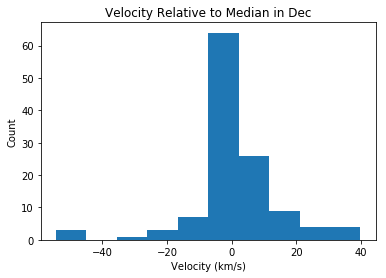

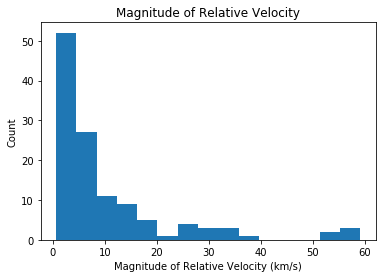

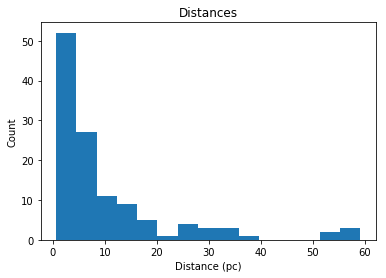

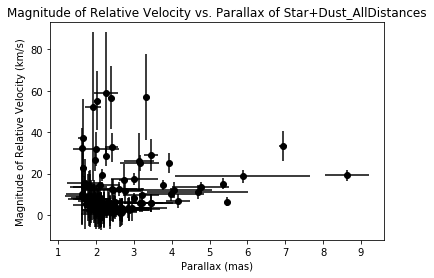

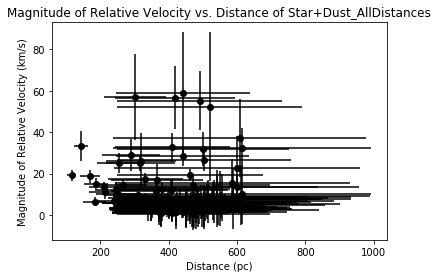

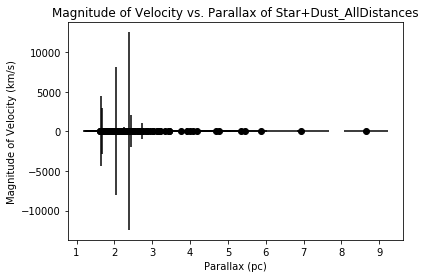

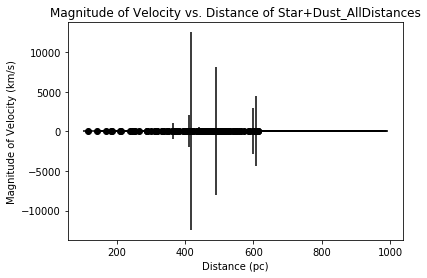

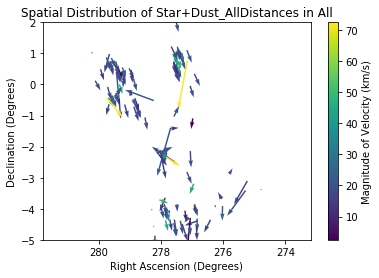

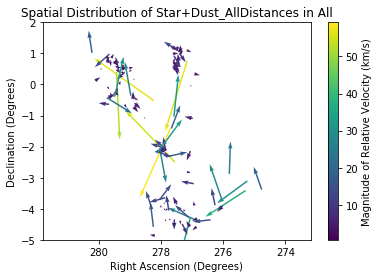

In [42]:
SD_ALL2 = CalculateProperties('All','Star+Dust_AllDistances',SD_match,Gvalues)

# Verifying the CrossMatch

In [43]:
#Print info about the the Gaia 2mass cross match radius
sep = GTab['angular_distance']
print('The mean separation is: ',np.mean(sep))
print('The median separation is ',np.median(sep))
print('The standard deviation of the separation is ',np.std(sep))

#Print info about YSOs in the 2Mass Gaia catalog
sep2 = GTab['angular_distance'][YSO_match[good_YSO]]
print('For YSOs:')
print('The mean separation is: ',np.mean(sep2))
print('The median separation is ',np.median(sep2))
print('The standard deviation of the separation is ',np.std(sep2))

#Check to see if angular distance is what i think it is
num = 67
ra_diff = np.abs(GTab['ra'][num]-GTab['ra_2'][num])
dec_diff = np.abs(GTab['dec'][num]-GTab['dec_2'][num])
calc_sep = np.sqrt(np.square(ra_diff)+np.square(dec_diff))
#print(calc_sep)
#print(sep[num])

#Print info about spitzer 2mass cross match

The mean separation is:  0.1484615511448538
The median separation is  0.11456003484700213
The standard deviation of the separation is  0.1235321030960338
For YSOs:
The mean separation is:  0.10961861847895434
The median separation is  0.09131895107525573
The standard deviation of the separation is  0.07739711894277816


/Users/roxanapopescu/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:688: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  a.partition(kth, axis=axis, kind=kind, order=order)


In [ ]:
# flags to look into
#'number_of_neighbours' 'number_of_mates', 'best_neighbour_multiplicity'

In [ ]:
#separation between Spitzer and 2MASS

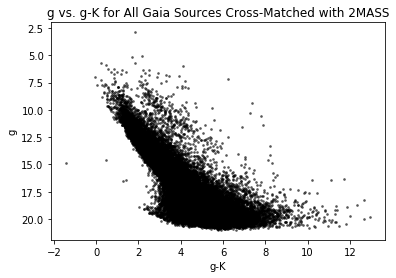

In [45]:
g_K = g - K
plt.scatter(g_K,g,c = 'black',alpha=0.5,s=3)
plt.gca().invert_yaxis()
plt.xlabel('g-K')
plt.ylabel('g')
plt.title('g vs. g-K for All Gaia Sources Cross-Matched with 2MASS')
plt.savefig('Figures/match_eval_g_gK_ALL.png',dpi=300)
plt.show()

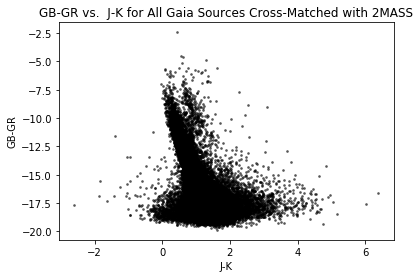

In [46]:
GB_GR = b-r
J_K = J - K
plt.scatter(J_K,GB_GR,c = 'black',alpha=0.5,s=3)
plt.xlabel('J-K')
plt.ylabel('GB-GR')
plt.title('GB-GR vs.  J-K for All Gaia Sources Cross-Matched with 2MASS')
plt.savefig('Figures/match_eval_GBGR_JK_ALL.png',dpi=300)
plt.show()

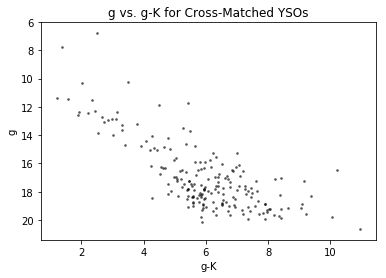

In [47]:
for i in YSO_match[good_YSO]:
    g_K = g[i] - K[i]
    plt.scatter(g_K,g[i],c = 'black',alpha=0.5,s=3)
plt.xlabel('g-K')
plt.ylabel('g')
plt.gca().invert_yaxis()
plt.title('g vs. g-K for Cross-Matched YSOs')
plt.savefig('Figures/match_eval_g_gK.png',dpi=300)
plt.show()

In [48]:
for i in YSO_match[good_YSO]:
    GB_GR = b[i]-r[i]
    J_K = J[i] - K[i]
    plt.scatter(J_K,GB_GR,c = 'black',alpha=0.5,s=3)
plt.xlabel('J-K')
plt.ylabel('GB-GR')
plt.title('GB-GR vs.  J-K for All Cross-Matched YSOs')
plt.savefig('Figures/match_eval_GBGR_JK.png',dpi=300)
plt.show()


IndexError: invalid index to scalar variable.

# Star+Dust

Number of Serpens East matches in the correct distance interval: 32
Number of _match with parallax > 5, 10, 20:  27 15 11
For all stars in region
The mean velocity in ra is  5.258907003377432 +/- 0.4576969996202623
The mean velocity in dec is  -17.134718054535643 +/- 2.1527082497817975
The median velocity in ra is  5.583293183453429 +/- 0.5736381202309618
The median velocity in dec is  -17.946902178868324 +/- 2.698019682967234
The mean magnitude of velocity is 19.526016609173894 +/- 1.7228773201151322
The median magnitude of velocity is 18.67271919796182 +/- 2.1593065021605375
The standard deviation of velocity is 9.74606588964733
The median parallax is 2.0905086032023226 with a standard deviation of 0.21195259149386864
The median distance is 478.3537171098043 with a standard deviation of 42.69604263787268
For parallax S/N > 10 stars:
The mean velocity in ra is  5.446549564439029 +/- 0.4865787750624499
The mean velocity in dec is  -16.536711881053936 +/- 1.8467850245197701
The median v

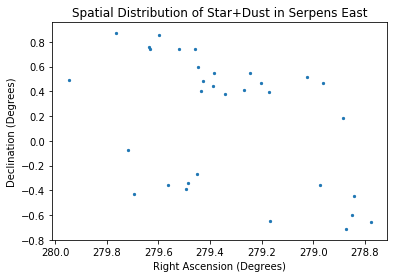

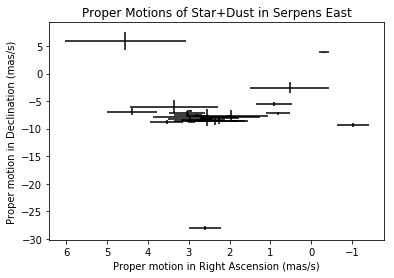

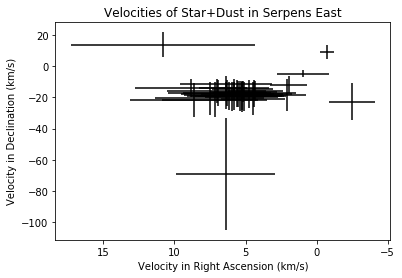

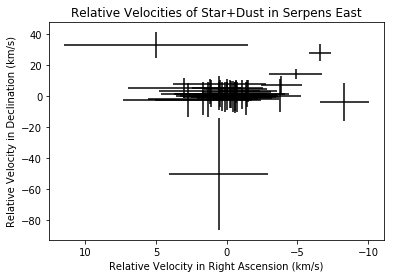

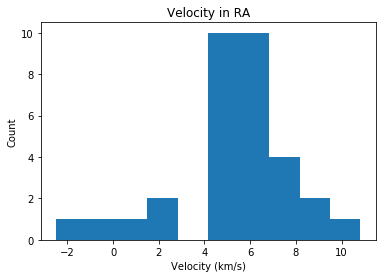

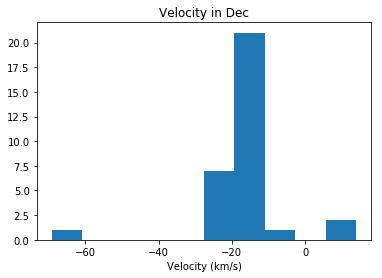

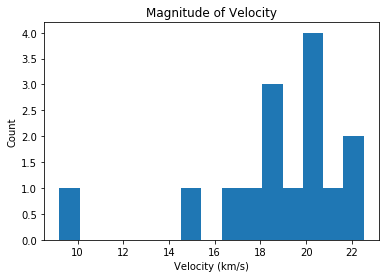

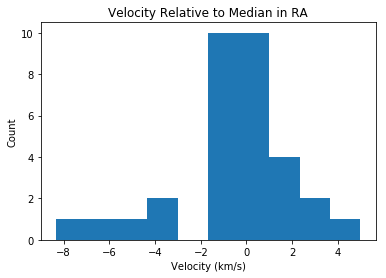

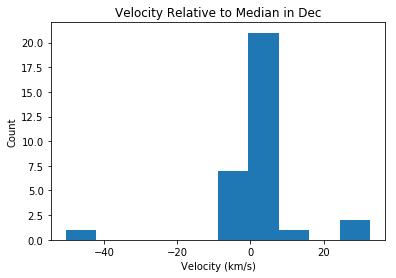

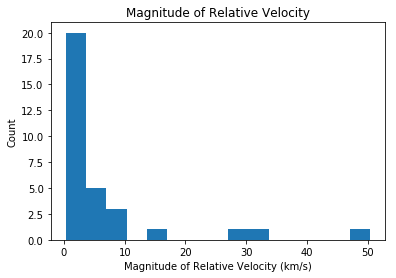

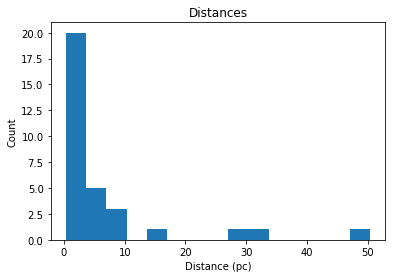

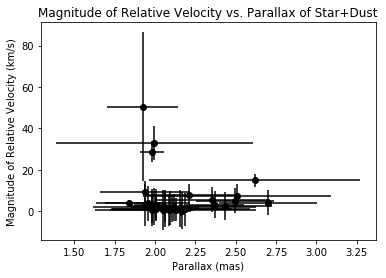

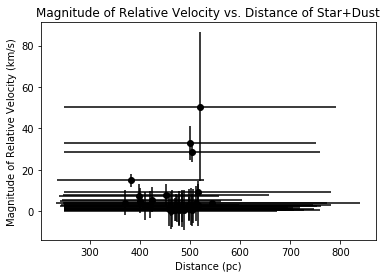

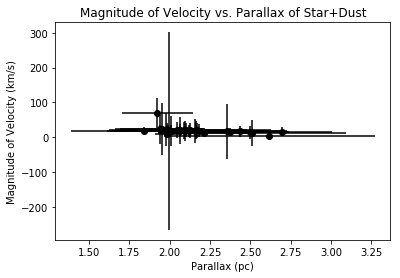

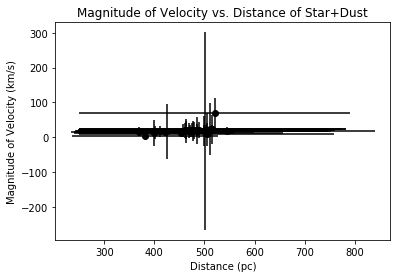

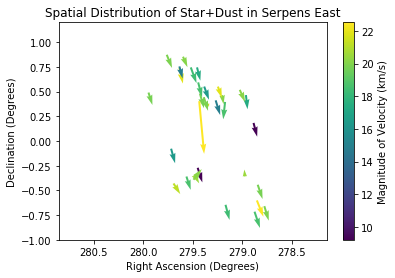

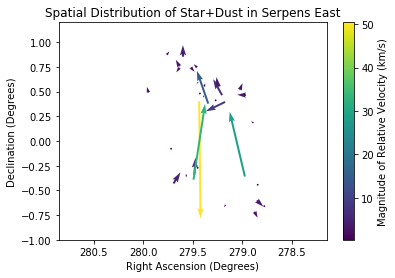

In [49]:
SD_East = CalculateProperties('Serpens East','Star+Dust',SD_match,Gvalues,distance_range=[350.,550.], \
                               sky_region = sky_region1,adj=[0,0,0,0])

Number of Serpens South matches in the correct distance interval: 2
Number of _match with parallax > 5, 10, 20:  1 1 0
For all stars in region
The mean velocity in ra is  4.030897291472207 +/- 2.072589017090471
The mean velocity in dec is  -20.959047597882154 +/- 2.4180848720343064
The median velocity in ra is  4.030897291472207 +/- 2.597605115964324
The median velocity in dec is  -20.959047597882154 +/- 3.0306199553493385
The mean magnitude of velocity is 21.637049331132776 +/- 1.9561984550480696
The median magnitude of velocity is 21.637049331132776 +/- 2.4517311791064853
The standard deviation of velocity is 2.7664823858222753
The median parallax is 1.8993571696594436 with a standard deviation of 0.07936724124136663
The median distance is 527.4148385101689 with a standard deviation of 22.038751526559054
For parallax S/N > 10 stars:
The mean velocity in ra is  6.961980788667074 +/- 0.0
The mean velocity in dec is  -17.53935917688203 +/- 0.0
The median velocity in ra is  6.96198078866

/Users/roxanapopescu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:172: RuntimeWarning: invalid value encountered in true_divide


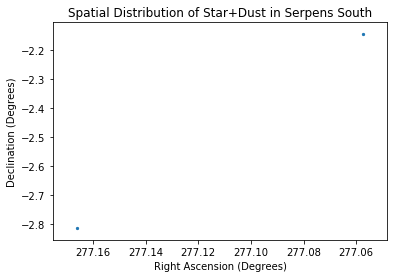

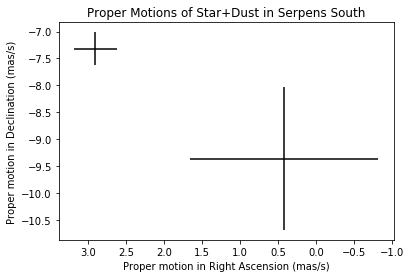

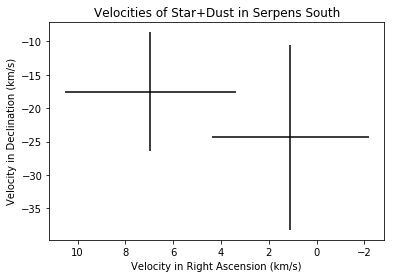

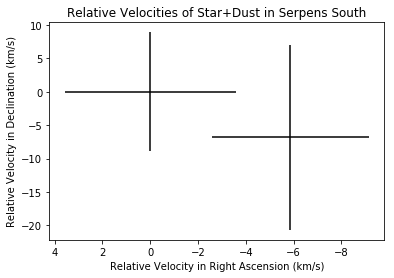

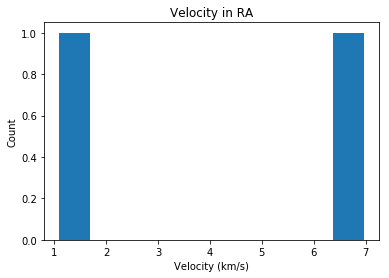

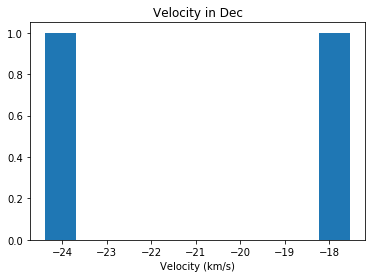

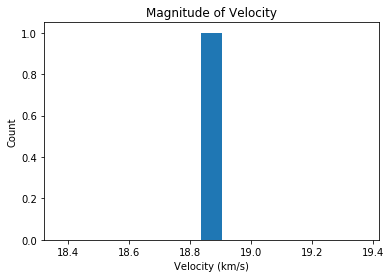

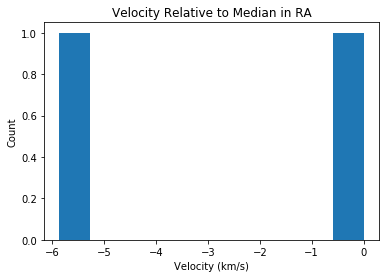

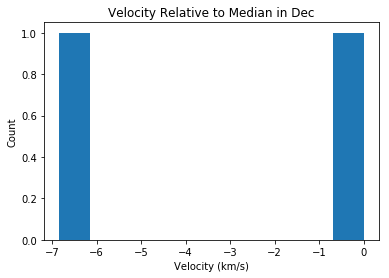

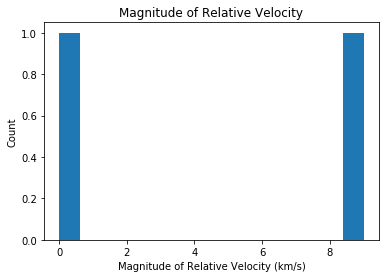

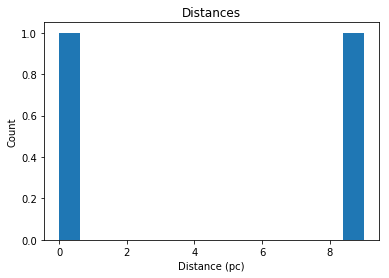

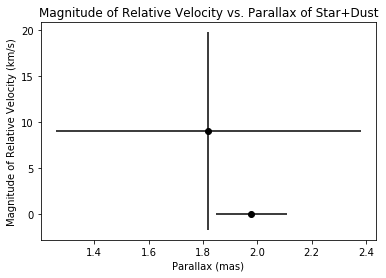

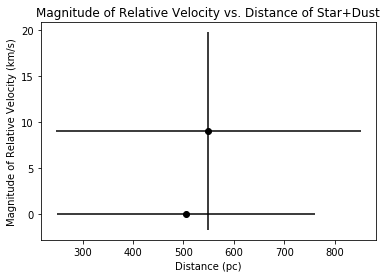

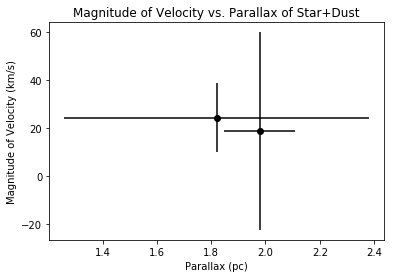

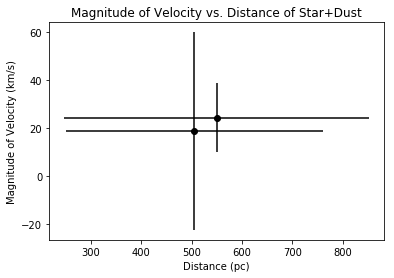

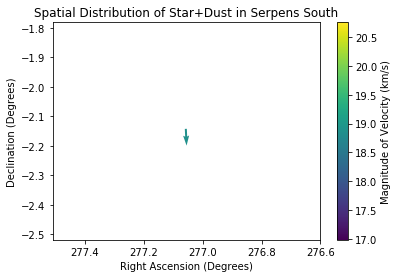

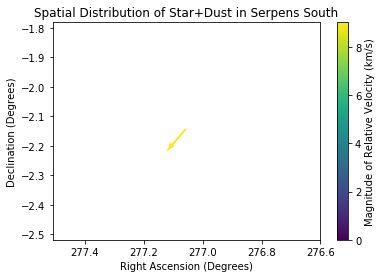

In [50]:
SD_S = CalculateProperties('Serpens South','Star+Dust',SD_match,Gvalues,distance_range=[350.,550.],sky_region = sky_regionS,\
                           adj=[0,0,0,0])


Number of W40 matches in the correct distance interval: 9
Number of _match with parallax > 5, 10, 20:  8 5 2
For all stars in region
The mean velocity in ra is  -0.04714578333292568 +/- 6.054464145481735
The mean velocity in dec is  -13.729390656924028 +/- 8.228653055729577
The median velocity in ra is  -3.3426222487348984 +/- 7.588145507402068
The median velocity in dec is  -13.35877495245286 +/- 10.313087205810268
The mean magnitude of velocity is 28.36869009139758 +/- 5.990930347320244
The median magnitude of velocity is 24.529291101335932 +/- 7.508517699968921
The standard deviation of velocity is 17.972791041960733
The median parallax is 2.2635717785575924 with a standard deviation of 0.2816796185671184
The median distance is 441.77967293673646 with a standard deviation of 52.49834306618125
For parallax S/N > 10 stars:
The mean velocity in ra is  3.1585699696637315 +/- 9.444021571446553
The mean velocity in dec is  0.1971153648858305 +/- 6.750209913293505
The median velocity in ra

/Users/roxanapopescu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:172: RuntimeWarning: invalid value encountered in true_divide


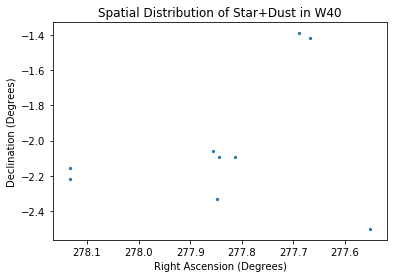

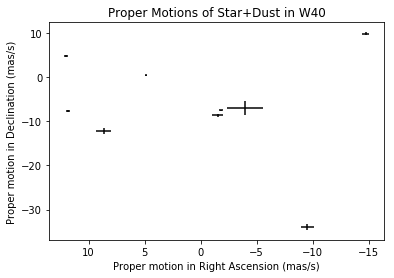

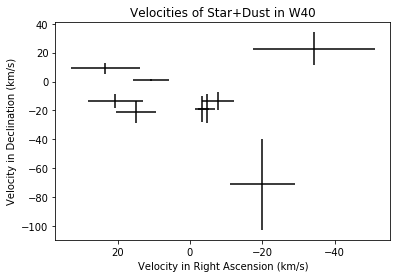

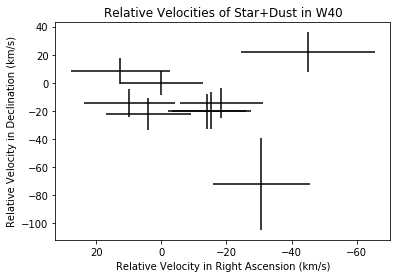

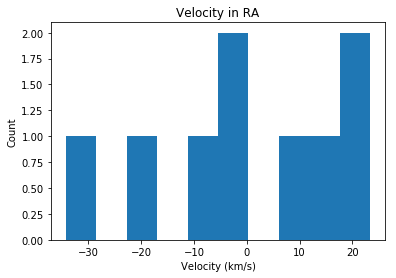

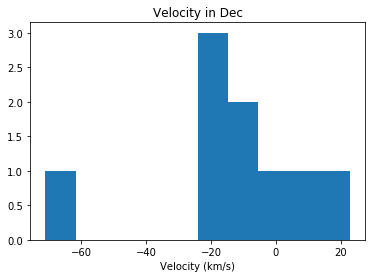

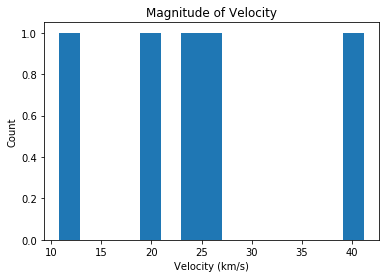

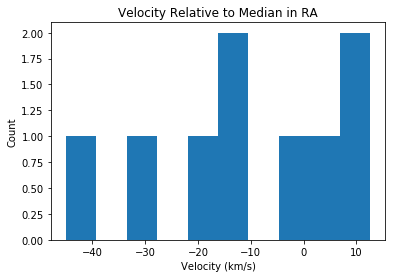

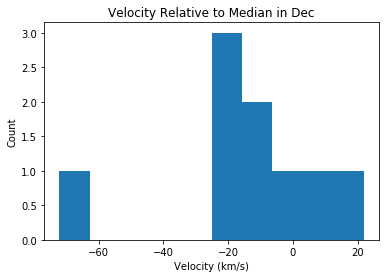

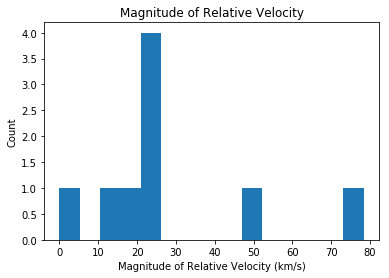

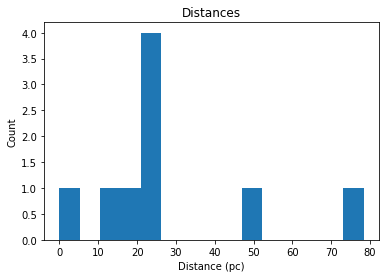

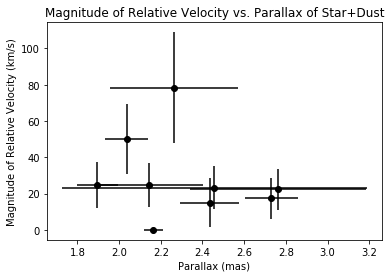

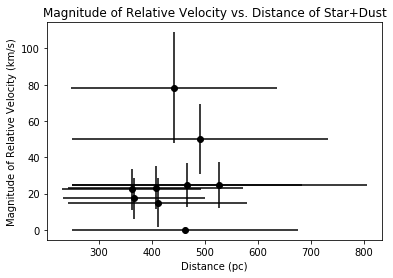

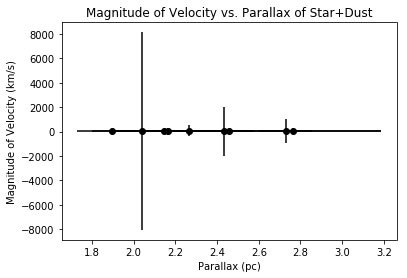

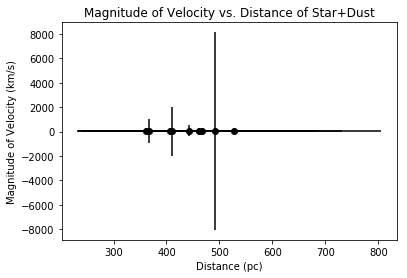

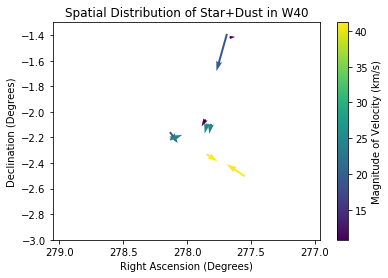

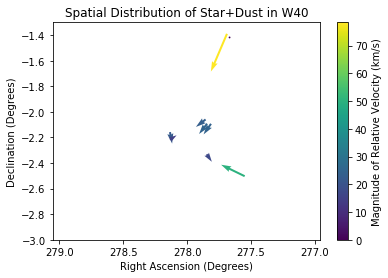

In [51]:
SD_W40 = CalculateProperties('W40','Star+Dust',SD_match,Gvalues,distance_range=[350.,550.],sky_region = sky_regionW40\
                             ,adj=[0,0,0,0])

Number of West Arm matches in the correct distance interval: 16
Number of _match with parallax > 5, 10, 20:  14 13 8
For all stars in region
The mean velocity in ra is  1.307564180183466 +/- 0.9155389737437621
The mean velocity in dec is  -16.94691184821259 +/- 0.7901493331339321
The median velocity in ra is  2.631763095796985 +/- 1.1474579390563815
The median velocity in dec is  -17.328385066710283 +/- 0.9903053298071718
The mean magnitude of velocity is 17.43796733697583 +/- 0.7170077461438117
The median magnitude of velocity is 17.775153050527447 +/- 0.8986359448067625
The standard deviation of velocity is 2.8680309845752467
The median parallax is 2.356345064539348 with a standard deviation of 0.20350541465958244
The median distance is 424.8381576248454 with a standard deviation of 36.53344628294584
For parallax S/N > 10 stars:
The mean velocity in ra is  2.408473280776401 +/- 0.4126189489305754
The mean velocity in dec is  -17.333805163315184 +/- 0.5690554453074431
The median veloc

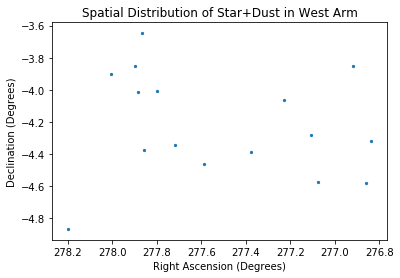

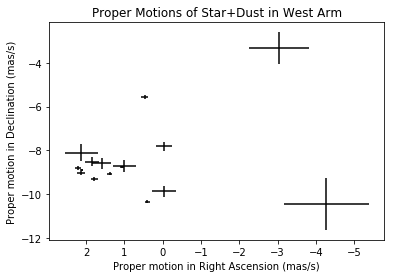

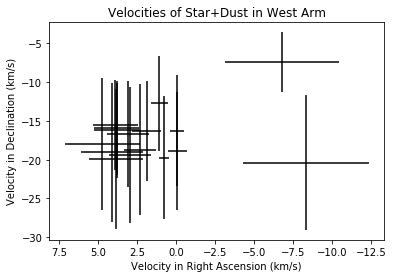

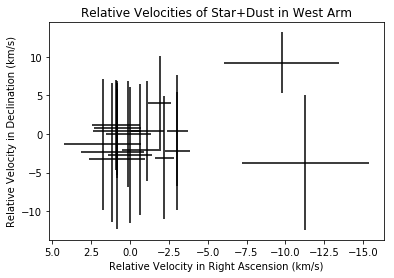

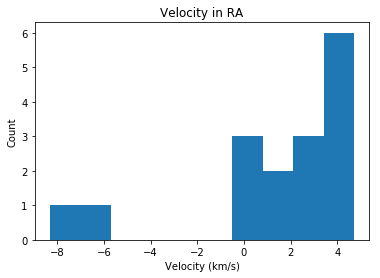

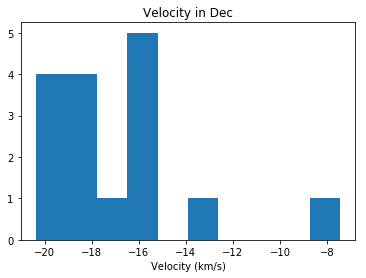

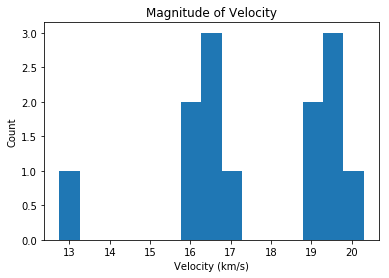

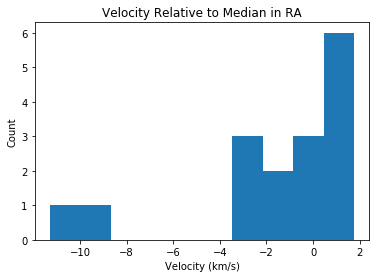

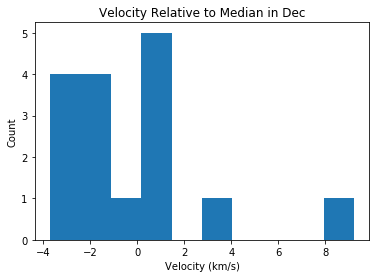

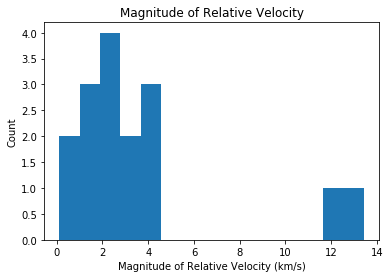

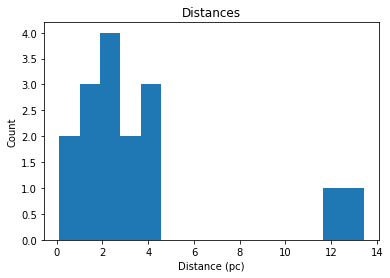

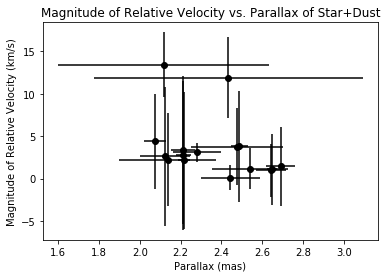

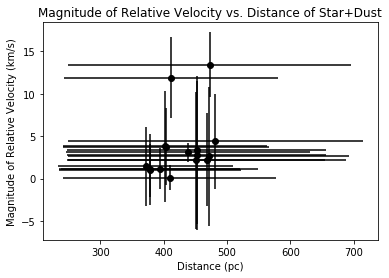

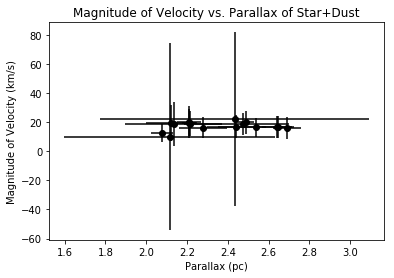

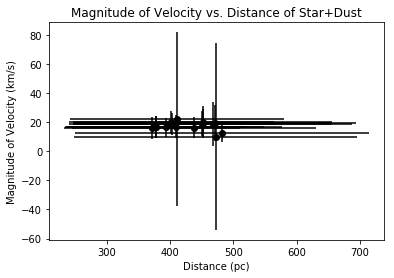

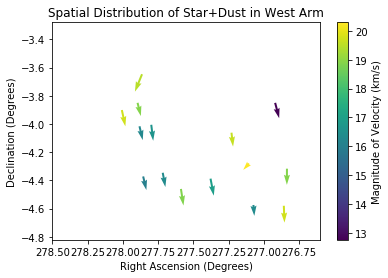

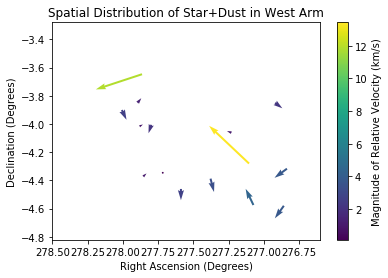

In [52]:
SD_WestArm = CalculateProperties('West Arm','Star+Dust',SD_match,Gvalues,distance_range=[350.,550.],\
                                  sky_region = sky_region2d)

Number of Serpens Main matches in the correct distance interval: 18
Number of _match with parallax > 5, 10, 20:  12 6 2
For all stars in region
The mean velocity in ra is  6.458143703827375 +/- 0.4696292350268847
The mean velocity in dec is  -18.064132549630454 +/- 0.7015374579139492
The median velocity in ra is  6.89859638585855 +/- 0.5885929595558582
The median velocity in dec is  -18.028190213961715 +/- 0.8792468138599302
The mean magnitude of velocity is 19.257889989267664 +/- 0.744718203589535
The median magnitude of velocity is 19.52407019153118 +/- 0.9333658528749671
The standard deviation of velocity is 3.159571750987344
The median parallax is 2.2355908715567496 with a standard deviation of 0.2860451280765743
The median distance is 447.38332201142515 with a standard deviation of 55.07332633719769
For parallax S/N > 10 stars:
The mean velocity in ra is  7.231884482518477 +/- 0.6428456096606938
The mean velocity in dec is  -17.488274806757612 +/- 0.739838408329347
The median velo

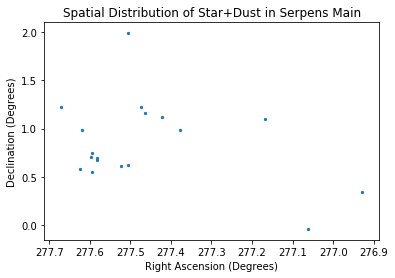

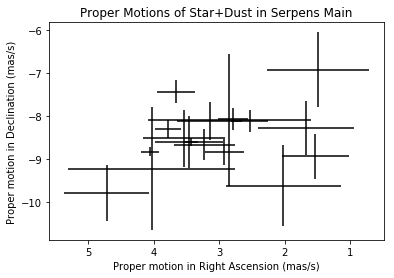

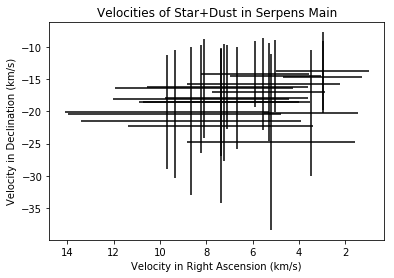

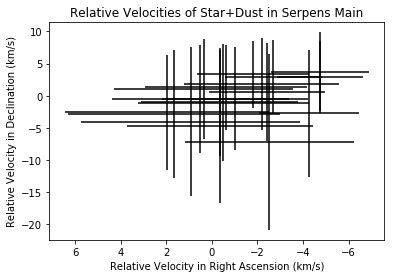

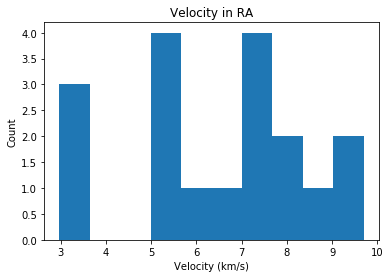

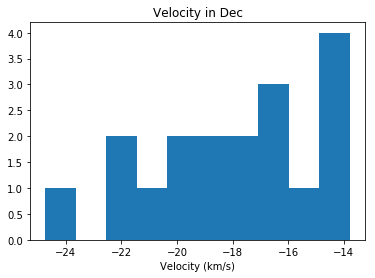

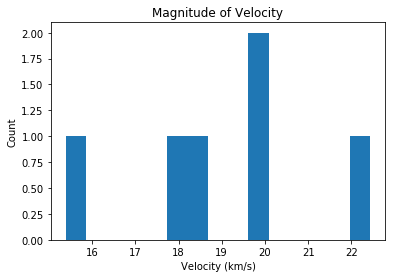

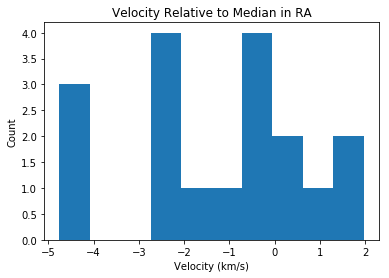

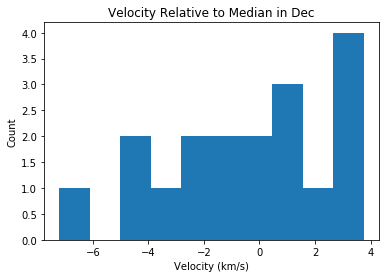

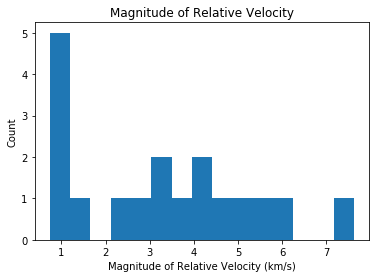

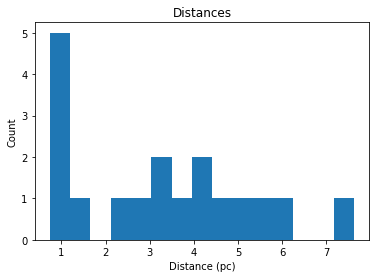

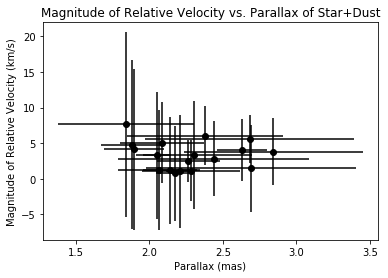

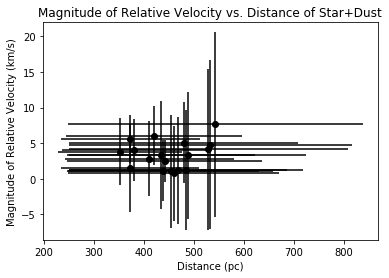

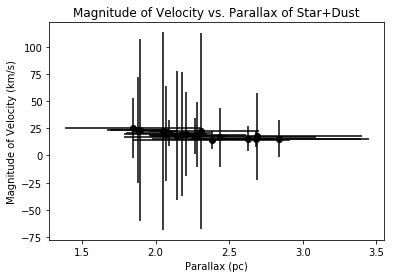

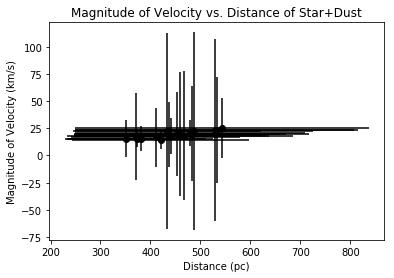

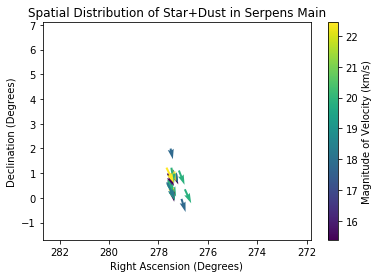

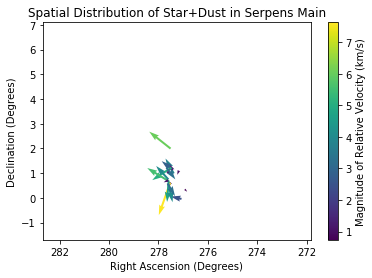

In [53]:
SD_Main = CalculateProperties('Serpens Main','Star+Dust',SD_match,Gvalues, distance_range=[350.,550.],sky_region = sky_region3, \
                               adj = [0,0,1,5])

In [ ]:
#proper motion plot labeled by region
plt.errorbar(SD_East['pmra'],SD_East['pmdec'],yerr = SD_East['pmdec_e'],xerr=SD_East['pmra_e'],linestyle='None'\
            ,color='orange',label='Serpens East',marker='o',markersize=2.5,alpha=0.5)
plt.errorbar(SD_S['pmra'],SD_S['pmdec'],yerr = SD_S['pmdec_e'],xerr=SD_S['pmra_e'],linestyle='None'\
            ,color='red',label='Serpens South',marker='o',markersize=2.5,alpha=0.5)
plt.errorbar(SD_W40['pmra'],SD_W40['pmdec'],yerr = SD_W40['pmdec_e'],xerr=SD_W40['pmra_e'],linestyle='None'\
            ,color='blue',label='W40',marker='o',markersize=2.5,alpha=0.5)
plt.errorbar(SD_WestArm['pmra'],SD_WestArm['pmdec'],yerr = SD_WestArm['pmdec_e'],xerr=SD_WestArm['pmra_e'],linestyle='None'\
            ,color='magenta',label='West Arm',marker='o',markersize=2.5,alpha=0.5)
plt.errorbar(SD_Main['pmra'],SD_Main['pmdec'],yerr = SD_Main['pmdec_e'],xerr=SD_Main['pmra_e'],linestyle='None'\
            ,color='green',label='Serpens Main',marker='o',markersize=2.5,alpha=0.5)
plt.xlabel('Proper Motion in Right Ascension (mas/yr)')
plt.ylabel('Proper Motion in Declination (mas/yr)')
plt.title('Proper Motions')
plt.legend()
plt.xlim(-22,13)
plt.ylim(-35,12)
plt.savefig('Figures/SDproper_motions_regions.png',dpi=300)
plt.show()

## YSOs

In [ ]:
#Plot of selected YSOs


figure = plt.figure()
plt.scatter(YSO_ALL['ra'],YSO_ALL['dec'],s=3)
plt.axis('equal')
plt.xlabel('Right Ascension (Degrees)')
plt.ylabel('Declination (Degrees)')
plt.title('Spatial Distribution of YSOs')
plt.gca().add_patch(Rectangle((ra_min1,dec_min1),width1,height1,fill=False))
plt.gca().add_patch(Rectangle((ra_minW40,dec_minW40),widthW40,heightW40,fill=False))
plt.gca().add_patch(Rectangle((ra_minS,dec_minS),widthS,heightS,fill=False))
plt.gca().add_patch(Rectangle((ra_min2d,dec_min2d),width2d,height2d,fill=False))
plt.gca().add_patch(Rectangle((ra_min3u,dec_min3u),width3u,height3u,fill=False))
plt.gca().add_patch(Rectangle((ra_min3d,dec_min3d),width3d,height3d,fill=False))
plt.text(ra_min1+0.2,dec_min1+0.1,'1')
plt.text(ra_minW40+0.2,dec_minW40+0.1,'2')
plt.text(ra_minS+0.2,dec_minS+0.1,'3')
plt.text(ra_min2d+0.2,dec_min2d+0.1,'4')
plt.text(ra_min3u+0.2,dec_min3u+0.1,'5')
plt.text(ra_min3d+0.2,dec_min3d+0.1,'6')
plt.gca().invert_xaxis()
plt.savefig("Figures/Regions.png",dpi=300)
plt.show()



In [ ]:
YSO_East = CalculateProperties('Serpens East','YSOs',YSO_match,Gvalues, distance_range=[350.,550.], \
                               sky_region = sky_region1,adj=[0,0,0,0])
print('\n\n\nPARALLAX SIGNAL TO NOISE GREATER THAN 5\n\n\n')
ConditionToRegion(YSO_East,YSO_East['parsn5'],'Serpens East','YSOs',sky_region = sky_region1,adj=[0,0,0,0])

In [ ]:
YSO_S = CalculateProperties('Serpens South','YSOs',YSO_match,Gvalues,distance_range=[350.,550.],sky_region = sky_regionS,\
                           adj=[0,0,0,0])
print('\n\n\nPARALLAX SIGNAL TO NOISE GREATER THAN 5\n\n\n')
ConditionToRegion(YSO_S,YSO_S['parsn5'],'Serpens South','YSOs',sky_region = sky_regionS,adj=[0,0,0,0])

In [ ]:
YSO_W40 = CalculateProperties('W40','YSOs',YSO_match,Gvalues,distance_range=[350.,550.],sky_region = sky_regionW40\
                             ,adj=[0,0,0,0])
print('\n\n\nPARALLAX SIGNAL TO NOISE GREATER THAN 5\n\n\n')
ConditionToRegion(YSO_W40,YSO_W40['parsn5'],'W40','YSOs',sky_region = sky_regionW40,adj=[0,0,0,0])

In [ ]:
YSO_WestArm = CalculateProperties('West Arm','YSOs',YSO_match,Gvalues,distance_range=[350.,550.],\
                                  sky_region = sky_region2d)
print('\n\n\nPARALLAX SIGNAL TO NOISE GREATER THAN 5\n\n\n')
ConditionToRegion(YSO_WestArm,YSO_WestArm['parsn5'],'West Arm','YSOs',sky_region = sky_region2d,adj=[0,0,0,0])

In [ ]:
YSO_Main = CalculateProperties('Serpens Main','YSOs',YSO_match,Gvalues, distance_range=[350.,550.],sky_region = sky_region3, \
                               adj = [0,0,1,5])
print('\n\n\nPARALLAX SIGNAL TO NOISE GREATER THAN 5\n\n\n')
ConditionToRegion(YSO_Main,YSO_Main['parsn5'],'Serpens Main','YSOs',sky_region = sky_region3u,adj=[0,0,0,0])

In [ ]:
YSO_Main_NoOutlier = CalculateProperties('Serpens Main No Outlier','YSOs',YSO_match,Gvalues, distance_range=[350.,550.],sky_region = sky_region3u, \
                               adj = [0,0,1,5],exclude = [36497])


In [ ]:
#propermotion 
plt.errorbar(SD_East['pmra'],SD_East['pmdec'],yerr = SD_East['pmdec_e'],xerr=SD_East['pmra_e'],linestyle='None'\
            ,color='red',label='Star+Dust',marker='o',markersize=2.5,alpha=0.5)
plt.errorbar(YSO_East['pmra'],YSO_East['pmdec'],yerr = YSO_East['pmdec_e'],xerr=YSO_East['pmra_e'],linestyle='None'\
            ,color='black',label='YSOs',marker='o',markersize=2.5,alpha=0.5)
plt.xlabel('Proper Motion in Right Ascension (mas/yr)')
plt.ylabel('Proper Motion in Declination (mas/yr)')
plt.title('Proper Motions in Serpens East')
plt.legend()
plt.xlim(-22,13)
plt.ylim(-35,12)
plt.savefig('Figures/SerpensEast/SerpensEast_YSOs_SD_propermotion.png',dpi=300)
plt.show()

plt.errorbar(SD_S['pmra'],SD_S['pmdec'],yerr = SD_S['pmdec_e'],xerr=SD_S['pmra_e'],linestyle='None'\
            ,color='red',label='Star+Dust',marker='o',markersize=2.5,alpha=0.5)
plt.errorbar(YSO_S['pmra'],YSO_S['pmdec'],yerr = YSO_S['pmdec_e'],xerr=YSO_S['pmra_e'],linestyle='None'\
            ,color='black',label='YSOs',marker='o',markersize=2.5,alpha=0.5)
plt.xlabel('Proper Motion in Right Ascension (mas/yr)')
plt.ylabel('Proper Motion in Declination (mas/yr)')
plt.title('Proper Motions in Serpens South')
plt.legend()
plt.xlim(-22,13)
plt.ylim(-35,12)
plt.savefig('Figures/SerpensSouth/SerpensSouth_YSOs_SD_propermotion.png',dpi=300)
plt.show()

plt.errorbar(SD_W40['pmra'],SD_W40['pmdec'],yerr = SD_W40['pmdec_e'],xerr=SD_W40['pmra_e'],linestyle='None'\
            ,color='red',label='Star+Dust',marker='o',markersize=2.5,alpha=0.5)
plt.errorbar(YSO_W40['pmra'],YSO_W40['pmdec'],yerr = YSO_W40['pmdec_e'],xerr=YSO_W40['pmra_e'],linestyle='None'\
            ,color='black',label='YSOs',marker='o',markersize=2.5,alpha=0.5)
plt.xlabel('Proper Motion in Right Ascension (mas/yr)')
plt.ylabel('Proper Motion in Declination (mas/yr)')
plt.title('Proper Motions in W40')
plt.legend()
plt.xlim(-22,13)
plt.ylim(-35,12)
plt.savefig('Figures/W40/W40_YSOs_SD_propermotion.png',dpi=300)
plt.show()

plt.errorbar(SD_WestArm['pmra'],SD_WestArm['pmdec'],yerr = SD_WestArm['pmdec_e'],xerr=SD_WestArm['pmra_e'],linestyle='None'\
            ,color='red',label='Star+Dust',marker='o',markersize=2.5,alpha=0.5)
plt.errorbar(YSO_WestArm['pmra'],YSO_WestArm['pmdec'],yerr = YSO_WestArm['pmdec_e'],xerr=YSO_WestArm['pmra_e'],linestyle='None'\
            ,color='black',label='YSOs',marker='o',markersize=2.5,alpha=0.5)
plt.xlabel('Proper Motion in Right Ascension (mas/yr)')
plt.ylabel('Proper Motion in Declination (mas/yr)')
plt.title('Proper Motions in West Arm')
plt.legend()
plt.xlim(-22,13)
plt.ylim(-35,12)
plt.savefig('Figures/WestArm/WestARm_YSOs_SD_propermotion.png',dpi=300)
plt.show()

plt.errorbar(SD_Main['pmra'],SD_Main['pmdec'],yerr = SD_Main['pmdec_e'],xerr=SD_Main['pmra_e'],linestyle='None'\
            ,color='red',label='Star+Dust',marker='o',markersize=2.5,alpha=0.5)
plt.errorbar(YSO_Main['pmra'],YSO_Main['pmdec'],yerr = YSO_Main['pmdec_e'],xerr=YSO_Main['pmra_e'],linestyle='None'\
            ,color='black',label='YSOs',marker='o',markersize=2.5,alpha=0.5)
plt.xlabel('Proper Motion in Right Ascension (mas/yr)')
plt.ylabel('Proper Motion in Declination (mas/yr)')
plt.title('Proper Motions in Serpens Main')
plt.legend()
plt.xlim(-22,13)
plt.ylim(-35,12)
plt.savefig('Figures/SerpensMain/SerpensMain_YSOs_SD_propermotion.png',dpi=300)
plt.show()


In [ ]:
#Comparison between Serpens South and W40
plt.errorbar(YSO_S['pmra'],YSO_S['pmdec'],yerr = YSO_S['pmdec_e'],xerr=YSO_S['pmra_e'],linestyle='None'\
            ,color='red',label='Serpens South',marker='o',markersize=2.5,alpha=0.5)
plt.errorbar(YSO_W40['pmra'],YSO_W40['pmdec'],yerr = YSO_W40['pmdec_e'],xerr=YSO_W40['pmra_e'],linestyle='None'\
            ,color='black',label='W40',marker='o',markersize=2.5,alpha=0.5)
plt.xlabel('Proper Motion in Right Ascension (mas/yr)')
plt.ylabel('Proper Motion in Declination (mas/yr)')
plt.title('Proper Motions of YSOs in Serpens South and W40')
plt.legend()
plt.xlim(-22,13)
plt.ylim(-35,12)
plt.savefig('Figures/SerpensSouth_W40_YSO_propermotion.png',dpi=300)
plt.show()

In [ ]:
#proper motion plot labeled by region
plt.errorbar(YSO_East['pmra'],YSO_East['pmdec'],yerr = YSO_East['pmdec_e'],xerr=YSO_East['pmra_e'],linestyle='None'\
            ,color='orange',label='Serpens East',marker='o',markersize=2.5,alpha=0.5)
plt.errorbar(YSO_S['pmra'],YSO_S['pmdec'],yerr = YSO_S['pmdec_e'],xerr=YSO_S['pmra_e'],linestyle='None'\
            ,color='red',label='Serpens South',marker='o',markersize=2.5,alpha=0.5)
plt.errorbar(YSO_W40['pmra'],YSO_W40['pmdec'],yerr = YSO_W40['pmdec_e'],xerr=YSO_W40['pmra_e'],linestyle='None'\
            ,color='blue',label='W40',marker='o',markersize=2.5,alpha=0.5)
plt.errorbar(YSO_WestArm['pmra'],YSO_WestArm['pmdec'],yerr = YSO_WestArm['pmdec_e'],xerr=YSO_WestArm['pmra_e'],linestyle='None'\
            ,color='magenta',label='West Arm',marker='o',markersize=2.5,alpha=0.5)
plt.errorbar(YSO_Main['pmra'],YSO_Main['pmdec'],yerr = YSO_Main['pmdec_e'],xerr=YSO_Main['pmra_e'],linestyle='None'\
            ,color='green',label='Serpens Main',marker='o',markersize=2.5,alpha=0.5)
plt.xlabel('Proper Motion in Right Ascension (mas/yr)')
plt.ylabel('Proper Motion in Declination (mas/yr)')
plt.title('Proper Motions')
plt.legend()
plt.xlim(-22,13)
plt.ylim(-35,12)
plt.savefig('Figures/YSOproper_motions_regions.png',dpi=300)
plt.show()


plt.errorbar(YSO_East['pmra'],YSO_East['pmdec'],yerr = YSO_East['pmdec_e'],xerr=YSO_East['pmra_e'],linestyle='None'\
            ,color='orange',label='Serpens East',marker='o',markersize=2.5,alpha=0.5)
plt.errorbar(YSO_S['pmra'],YSO_S['pmdec'],yerr = YSO_S['pmdec_e'],xerr=YSO_S['pmra_e'],linestyle='None'\
            ,color='red',label='Serpens South',marker='o',markersize=2.5,alpha=0.5)
plt.errorbar(YSO_W40['pmra'],YSO_W40['pmdec'],yerr = YSO_W40['pmdec_e'],xerr=YSO_W40['pmra_e'],linestyle='None'\
            ,color='blue',label='W40',marker='o',markersize=2.5,alpha=0.5)
plt.errorbar(YSO_WestArm['pmra'],YSO_WestArm['pmdec'],yerr = YSO_WestArm['pmdec_e'],xerr=YSO_WestArm['pmra_e'],linestyle='None'\
            ,color='magenta',label='West Arm',marker='o',markersize=2.5,alpha=0.5)
plt.errorbar(YSO_Main['pmra'],YSO_Main['pmdec'],yerr = YSO_Main['pmdec_e'],xerr=YSO_Main['pmra_e'],linestyle='None'\
            ,color='green',label='Serpens Main',marker='o',markersize=2.5,alpha=0.5)
plt.xlabel('Proper Motion in Right Ascension (mas/yr)')
plt.ylabel('Proper Motion in Declination (mas/yr)')
plt.title('Proper Motions')
plt.legend()
plt.savefig('Figures/YSOproper_motions_regions_zoom.png',dpi=300)
plt.show()

In [ ]:
W40stars = np.array([])
pmra_matchW40 = np.array([])       #proper motion in RA
pmdec_matchW40 = np.array([])      #proper motion in Dec
pmra_e_matchW40 = np.array([])     #proper motion error in RA
pmdec_e_matchW40 = np.array([])    #proper motion error in Dec
dist_matchW40 = np.array([])       #distance
dist_e_matchW40 = np.array([])     #distance error

W40starsb = np.array([])
pmra_matchW40b = np.array([])       #proper motion in RA
pmdec_matchW40b = np.array([])      #proper motion in Dec
pmra_e_matchW40b = np.array([])     #proper motion error in RA
pmdec_e_matchW40b = np.array([])    #proper motion error in Dec
dist_matchW40b = np.array([])       #distance
dist_e_matchW40b = np.array([])     #distance error

W40starsa = np.array([])
pmra_matchW40a = np.array([])       #proper motion in RA
pmdec_matchW40a = np.array([])      #proper motion in Dec
pmra_e_matchW40a = np.array([])     #proper motion error in RA
pmdec_e_matchW40a = np.array([])    #proper motion error in Dec
dist_matchW40a = np.array([])       #distance
dist_e_matchW40a = np.array([])     #distance error

W40starsS = np.array([])
pmra_matchW40S = np.array([])       #proper motion in RA
pmdec_matchW40S = np.array([])      #proper motion in Dec
pmra_e_matchW40S = np.array([])     #proper motion error in RA
pmdec_e_matchW40S = np.array([])    #proper motion error in Dec
dist_matchW40S = np.array([])       #distance
dist_e_matchW40S = np.array([])     #distance error

for j in range(0,len(Gra)):
    #Filter sources according to distance and region in the sky
    if(Gvalues['Dist'][j] >= 350 and Gvalues['Dist'][j] <= 550 \
        and Gvalues['ra'][j] > sky_regionW40[0] and Gvalues['ra'][j] < sky_regionW40[1] \
        and Gvalues['dec'][j] > sky_regionW40[2] and Gvalues['dec'][j] < sky_regionW40[3]):
        W40stars = np.append(W40stars,j)
        pmra_matchW40 = np.append(pmra_matchW40,Gvalues['pmra'][j])
        pmdec_matchW40 = np.append(pmdec_matchW40,Gvalues['pmdec'][j])
        pmra_e_matchW40 = np.append(pmra_e_matchW40,Gvalues['pmra_error'][j])
        pmdec_e_matchW40 = np.append(pmdec_e_matchW40,Gvalues['pmdec_error'][j])
        dist_matchW40 = np.append(dist_matchW40,Gvalues['Dist'][j])
        dist_e_matchW40 = np.append(dist_e_matchW40, Gvalues['Dist error'][j]) 
        
        
for j in range(0,len(Gra)):
    #Filter sources according to distance and region in the sky
    if(Gvalues['Dist'][j] >= 0 and Gvalues['Dist'][j] <= 350 \
        and Gvalues['ra'][j] > sky_regionW40[0] and Gvalues['ra'][j] < sky_regionW40[1] \
        and Gvalues['dec'][j] > sky_regionW40[2] and Gvalues['dec'][j] < sky_regionW40[3]):
        W40starsb = np.append(W40starsb,j)
        pmra_matchW40b = np.append(pmra_matchW40b,Gvalues['pmra'][j])
        pmdec_matchW40b = np.append(pmdec_matchW40b,Gvalues['pmdec'][j])
        pmra_e_matchW40b = np.append(pmra_e_matchW40b,Gvalues['pmra_error'][j])
        pmdec_e_matchW40b = np.append(pmdec_e_matchW40b,Gvalues['pmdec_error'][j])
        dist_matchW40b = np.append(dist_matchW40b,Gvalues['Dist'][j])
        dist_e_matchW40b = np.append(dist_e_matchW40b, Gvalues['Dist error'][j]) 
        
for j in range(0,len(Gra)):
    #Filter sources according to distance and region in the sky
    if(Gvalues['Dist'][j] >= 550 and Gvalues['Dist'][j] <= 700 \
        and Gvalues['ra'][j] > sky_regionW40[0] and Gvalues['ra'][j] < sky_regionW40[1] \
        and Gvalues['dec'][j] > sky_regionW40[2] and Gvalues['dec'][j] < sky_regionW40[3]):
        W40starsa = np.append(W40starsa,j)
        pmra_matchW40a = np.append(pmra_matchW40a,Gvalues['pmra'][j])
        pmdec_matchW40a = np.append(pmdec_matchW40a,Gvalues['pmdec'][j])
        pmra_e_matchW40a = np.append(pmra_e_matchW40a,Gvalues['pmra_error'][j])
        pmdec_e_matchW40a = np.append(pmdec_e_matchW40a,Gvalues['pmdec_error'][j])
        dist_matchW40a = np.append(dist_matchW40a,Gvalues['Dist'][j])
        dist_e_matchW40a = np.append(dist_e_matchW40a, Gvalues['Dist error'][j]) 
        
for j in range(0,len(Gra)):
    #Filter sources according to distance and region in the sky
    if(Gvalues['Dist'][j] >= 350 and Gvalues['Dist'][j] <= 550 \
        and Gvalues['ra'][j] > sky_regionW40side[0] and Gvalues['ra'][j] < sky_regionW40side[1] \
        and Gvalues['dec'][j] > sky_regionW40side[2] and Gvalues['dec'][j] < sky_regionW40side[3]):
        W40starsS = np.append(W40starsS,j)
        pmra_matchW40S = np.append(pmra_matchW40S,Gvalues['pmra'][j])
        pmdec_matchW40S = np.append(pmdec_matchW40S,Gvalues['pmdec'][j])
        pmra_e_matchW40S = np.append(pmra_e_matchW40S,Gvalues['pmra_error'][j])
        pmdec_e_matchW40S = np.append(pmdec_e_matchW40S,Gvalues['pmdec_error'][j])
        dist_matchW40S = np.append(dist_matchW40S,Gvalues['Dist'][j])
        dist_e_matchW40S = np.append(dist_e_matchW40S, Gvalues['Dist error'][j]) 
        
plt.errorbar(pmra_matchW40,pmdec_matchW40,yerr = pmdec_e_matchW40,xerr=pmra_e_matchW40,linestyle='None'\
            ,color='black',label='All Gaia Sources',marker='o',markersize=2.5,alpha=0.5)
plt.errorbar(SD_W40['pmra'],SD_W40['pmdec'],yerr = SD_W40['pmdec_e'],xerr=SD_W40['pmra_e'],linestyle='None'\
            ,color='red',label='Star+Dust',marker='o',markersize=2.5)
plt.errorbar(YSO_W40['pmra'],YSO_W40['pmdec'],yerr = YSO_W40['pmdec_e'],xerr=YSO_W40['pmra_e'],linestyle='None'\
            ,color='cyan',label='YSOs',marker='o',markersize=2.5)
plt.xlabel('Proper Motion in Right Ascension (mas/yr)')
plt.ylabel('Proper Motion in Declination (mas/yr)')
plt.title('Proper Motions in W40')
plt.legend()
plt.xlim(-22,13)
plt.ylim(-35,12)
plt.savefig('Figures/W40_GaiaComparison',dpi=300)
plt.show()
print('The number of gaia sources is ',len(W40stars))

plt.errorbar(pmra_matchW40b,pmdec_matchW40b,yerr = pmdec_e_matchW40b,xerr=pmra_e_matchW40b,linestyle='None'\
            ,color='black',label='All Gaia Sources',marker='o',markersize=2.5,alpha=0.5)
plt.xlabel('Proper Motion in Right Ascension (mas/yr)')
plt.ylabel('Proper Motion in Declination (mas/yr)')
plt.title('Proper Motions in W40 (Region before 350 pc)')
plt.legend()
plt.xlim(-22,13)
plt.ylim(-35,12)
plt.savefig('Figures/W40_GaiaComparison_before',dpi=300)
plt.show()
print('The number of gaia sources is ',len(W40starsb))

plt.errorbar(pmra_matchW40a,pmdec_matchW40a,yerr = pmdec_e_matchW40a,xerr=pmra_e_matchW40a,linestyle='None'\
            ,color='black',label='All Gaia Sources',marker='o',markersize=2.5,alpha=0.5)
plt.xlabel('Proper Motion in Right Ascension (mas/yr)')
plt.ylabel('Proper Motion in Declination (mas/yr)')
plt.title('Proper Motions in W40 (Region after 550 pc)')
plt.legend()
plt.xlim(-22,13)
plt.ylim(-35,12)
plt.savefig('Figures/W40_GaiaComparison_after',dpi=300)
plt.show()
print('The number of gaia sources is ',len(W40starsa))

plt.errorbar(pmra_matchW40S,pmdec_matchW40S,yerr = pmdec_e_matchW40S,xerr=pmra_e_matchW40S,linestyle='None'\
            ,color='black',label='All Gaia Sources',marker='o',markersize=2.5,alpha=0.5)
plt.xlabel('Proper Motion in Right Ascension (mas/yr)')
plt.ylabel('Proper Motion in Declination (mas/yr)')
plt.title('Proper Motions in Area next to W40')
plt.legend()
plt.xlim(-22,13)
plt.ylim(-35,12)
plt.savefig('Figures/W40_GaiaComparison_side',dpi=300)
plt.show()
print('The number of gaia sources is ',len(W40starsS))

# Both YSOs and S+D in Each Region

In [ ]:
ALL_East = CalculateProperties('Serpens East','All',ALL_match,Gvalues,distance_range=[350.,550.], \
                               sky_region = sky_region1,adj=[0,0,0,0])

In [ ]:
ALL_S = CalculateProperties('Serpens South','All',ALL_match,Gvalues,distance_range=[350.,550.],sky_region = sky_regionS,\
                           adj=[0,0,0,0])

In [ ]:
ALL_W40 = CalculateProperties('W40','All',ALL_match,Gvalues,distance_range=[350.,550.],sky_region = sky_regionW40\
                             ,adj=[0,0,0,0])

In [ ]:
ALL_WestArm = CalculateProperties('West Arm','All',ALL_match,Gvalues,distance_range=[350.,550.],\
                                  sky_region = sky_region2d)

In [ ]:
ALL_Main = CalculateProperties('Serpens Main','All',ALL_match,Gvalues, distance_range=[350.,550.],sky_region = sky_region3u, \
                               adj = [0,0,1,5])

# Compare S+D and YSOs

In [ ]:
#Compare YSOs and SEDs in each region using the kstest


s,p = scipy.stats.ks_2samp(YSO_East['pmmag'],SD_East['pmmag'])
print('Serpens East',p)
s2,p2 = scipy.stats.ks_2samp(YSO_S['pmmag'],SD_S['pmmag'])
print('Serpens South',p2)
s3,p3 = scipy.stats.ks_2samp(YSO_W40['pmmag'],SD_W40['pmmag'])
print('W40',p3)
s4,p4 = scipy.stats.ks_2samp(YSO_WestArm['pmmag'],SD_WestArm['pmmag'])
print('West Arm',p4)
s5,p5 = scipy.stats.ks_2samp(YSO_Main['pmmag'],SD_Main['pmmag'])
print('Star+Dust',p5)

#compare W40 and Serpens South

s,p = scipy.stats.ks_2samp(YSO_W40['pmmag'],YSO_S['pmmag'])
print(p)
s2,p2 = scipy.stats.ks_2samp(YSO_S['pmmag'],YSO_W40['pmmag'])
print(p2)

In [ ]:
def CompareSourceTypes(SD,YSO,region):

    #Errorbar plot of magnitude velocity against parallax
    plt.errorbar(YSO['par'],YSO['pmmag'],yerr = YSO['pmmag_err'],xerr=YSO['par_e'],linestyle='none',marker='o',\
                 color='k',label = 'YSOs')
    plt.errorbar(SD['par'],SD['pmmag'],yerr = SD['pmmag_err'],xerr=SD['par_e'],linestyle='none',marker='o',\
                 color='r',label='Star+Dust')
    plt.xlabel('Parallax (mas)')
    plt.ylabel('Magnitude of Velocity (km/s)')
    plt.title('Magnitude of Velocity vs. Parallax in '+region)
    plt.legend()
    plt.show()
    #plt.savefig('Figures/Comparison_Error'+region.replace(" ",""),dpi=500)
    

def CompareSourceTypes2(SD,YSO,region):

    #Errorbar plot of magnitude velocity against parallax
    plt.scatter(YSO['par'],YSO['pmmag'],color='k',label = 'YSOs')
    plt.scatter(SD['par'],SD['pmmag'],color='r',label='Star+Dust')
    plt.xlabel('Parallax (mas)')
    plt.ylabel('Magnitude of Velocity (km/s)')
    plt.title('Magnitude of Velocity vs. Parallax in '+region)
    plt.legend()
    plt.show()
    #plt.savefig('Figures/Comparison_'+region.replace(" ",""),dpi=500)


CompareSourceTypes2(SD_East,YSO_East,'Serpens East')
CompareSourceTypes2(SD_S,YSO_S,'Serpens South')
CompareSourceTypes2(SD_W40,YSO_W40,'W40')
CompareSourceTypes2(SD_WestArm,YSO_WestArm,'Western Arm')
CompareSourceTypes2(SD_Main,YSO_Main,'Serpens Main')

# Check Outliers

## YSO Outliers using relative velocity

In [ ]:
#Serpens East

shift1 = [5,3,4,9,9,9,9,9,9,9,9,9]
shift2 = [13,11.5,1,9,9,9,9,9,9]
cat = 'YSO'

CheckOutlierRel(YSO_East,YSO_match,shift1,shift2,cat)

In [ ]:
# Serpens South

shift1 = [5,3,4,9,9,9,9,9,9,9,9,9]
shift2 = [13,11.5,1,9,9,9,9,9,9]

CheckOutlierRel(YSO_S,YSO_match,shift1,shift2,cat)

In [ ]:
#W40

shift1 = [3,3,3,3,3.5,3,3,3]
shift2 = [9.75,10,9.5,10,10,9]



CheckOutlierRel(YSO_W40,YSO_match,shift1,shift2,cat)

In [ ]:
#West Arm

shift1 = [5,3,4,9,9,9,9,9,9,9,9,9]
shift2 = [13,11.5,1,9,9,9,9,9,9]

CheckOutlierRel(YSO_WestArm,YSO_match,shift1,shift2,cat)

In [ ]:
#Serpens Main

shift1 = [3,3,3,3,3,3,3,3,3,3]
shift2 = [9.75,10.5,9.5,10,10]

CheckOutlierRel(YSO_Main,YSO_match,shift1,shift2,cat)

# Star + Dust Outliers using relative velocity

In [ ]:
cat = 'SD'
CheckOutlierRel(SD_East,SD_match,shift1,shift2,cat)

In [ ]:
CheckOutlierRel(SD_S,SD_match,shift1,shift2,cat)

In [ ]:
CheckOutlierRel(SD_W40,SD_match,shift1,shift2,cat)

In [ ]:
CheckOutlierRel(SD_WestArm,SD_match,shift1,shift2,cat)

In [ ]:
CheckOutlierRel(SD_Main,SD_match,shift1,shift2,cat)

# Plots of Regions

In [ ]:
#Arrays of coordinates and relative velocities of outliers
RAs = np.array([YSO_East['ra'][4],YSO_East['ra'][13],YSO_W40['ra'][0],YSO_W40['ra'][1],YSO_W40['ra'][3],YSO_W40['ra'][4],\
                YSO_W40['ra'][17],YSO_Main['ra'][60])
DECs = np.array([YSO_East['dec'][4],YSO_East['dec'][13],YSO_W40['dec'][0],YSO_W40['dec'][1],YSO_W40['dec'][3],YSO_W40['dec'][4],\
                YSO_W40['dec'][17],YSO_Main['dec'][60])
RPMRAs = np.array([YSO_East['rpmra'][4],YSO_East['rpmra'][13],YSO_W40['rpmra'][0],YSO_W40['rpmra'][1],\
                YSO_W40['rpmra'][3],YSO_W40['rpmra'][4],YSO_W40['rpmra'][17],YSO_Main['rpmra'][60])
RPMDECs = np.array([YSO_East['rpmdec'][4],YSO_East['rpmdec'][13],YSO_W40['rpmdec'][0],YSO_W40['rpmdec'][1],\
                YSO_W40['rpmdec'][3],YSO_W40['rpmdec'][4],YSO_W40['rpmdec'][17],YSO_Main['rpmdec'][60])
RPMMAGs = np.array([YSO_East['rpmmag'][4],YSO_East['rpmmag'][13],YSO_W40['rpmmag'][0],YSO_W40['rpmmag'][1],\
                YSO_W40['rpmmag'][3],YSO_W40['rpmmag'][4],YSO_W40['rpmmag'][17],YSO_Main['rpmmag'][60])
print(RPMMAGs)

#Plot all YSOs and indicate outliers with arrows
figure = plt.figure()
plt.scatter(c2dYSOra,c2dYSOdec,c='darkgray',s=1)
plt.scatter(GBYSOra[GBYSOra > 275],GBYSOdec[GBYSOra > 275],c='darkgray',s=1)
plt.quiver(RAs,DECs,RPMRAs,RPMDECs,RPMMAGs,scale=125)
c = plt.colorbar()
c.set_label('Magnitude of Relative Velocity (km/s)')
plt.ylim(-4.5,3)
plt.gca().invert_xaxis()
plt.gca().set_aspect('equal', adjustable='box')
plt.xlabel('Right Ascension (degrees)')
plt.ylabel('Declination (degrees)')
plt.title('Spatial Distribution of YSOs')
#plt.savefig('Figures/Comparison.png',dpi=400)
plt.show()

In [ ]:
#Arrays of coordinates and relative velocities of outliers 
RAs = np.array([YSO_East['ra'][4],YSO_East['ra'][13],YSO_W40['ra'][0],YSO_W40['ra'][1],YSO_W40['ra'][3],YSO_W40['ra'][4],\
                YSO_W40['ra'][17],YSO_Main['ra'][60]])
DECs = np.array([YSO_East['dec'][4],YSO_East['dec'][13],YSO_W40['dec'][0],YSO_W40['dec'][1],YSO_W40['dec'][3],YSO_W40['dec'][4],\
                YSO_W40['dec'][17],YSO_Main['dec'][60]])
pmras = np.array([YSO_East['pmra'][4],YSO_East['pmra'][13],YSO_W40['pmra'][0],YSO_W40['pmra'][1],\
                YSO_W40['pmra'][3],YSO_W40['pmra'][4],YSO_W40['pmra'][17],YSO_Main['pmra'][60]])
pmdecs = np.array([YSO_East['pmdec'][4],YSO_East['pmdec'][13],YSO_W40['pmdec'][0],YSO_W40['pmdec'][1],\
                YSO_W40['pmdec'][3],YSO_W40['pmdec'][4],YSO_W40['pmdec'][17],YSO_Main['pmdec'][60]])
pmmags = np.array([YSO_East['pmmag'][4],YSO_East['pmmag'][13],YSO_W40['pmmag'][0],YSO_W40['pmmag'][1],\
                YSO_W40['pmmag'][3],YSO_W40['pmmag'][4],YSO_W40['pmmag'][17],YSO_Main['pmmag'][60]])
#print(pmmags)

#Plot all YSOs and indicate outliers with arrows
figure = plt.figure()
plt.scatter(c2dYSOra,c2dYSOdec,c='darkgray',s=1)
plt.scatter(GBYSOra[GBYSOra > 275],GBYSOdec[GBYSOra > 275],c='darkgray',s=1)
plt.quiver(RAs,DECs,pmras,pmdecs,pmmags,scale=125)
c = plt.colorbar()
c.set_label('Magnitude of Velocity (km/s)')
plt.ylim(-4.5,3)
plt.gca().invert_xaxis()
plt.gca().set_aspect('equal', adjustable='box')
plt.xlabel('Right Ascension (degrees)')
plt.ylabel('Declination (degrees)')
plt.title('Spatial Distribution of YSOs')
#plt.savefig('Figures/Comparison.png',dpi=400)
plt.show()

In [ ]:
#parsecs per degree
pcperdeg = 3600*450/206265

#Degrees traveled in 500,000 years
arrows = RPMMAGs/pcperdeg/2
print(arrows)

# Spare Code

In [ ]:
# Spare Code

#absoulte flux in each filter
g_flux_abs = np.power((Gdist[id]/10),2)*g_flux[id]
b_flux_abs = np.power((Gdist[id]/10),2)*b_flux[id]
r_flux_abs = np.power((Gdist[id]/10),2)*r_flux[id]
J_flux_abs = np.power((Gdist[id]/10),2)*J_flux[id]
H_flux_abs = np.power((Gdist[id]/10),2)*H_flux[id]
K_flux_abs = np.power((Gdist[id]/10),2)*K_flux[id]
IR1_flux_abs = np.power((Gdist[id]/10),2)*IR1_flux[cid]
IR2_flux_abs = np.power((Gdist[id]/10),2)*IR2_flux[cid]
IR3_flux_abs = np.power((Gdist[id]/10),2)*IR3_flux[cid]
IR4_flux_abs = np.power((Gdist[id]/10),2)*IR4_flux[cid]
MP1_flux_abs = np.power((Gdist[id]/10),2)*MP1_flux[cid]
MP2_flux_abs = np.power((Gdist[id]/10),2)*MP2_flux[cid]

#absolute magnitude in each filter
g_abs = g[id] - 5*np.log10(Gdist[id]) + 5
b_abs = b[id] - 5*np.log10(Gdist[id]) + 5
r_abs = r[id] - 5*np.log10(Gdist[id]) + 5
J_abs = J[id] - 5*np.log10(Gdist[id]) + 5
H_abs = H[id] - 5*np.log10(Gdist[id]) + 5
K_abs = K[id] - 5*np.log10(Gdist[id]) + 5
IR1_abs = IR1[cid] - 5*np.log10(Gdist[id]) + 5
IR2_abs = IR2[cid] - 5*np.log10(Gdist[id]) + 5
IR3_abs = IR3[cid] - 5*np.log10(Gdist[id]) + 5
IR4_abs = IR4[cid] - 5*np.log10(Gdist[id]) + 5
MP1_abs = MP1[cid] - 5*np.log10(Gdist[id]) + 5
MP2_abs = MP2[cid] - 5*np.log10(Gdist[id]) + 5

#Apparent Magnitude SED
plt.plot(wvl_micro,SED,marker = 'o',linestyle='--')
plt.gca().invert_yaxis()
plt.xscale('log')
plt.xlabel('Wavelength ($\mu$m)')
plt.ylabel('Apparent Magnitude')
plt.title('Apparent Magnitude SED of Outlier')
plt.show()
                          
#Absolute Magnitude SED
SED_abs = np.array([b_abs,g_abs,r_abs,J_abs,H_abs,K_abs, IR1_abs, IR2_abs, IR3_abs, IR4_abs,MP1_abs])
plt.plot(wvl_micro,SED_abs,marker = 'o',linestyle='--')
plt.gca().invert_yaxis()
plt.xscale('log')
plt.xlabel('Wavelength ($\mu$m)')
plt.ylabel('Absolute Magnitude')
plt.title('Absolute Magnitude SED of Outlier')
plt.show()

#Absolute Flux SED
SED_flux_abs = np.array([b_flux_abs,g_flux_abs,r_flux_abs,J_flux_abs,H_flux_abs,K_flux_abs, \
                            IR1_flux_abs, IR2_flux_abs, IR3_flux_abs, IR4_flux_abs,MP1_flux_abs])
#multiply flux by frequency
SED_nu_abs = SED_flux_abs*nu 
plt.plot(wvl_micro,np.log10(SED_nu_abs),marker = 'o',linestyle='--')
#plot planck function
plt.plot(wvl_micro,np.log10(Bnu)+shift2[i])
#linear fit
[m,b2] = np.polyfit(np.log10(wvl_micro[5:11]),np.log10(SED_nu_abs[5:11]),deg=1)
B_lin = m*np.log10(wvl_micro[5:11])+b2
line_label = 'y = '+str(round(m,2)) +' x + '+str(round(b2,2))
plt.plot(wvl_micro[5:11],B_lin,label=line_label)
plt.xscale('log')
plt.xlabel('log10($\lambda$) ($\mu$m)')
plt.ylabel('log10(v Fv) (erg/s/cm$^2$)')
plt.title('Absolute Flux SED of '+important_id)
plt.legend()
plt.show()

In [ ]:
#using own gaussian fit function
'''
mu = 3.333
var = 1
height = 2.5*ymax
x = np.linspace(0, xmax, 100)
p = gaussian(x,var,mu,height)
plt.plot(x, p, 'k', linewidth=2)
'''
#using mlab
'''
(mu, sigma) = scipy.stats.norm.pdf(par_vals)
y = mlab.normpdf(bins, mu, sigma)
plt.plot(bins, y, 'r--', linewidth=2)
'''

#using norm.pdf (gives same results as mlab)
'''
(mean,std) = scipy.stats.norm.fit(par_vals)
x = np.linspace(xmin, xmax, 100)
y = scipy.stats.norm.pdf(x, mean, std)
'''

In [ ]:
  '''
    #WAVELENGTH PLOT!!!!
    SED_wvl = SED_flux*(const.c.value/(wvl_micro*1e-10))
    #plot nu*fnu
    plt.plot(wvl_micro,np.log10(SED_wvl),marker = 'o',linestyle='--')
    #plot planck function
    T = 4000.
    B= ((2*const.h.cgs.value*np.power(nu,3))/(np.power(const.c.cgs.value,2)))*\
                (1/(np.exp((const.h.cgs.value*nu)/(const.k_B.cgs.value*T))-1))
    B_wvl = B*wvl_micro
    plt.plot(wvl_micro,np.log10(B_wvl)+shift2,label= r'$\lambda\, B_{\lambda}$ for T = 4,000 K')
    #plot Linear Fit
    [m1,b1] = np.polyfit(np.log10(nu[5:11]),np.log10(SED_wvl[5:11]),deg=1)
    alpha = m1
    B_lin = m1*np.log10(nu[5:11])+b1
    line_label = r'$\alpha$ = '+ str(round(alpha,2))
    plt.plot(wvl_micro[5:11],B_lin,label=line_label)
    #Labels
    plt.xscale('log')
    plt.xlabel(r'log10($\lambda$) ($\mu$m)')
    plt.ylabel(r'log10($\lambda\, F_{\lambda}$) (erg/s/cm$^2$)')
    plt.title('Apparent Flux SED of '+important_id)
    plt.legend()
    #plt.savefig('Figures/+folder+'/'++str(important_id).replace(" ","").replace(".","_")+"_apparent_flux_SED.png",dpi=300)
    plt.show()
    '''